1. Energy consumption section
2. Weather data section
3. Future prediction

In [27]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras

# Functions

In [28]:
# energy consumption 

def scaleAllData(df):
    allScalers = []
    for column in df.columns:
        df1 = df[column]
        scaler = MinMaxScaler(feature_range=(0,1))
        df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
        allScalers.append(scaler)
    return df, allScalers

In [29]:
#energy consumption
def saveScalers(colNames, allScalers):
    i = 0
    for scaler in allScalers:
        scaler_filename = colNames[i] + ".save"
#         print(scaler_filename)
        joblib.dump(scaler, scaler_filename)
        i+=1

In [30]:
#energy consumption
def df_to_X_y(df, megawattsPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-1):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][megawattsPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [31]:
#weather data
def df_to_X_y_weather(df, predictValuePos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictValuePos] 
        y.append(label)
    return np.array(X), np.array(y)

In [32]:
#weather data

# getting the day cos data for the next 24 hours for prediction
def prepareCircularTimeData(df, colName, howManyHours, timeSteps):
    
    # has last 3 hours of december 31st
    previousDaysData = np.array(df[colName][8757:][0:]).reshape(1,-1)
    previousDaysSin = np.array(df['Day sin'][8757:][0:]).reshape(1,-1)
    previousDaysCos = np.array(df['Day cos'][8757:][0:]).reshape(1,-1)
    previousYearsSin = np.array(df['Year sin'][8757:][0:]).reshape(1,-1)
    previousYearsCos = np.array(df['Year cos'][8757:][0:]).reshape(1,-1)

    previousDaysData = list(previousDaysData)[0].tolist()
    previousDaysSin = list(previousDaysSin)[0].tolist()
    previousDaysCos = list(previousDaysCos)[0].tolist()
    previousYearsSin = list(previousYearsSin)[0].tolist()
    previousYearsCos = list(previousYearsCos)[0].tolist()

    futurePredData = []
    for i in range(timeSteps):
        mem = []
        mem.append(previousDaysData[i])
        mem.append(previousDaysSin[i])
        mem.append(previousDaysCos[i])
        mem.append(previousYearsSin[i])
        mem.append(previousYearsCos[i])
        futurePredData.append(mem)
    
    # Day sin, Day cos, Year sin, Year cos
    # Need these in addition to the weather data variable information for circular time
    startPos = 0
    endPos = 24

    previousDaysSin = np.array(df['Day sin'][startPos:endPos][0:]).reshape(1,-1)
    previousDaysCos = np.array(df['Day cos'][startPos:endPos][0:]).reshape(1,-1)
    previousYearsSin = np.array(df['Year sin'][startPos:endPos][0:]).reshape(1,-1)
    previousYearsCos = np.array(df['Year cos'][startPos:endPos][0:]).reshape(1,-1)

    previousDaysSin = list(previousDaysSin)[0].tolist()
    previousDaysCos = list(previousDaysCos)[0].tolist()
    previousYearsSin = list(previousYearsSin)[0].tolist()
    previousYearsCos = list(previousYearsCos)[0].tolist()

    for i in range(endPos):
        mem = []
        mem.append(previousDaysSin[i])
        mem.append(previousDaysCos[i])
        mem.append(previousYearsSin[i])
        mem.append(previousYearsCos[i])
        futurePredData.append(mem)
    
#     print(np.array(futurePredData))
    return futurePredData
    

In [33]:
#weather data 
def futurePredictions_weather(model, data, hourPred, timesteps, numVars):
    future_outputs=[]
    i=0
    beg = 0
    end = 3
    while(i < hourPred): #for the next however many hours
        oneStep = np.array(list(data[beg:end])).reshape(1, timesteps, numVars) #1 list, each index has n_steps (3) of numVars (5) data
        yhat = model.predict(oneStep, verbose=0)#.flatten()
        future_outputs.append(yhat[0][0])
        data[end].insert(0, yhat[0][0])
        beg += 1
        end += 1
        i+=1

    return future_outputs

In [34]:
def futurePredictions_all(model, lastDay_input, weatherData, hourPred, timesteps, numVars):
    future_outputs=[]
    i=0
    counter = 0
    while(i<hourPred): #for the next thirty hours
        if i == 0: #for the first new predicted value, using old weather data to predict new value 
            lastDay_input = np.array(lastDay_input)
            lastDay_input = lastDay_input.reshape(1, timesteps, numVars)
            yhat = model.predict(lastDay_input, verbose=0)#.flatten()
            print(yhat[0])
#             future_outputs.extend(yhat.tolist())
            future_outputs.append(yhat[0][0])
            i=i+1
        else:# then take from the 1 position and getting the new input and putting it into input
#             print(future_outputs[counter])
            setVal = future_outputs[counter].item()
            weatherData.at[counter, -1:] = setVal #set the megawatts val from the prev predicted
            oneData = np.array(weatherData.iloc[counter, :]) #one day of data 
#             print("{} hour input {}".format(1, oneData))
            oneData = oneData.reshape((1, timesteps, numVars)) #works
            yhat = model.predict(oneData, verbose=0)
#             print("{} hour output {}".format(i,yhat))
#             future_outputs.extend(yhat.tolist())
            future_outputs.append(yhat[0][0])
            i=i+1
            counter+=1

    return future_outputs

In [35]:
def prepareDf(columns):
    directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/'
    dataFiles = [f for f in listdir(directory) if isfile(join(directory, f))] 
    for file in dataFiles:
        print(file)
        df = pd.read_csv(directory + file)

    #for now, I will only use SF data 
    location = '_LA'
    fileRead = directory + dataFiles[3]
    print('fileRead: ', fileRead)
    df = pd.read_csv(fileRead)

    df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
    df['date']= df["date"].map(lambda x: x.replace(year=2019))
    df.index = df['date']
    df.drop('date', axis=1, inplace=True)

    ################################################ preprocess #########################################################
    df, allScalers = scaleAllData(df)
    colNames = df.columns
    
    saveScalers(colNames, allScalers) #saving scalers
    
    df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
    day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
    year = 365.2425*day #num seconds in a year
    df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
    df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
    df['Year sin'] = np.sin(df['Seconds']*2*(np.pi/year))
    df['Year cos'] = np.cos(df['Seconds']*2*(np.pi/year))

    df = df.drop('Seconds', axis = 1)

    cols = columns
    df = df[cols]
    return df

In [36]:
def energyConsumptionModel(df, numEpochs):
    megawattsPos = 30
    X, y = df_to_X_y(df, megawattsPos, 1) 
    #############################################train and test #########################################################
    train_percent = 0.9
    validation_percent = 0.1

    train_percent_split = int(train_percent * len(X))
    validation_percent_split = int(validation_percent * len(X)) + train_percent_split
    print(validation_percent_split)

    X_train, y_train = X[:train_percent_split], y[:train_percent_split]
    X_val, y_val = X[train_percent_split:validation_percent_split], y[train_percent_split:validation_percent_split] #validation

    # just gonna have it hold like 1 day of prev data 
    testData = 8760 - 2
    X_test, y_test = X[testData:], y[testData:]

    # X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer

    storeModel = '/Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA'
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = numEpochs, callbacks = [cp])

    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model

In [37]:
def getBestEnergyConsumptionModel(iters, df, numEpochs):
    getBest = {}
    for i in range(iters):
        rmse, model = energyConsumptionModel(df, numEpochs)
        getBest.update({rmse:model})
    lowestRmse = min(getBest.keys())
    return getBest[lowestRmse]
    

In [38]:
def weatherVariableModel(df, window_size, column, numEpochs):
    ################### get a variable to predict for ##################
    getCols = ['Day sin', 'Day cos', 'Year sin', 'Year cos']
    getCols.append(column)
    col = df[getCols]
    predictColPos = len(col.columns) - 1
    X1, y1 = df_to_X_y_weather(col, predictColPos, window_size)

    ################## split data ##################
    train_percent = 0.9
    validation_percent = 0.1
    train_percent_split = int(train_percent * len(X1))
    validation_percent_split = int(validation_percent * len(X1)) + train_percent_split

    X_train1, y_train1 = X1[:train_percent_split], y1[:train_percent_split]
    X_val1, y_val1 = X1[train_percent_split:validation_percent_split], y1[train_percent_split:validation_percent_split] #validation

    # just gonna have it hold like 1 day of prev data 
    testData = validation_percent_split - 2
    X_test1, y_tes1t = X1[testData:], y1[testData:]

    numDataInputs = X_train1.shape[1]
    numSteps = X_train1.shape[2]
    
    ################## Model Creation ##################
    modelx = Sequential()
    modelx.add(LSTM(64,input_shape=(numDataInputs, numSteps))) # input layer; 5 data inputs, 3 step (3 hr)
    modelx.add(Dense(32, 'relu')) #hidden layer 1
    modelx.add(Dense(32, 'relu')) #hidden layer 2
    modelx.add(Dense(1, 'linear')) #output layer
    storeModel = '/Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/'
    cpx = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    modelx.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

    modelx.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs = numEpochs, callbacks = [cpx])
    train_predictions = modelx.predict(X_train1).flatten()
    rmse = mean_squared_error(train_predictions, y_train1, squared=False)
    print("RMSE value: ", rmse)
    return rmse, modelx
    

In [39]:
def getBestWeatherModels(df, window_size, columns, numEpochs, iters):
    getBest = []
    for column in columns:
        getBestOneVar = {}
        for i in range(iters):
            rmse, model = weatherVariableModel(df, window_size, column, numEpochs)
            getBestOneVar.update({rmse:model})
        #now store the best one for that variables
        lowestRmse = min(getBestOneVar.keys())
        getBest.append(getBestOneVar[lowestRmse])
    return getBest

In [40]:
def bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, columnsForDf, columns):
    df = prepareDf(columnsForDf)
    bestEnergyConsumptionModel = getBestEnergyConsumptionModel(iters, df, numEpochs)
    directory = 'Best_LA/'
    bestEnergyConsumptionModel.save(directory+'energyModel', save_format = 'utf')
    print("--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------")
    #we only want weather variable prediction, so only pass the correct stuff
    
    bestWeatherDataModels = getBestWeatherModels(df, window_size, columns, numEpochs, iters)
    
    #save the models
    j = 0
    for weatherModel in bestWeatherDataModels:
        weatherModel.save(directory+columns[j], save_format = 'utf')
        j+=1
    
    i = 0
    numVars = 5 # 3 time steps, 5 variables (for weather variable prediction)
    allVarFuturePreds = []
    for column in columns:
        futurePredData = prepareCircularTimeData(df, column, howManyFutureHours, window_size)
        future_outputs = futurePredictions_weather(bestWeatherDataModels[i], futurePredData, howManyFutureHours, window_size, numVars)
        allVarFuturePreds.append(future_outputs)
        i+=1

    df2 = pd.DataFrame(allVarFuturePreds)
    df2 = df2.T
    df2.columns = columns
    # df2.to_csv('weatherPred.csv', encoding='utf-8', index = False) #MIGHT HAVE TO CHANGE THIS TO weatherPred + i

    ########################################## FUTURE PREDICTION #######################################################
    weatherPred = df2
    daySin = df['Day sin'][0:24]
    dayCos = df['Day cos'][0:24]
    yearSin = df['Year sin'][0:24]
    yearCos = df['Year cos'][0:24]

    addFiles = [daySin, dayCos, yearSin, yearCos]
    weatherPred['Day sin'] = daySin.values
    weatherPred['Day cos'] = dayCos.values
    weatherPred['Year sin'] = yearSin.values
    weatherPred['Year cos'] = yearCos.values
    weatherPred['Megawatts_2020'] = 0

    lastDay = df[-1:]
    lst_output = futurePredictions_all(bestEnergyConsumptionModel, lastDay, weatherPred, 24, 1, 31)

    ########################################### check output #######################################################
    scaler_filename = 'Megawatts_2019.save'
    megawattsScaler = joblib.load(scaler_filename)

    predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
    predicted24Hours = pd.DataFrame(predictedVals)

    check_directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_2020/'
    compFiles = [f for f in listdir(check_directory) if isfile(join(check_directory, f))] 
    flies = []
    for file in compFiles:
    #     print(file)
        flies.append(check_directory + file)
    df1 = pd.read_csv(flies[2])
    actual24Hours = df1['Megawatts_2020'][:24]

    print("----------------------------FINAL, DONE;----------------------------")
    plt.plot(actual24Hours, color = 'blue')
    plt.plot(predicted24Hours, color = 'red')
    plt.show()

    rmse = mean_squared_error(actual24Hours, predicted24Hours, squared=False)
    print("RMSE value: ", rmse)

# Testing

SAC-NOAA-and-Megawatts.csv
SD-NOAA-and-Megawatts.csv
SF-NOAA-and-Megawatts.csv
LA-NOAA-and-Megawatts.csv
fileRead:  /Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/LA-NOAA-and-Megawatts.csv
8758
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 2/20
223/247 [==========================>...] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0524

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0388

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 8.3396e-04 - val_root_mean_squared_error: 0.0289
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 7.8811e-04 - root_mean_squared_error: 0.0281

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.9401e-04 - root_mean_squared_error: 0.0282 - val_loss: 4.8576e-04 - val_root_mean_squared_error: 0.0220
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 6.6396e-04 - root_mean_squared_error: 0.0258

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.5901e-04 - root_mean_squared_error: 0.0257 - val_loss: 3.9729e-04 - val_root_mean_squared_error: 0.0199
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 6.5162e-04 - root_mean_squared_error: 0.0255

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.5158e-04 - root_mean_squared_error: 0.0255 - val_loss: 3.6786e-04 - val_root_mean_squared_error: 0.0192
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 5.4990e-04 - root_mean_squared_error: 0.0234

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.5446e-04 - root_mean_squared_error: 0.0235 - val_loss: 3.0956e-04 - val_root_mean_squared_error: 0.0176
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 5.1353e-04 - root_mean_squared_error: 0.0227 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 9/20
247/247 [==============================] - 0s 2ms/step - loss: 5.2170e-04 - root_mean_squared_error: 0.0228 - val_loss: 4.0955e-04 - val_root_mean_squared_error: 0.0202
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 4.9818e-04 - root_mean_squared_error: 0.0223

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.9664e-04 - root_mean_squared_error: 0.0223 - val_loss: 2.6805e-04 - val_root_mean_squared_error: 0.0164
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 4.8926e-04 - root_mean_squared_error: 0.0221 - val_loss: 2.8517e-04 - val_root_mean_squared_error: 0.0169
Epoch 12/20
247/247 [==============================] - 0s 2ms/step - loss: 4.9256e-04 - root_mean_squared_error: 0.0222 - val_loss: 2.6915e-04 - val_root_mean_squared_error: 0.0164
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 4.3933e-04 - root_mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.3792e-04 - root_mean_squared_error: 0.0209 - val_loss: 2.5648e-04 - val_root_mean_squared_error: 0.0160
Epoch 14/20
247/247 [==============================] - 0s 2ms/step - loss: 4.3570e-04 - root_mean_squared_error: 0.0209 - val_loss: 2.5932e-04 - val_root_mean_squared_error: 0.0161
Epoch 15/20
230/247 [==========================>...] - ETA: 0s - loss: 4.1768e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.1529e-04 - root_mean_squared_error: 0.0204 - val_loss: 2.5071e-04 - val_root_mean_squared_error: 0.0158
Epoch 16/20
247/247 [==============================] - 0s 2ms/step - loss: 4.0328e-04 - root_mean_squared_error: 0.0201 - val_loss: 4.1358e-04 - val_root_mean_squared_error: 0.0203
Epoch 17/20
247/247 [==============================] - 0s 2ms/step - loss: 3.9509e-04 - root_mean_squared_error: 0.0199 - val_loss: 3.2191e-04 - val_root_mean_squared_error: 0.0179
Epoch 18/20
240/247 [============================>.] - ETA: 0s - loss: 3.7292e-04 - root_mean_squared_error: 0.0193

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.7153e-04 - root_mean_squared_error: 0.0193 - val_loss: 2.4048e-04 - val_root_mean_squared_error: 0.0155
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6971e-04 - root_mean_squared_error: 0.0192 - val_loss: 2.7661e-04 - val_root_mean_squared_error: 0.0166
Epoch 20/20
247/247 [==============================] - 0s 2ms/step - loss: 3.6714e-04 - root_mean_squared_error: 0.0192 - val_loss: 2.9469e-04 - val_root_mean_squared_error: 0.0172
RMSE value:  0.016941304867845217
8758
Epoch 1/20
221/247 [=========================>....] - ETA: 0s - loss: 0.0223 - root_mean_squared_error: 0.1494

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0497

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 9.7198e-04 - val_root_mean_squared_error: 0.0312
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0365

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 6.8132e-04 - val_root_mean_squared_error: 0.0261
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 7.7868e-04 - root_mean_squared_error: 0.0279

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.6607e-04 - root_mean_squared_error: 0.0277 - val_loss: 4.7310e-04 - val_root_mean_squared_error: 0.0218
Epoch 5/20
222/247 [=========================>....] - ETA: 0s - loss: 7.2010e-04 - root_mean_squared_error: 0.0268

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.0856e-04 - root_mean_squared_error: 0.0266 - val_loss: 4.5933e-04 - val_root_mean_squared_error: 0.0214
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 6.3546e-04 - root_mean_squared_error: 0.0252

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.3673e-04 - root_mean_squared_error: 0.0252 - val_loss: 3.6602e-04 - val_root_mean_squared_error: 0.0191
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 5.8641e-04 - root_mean_squared_error: 0.0242 - val_loss: 4.0362e-04 - val_root_mean_squared_error: 0.0201
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 5.2997e-04 - root_mean_squared_error: 0.0230 - val_loss: 5.2673e-04 - val_root_mean_squared_error: 0.0230
Epoch 9/20
241/247 [============================>.] - ETA: 0s - loss: 5.2371e-04 - root_mean_squared_error: 0.0229

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.2091e-04 - root_mean_squared_error: 0.0228 - val_loss: 3.0113e-04 - val_root_mean_squared_error: 0.0174
Epoch 10/20
247/247 [==============================] - 0s 2ms/step - loss: 5.1395e-04 - root_mean_squared_error: 0.0227 - val_loss: 3.2310e-04 - val_root_mean_squared_error: 0.0180
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 4.6603e-04 - root_mean_squared_error: 0.0216 - val_loss: 3.0419e-04 - val_root_mean_squared_error: 0.0174
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 4.4809e-04 - root_mean_squared_error: 0.0212

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.4315e-04 - root_mean_squared_error: 0.0211 - val_loss: 2.9329e-04 - val_root_mean_squared_error: 0.0171
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3458e-04 - root_mean_squared_error: 0.0208 - val_loss: 3.6705e-04 - val_root_mean_squared_error: 0.0192
Epoch 14/20
247/247 [==============================] - 0s 2ms/step - loss: 4.4503e-04 - root_mean_squared_error: 0.0211 - val_loss: 3.5414e-04 - val_root_mean_squared_error: 0.0188
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1885e-04 - root_mean_squared_error: 0.0205 - val_loss: 3.9532e-04 - val_root_mean_squared_error: 0.0199
Epoch 16/20
247/247 [==============================] - 0s 2ms/step - loss: 4.0405e-04 - root_mean_squared_error: 0.0201 - val_loss: 6.3092e-04 - val_root_mean_squared_error: 0.0251
Epoch 17/20
247/247 [==============================] - ETA: 0s - loss: 3.6547e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.6547e-04 - root_mean_squared_error: 0.0191 - val_loss: 2.9199e-04 - val_root_mean_squared_error: 0.0171
Epoch 18/20
242/247 [============================>.] - ETA: 0s - loss: 3.5301e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.5042e-04 - root_mean_squared_error: 0.0187 - val_loss: 2.2274e-04 - val_root_mean_squared_error: 0.0149
Epoch 19/20
222/247 [=========================>....] - ETA: 0s - loss: 3.5017e-04 - root_mean_squared_error: 0.0187

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.5380e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.1386e-04 - val_root_mean_squared_error: 0.0146
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5214e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.6678e-04 - val_root_mean_squared_error: 0.0163
RMSE value:  0.015615401834458439
8758
Epoch 1/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.1452

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0496

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 3/20
224/247 [==========================>...] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0359

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 5.3660e-04 - val_root_mean_squared_error: 0.0232
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 6.9008e-04 - root_mean_squared_error: 0.0263

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.8744e-04 - root_mean_squared_error: 0.0262 - val_loss: 4.0713e-04 - val_root_mean_squared_error: 0.0202
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 5.3452e-04 - root_mean_squared_error: 0.0231 - val_loss: 4.1390e-04 - val_root_mean_squared_error: 0.0203
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 4.8037e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.0513e-04 - root_mean_squared_error: 0.0225 - val_loss: 3.7464e-04 - val_root_mean_squared_error: 0.0194
Epoch 7/20
225/247 [==========================>...] - ETA: 0s - loss: 5.0168e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.8777e-04 - root_mean_squared_error: 0.0221 - val_loss: 2.6759e-04 - val_root_mean_squared_error: 0.0164
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4974e-04 - root_mean_squared_error: 0.0212 - val_loss: 3.2775e-04 - val_root_mean_squared_error: 0.0181
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.5286e-04 - root_mean_squared_error: 0.0213 - val_loss: 2.6882e-04 - val_root_mean_squared_error: 0.0164
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 4.5903e-04 - root_mean_squared_error: 0.0214 - val_loss: 2.9220e-04 - val_root_mean_squared_error: 0.0171
Epoch 11/20
247/247 [==============================] - 0s 2ms/step - loss: 4.0578e-04 - root_mean_squared_error: 0.0201 - val_loss: 3.7151e-04 - val_root_mean_squared_error: 0.0193
Epoch 12/20
238/247 [===========================>..] - ETA: 0s - loss: 4.4214e-04 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4317e-04 - root_mean_squared_error: 0.0211 - val_loss: 2.5157e-04 - val_root_mean_squared_error: 0.0159
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9346e-04 - root_mean_squared_error: 0.0198 - val_loss: 2.7549e-04 - val_root_mean_squared_error: 0.0166
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 4.0563e-04 - root_mean_squared_error: 0.0201 - val_loss: 2.5460e-04 - val_root_mean_squared_error: 0.0160
Epoch 15/20
242/247 [============================>.] - ETA: 0s - loss: 3.6344e-04 - root_mean_squared_error: 0.0191

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.6221e-04 - root_mean_squared_error: 0.0190 - val_loss: 2.4082e-04 - val_root_mean_squared_error: 0.0155
Epoch 16/20
243/247 [============================>.] - ETA: 0s - loss: 3.7652e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.7536e-04 - root_mean_squared_error: 0.0194 - val_loss: 2.3661e-04 - val_root_mean_squared_error: 0.0154
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4506e-04 - root_mean_squared_error: 0.0186 - val_loss: 3.5388e-04 - val_root_mean_squared_error: 0.0188
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6609e-04 - root_mean_squared_error: 0.0191 - val_loss: 2.5799e-04 - val_root_mean_squared_error: 0.0161
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5635e-04 - root_mean_squared_error: 0.0189 - val_loss: 6.7130e-04 - val_root_mean_squared_error: 0.0259
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7516e-04 - root_mean_squared_error: 0.0194 - val_loss: 2.3958e-04 - val_root_mean_squared_error: 0.0155
RMSE value:  0.01681922840608783
8758
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0184 - root_mean_squared_error: 0.1355 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0505

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 3/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0383

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 6.0573e-04 - val_root_mean_squared_error: 0.0246
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 8.1965e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.1898e-04 - root_mean_squared_error: 0.0286 - val_loss: 4.6333e-04 - val_root_mean_squared_error: 0.0215
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 6.2632e-04 - root_mean_squared_error: 0.0250 - val_loss: 8.5410e-04 - val_root_mean_squared_error: 0.0292
Epoch 6/20
247/247 [==============================] - 0s 2ms/step - loss: 5.6716e-04 - root_mean_squared_error: 0.0238 - val_loss: 5.8818e-04 - val_root_mean_squared_error: 0.0243
Epoch 7/20
242/247 [============================>.] - ETA: 0s - loss: 4.9666e-04 - root_mean_squared_error: 0.0223

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.9462e-04 - root_mean_squared_error: 0.0222 - val_loss: 3.5456e-04 - val_root_mean_squared_error: 0.0188
Epoch 8/20
247/247 [==============================] - 0s 2ms/step - loss: 4.8887e-04 - root_mean_squared_error: 0.0221 - val_loss: 5.0804e-04 - val_root_mean_squared_error: 0.0225
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.5170e-04 - root_mean_squared_error: 0.0213 - val_loss: 3.9111e-04 - val_root_mean_squared_error: 0.0198
Epoch 10/20
240/247 [============================>.] - ETA: 0s - loss: 4.4955e-04 - root_mean_squared_error: 0.0212

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.4845e-04 - root_mean_squared_error: 0.0212 - val_loss: 3.1199e-04 - val_root_mean_squared_error: 0.0177
Epoch 11/20
247/247 [==============================] - 0s 2ms/step - loss: 4.0821e-04 - root_mean_squared_error: 0.0202 - val_loss: 4.1791e-04 - val_root_mean_squared_error: 0.0204
Epoch 12/20
247/247 [==============================] - 0s 2ms/step - loss: 3.9616e-04 - root_mean_squared_error: 0.0199 - val_loss: 3.6553e-04 - val_root_mean_squared_error: 0.0191
Epoch 13/20
240/247 [============================>.] - ETA: 0s - loss: 3.8360e-04 - root_mean_squared_error: 0.0196

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.8198e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.0096e-04 - val_root_mean_squared_error: 0.0173
Epoch 14/20
235/247 [===========================>..] - ETA: 0s - loss: 3.5869e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.6649e-04 - root_mean_squared_error: 0.0191 - val_loss: 2.8160e-04 - val_root_mean_squared_error: 0.0168
Epoch 15/20
226/247 [==========================>...] - ETA: 0s - loss: 3.6018e-04 - root_mean_squared_error: 0.0190

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.5905e-04 - root_mean_squared_error: 0.0189 - val_loss: 2.3544e-04 - val_root_mean_squared_error: 0.0153
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5110e-04 - root_mean_squared_error: 0.0187 - val_loss: 2.7542e-04 - val_root_mean_squared_error: 0.0166
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 3.2500e-04 - root_mean_squared_error: 0.0180 - val_loss: 2.6157e-04 - val_root_mean_squared_error: 0.0162
Epoch 18/20
247/247 [==============================] - 0s 2ms/step - loss: 3.0971e-04 - root_mean_squared_error: 0.0176 - val_loss: 2.4668e-04 - val_root_mean_squared_error: 0.0157
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 2.9332e-04 - root_mean_squared_error: 0.0171 - val_loss: 2.8489e-04 - val_root_mean_squared_error: 0.0169
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 2.7069e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 2/20
247/247 [==============================] - 0s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0474
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0413

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 4/20
221/247 [=========================>....] - ETA: 0s - loss: 9.3851e-04 - root_mean_squared_error: 0.0306

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.2523e-04 - root_mean_squared_error: 0.0304 - val_loss: 5.1597e-04 - val_root_mean_squared_error: 0.0227
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 6.5271e-04 - root_mean_squared_error: 0.0255 - val_loss: 5.6136e-04 - val_root_mean_squared_error: 0.0237
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 5.8871e-04 - root_mean_squared_error: 0.0243

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.8965e-04 - root_mean_squared_error: 0.0243 - val_loss: 4.2011e-04 - val_root_mean_squared_error: 0.0205
Epoch 7/20
223/247 [==========================>...] - ETA: 0s - loss: 5.4130e-04 - root_mean_squared_error: 0.0233

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.3627e-04 - root_mean_squared_error: 0.0232 - val_loss: 4.1916e-04 - val_root_mean_squared_error: 0.0205
Epoch 8/20
245/247 [============================>.] - ETA: 0s - loss: 5.2933e-04 - root_mean_squared_error: 0.0230

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.2972e-04 - root_mean_squared_error: 0.0230 - val_loss: 3.4503e-04 - val_root_mean_squared_error: 0.0186
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.8231e-04 - root_mean_squared_error: 0.0220 - val_loss: 6.0201e-04 - val_root_mean_squared_error: 0.0245
Epoch 10/20
223/247 [==========================>...] - ETA: 0s - loss: 4.7165e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.7088e-04 - root_mean_squared_error: 0.0217 - val_loss: 2.9323e-04 - val_root_mean_squared_error: 0.0171
Epoch 11/20
244/247 [============================>.] - ETA: 0s - loss: 4.9855e-04 - root_mean_squared_error: 0.0223

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.9635e-04 - root_mean_squared_error: 0.0223 - val_loss: 2.8345e-04 - val_root_mean_squared_error: 0.0168
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3224e-04 - root_mean_squared_error: 0.0208 - val_loss: 3.0247e-04 - val_root_mean_squared_error: 0.0174
Epoch 13/20
236/247 [===========================>..] - ETA: 0s - loss: 4.3257e-04 - root_mean_squared_error: 0.0208

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.3426e-04 - root_mean_squared_error: 0.0208 - val_loss: 2.5173e-04 - val_root_mean_squared_error: 0.0159
Epoch 14/20
247/247 [==============================] - ETA: 0s - loss: 4.2060e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.2060e-04 - root_mean_squared_error: 0.0205 - val_loss: 2.2807e-04 - val_root_mean_squared_error: 0.0151
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2411e-04 - root_mean_squared_error: 0.0206 - val_loss: 2.3946e-04 - val_root_mean_squared_error: 0.0155
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2790e-04 - root_mean_squared_error: 0.0207 - val_loss: 4.4866e-04 - val_root_mean_squared_error: 0.0212
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9255e-04 - root_mean_squared_error: 0.0198 - val_loss: 2.4418e-04 - val_root_mean_squared_error: 0.0156
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9710e-04 - root_mean_squared_error: 0.0199 - val_loss: 2.7073e-04 - val_root_mean_squared_error: 0.0165
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7606e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.6051e-04 - root_mean_squared_error: 0.0190 - val_loss: 2.0876e-04 - val_root_mean_squared_error: 0.0144
RMSE value:  0.019034620007876434


INFO:tensorflow:Assets written to: Best_LA/energyModel/assets


INFO:tensorflow:Assets written to: Best_LA/energyModel/assets


--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.1113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 1.9636e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.9590e-04 - root_mean_squared_error: 0.0140 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0381
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 1.4274e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4089e-04 - root_mean_squared_error: 0.0119 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 1.1399e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1378e-04 - root_mean_squared_error: 0.0107 - val_loss: 6.9900e-04 - val_root_mean_squared_error: 0.0264
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 9.6226e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.5883e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.8602e-04 - val_root_mean_squared_error: 0.0220
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 8.0622e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.0411e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.3987e-04 - val_root_mean_squared_error: 0.0184
Epoch 7/20
242/247 [============================>.] - ETA: 0s - loss: 7.3519e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.3377e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.7795e-04 - val_root_mean_squared_error: 0.0133
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 6.2631e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.2517e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.4918e-04 - val_root_mean_squared_error: 0.0122
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 5.7622e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.6774e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.4088e-04 - val_root_mean_squared_error: 0.0119
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4764e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.2861e-04 - val_root_mean_squared_error: 0.0151
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 5.1759e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.6424e-04 - val_root_mean_squared_error: 0.0128
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8089e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.8475e-04 - val_root_mean_squared_error: 0.0136
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 5.1324e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.1808e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.2560e-04 - val_root_mean_squared_error: 0.0112
Epoch 14/20
246/247 [============================>.] - ETA: 0s - loss: 5.4138e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.4115e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.2479e-04 - val_root_mean_squared_error: 0.0112
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8416e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.9018e-04 - val_root_mean_squared_error: 0.0138
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5696e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.3656e-04 - val_root_mean_squared_error: 0.0117
Epoch 17/20
238/247 [===========================>..] - ETA: 0s - loss: 5.3021e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.2527e-05 - root_mean_squared_error: 0.0072 - val_loss: 9.9804e-05 - val_root_mean_squared_error: 0.0100
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0771e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.6184e-04 - val_root_mean_squared_error: 0.0127
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 4.8020e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.0253e-04 - val_root_mean_squared_error: 0.0101
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 4.7738e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.1124e-04 - val_root_mean_squared_error: 0.0105
RMSE value:  0.0077059919739989186
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1361

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 2.9785e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.9506e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 1.9101e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8952e-04 - root_mean_squared_error: 0.0138 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 1.5435e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5436e-04 - root_mean_squared_error: 0.0124 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 1.2969e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.2945e-04 - root_mean_squared_error: 0.0114 - val_loss: 6.4732e-04 - val_root_mean_squared_error: 0.0254
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1717e-04 - root_mean_squared_error: 0.0108 - val_loss: 7.1319e-04 - val_root_mean_squared_error: 0.0267
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 1.0807e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0837e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.2730e-04 - val_root_mean_squared_error: 0.0230
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5522e-05 - root_mean_squared_error: 0.0098 - val_loss: 5.5860e-04 - val_root_mean_squared_error: 0.0236
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 8.2661e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.2756e-05 - root_mean_squared_error: 0.0091 - val_loss: 4.9407e-04 - val_root_mean_squared_error: 0.0222
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 8.9726e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.9726e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.8818e-04 - val_root_mean_squared_error: 0.0137
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4851e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.8870e-04 - val_root_mean_squared_error: 0.0170
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3999e-05 - root_mean_squared_error: 0.0080 - val_loss: 3.9342e-04 - val_root_mean_squared_error: 0.0198
Epoch 13/20
242/247 [============================>.] - ETA: 0s - loss: 6.4273e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.4149e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.8203e-04 - val_root_mean_squared_error: 0.0135
Epoch 14/20
234/247 [===========================>..] - ETA: 0s - loss: 5.6260e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 5.6866e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.4277e-04 - val_root_mean_squared_error: 0.0119
Epoch 15/20
244/247 [============================>.] - ETA: 0s - loss: 5.5624e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.5575e-05 - root_mean_squared_error: 0.0075 - val_loss: 9.5388e-05 - val_root_mean_squared_error: 0.0098
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3322e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.8920e-04 - val_root_mean_squared_error: 0.0138
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1831e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.4265e-04 - val_root_mean_squared_error: 0.0119
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6262e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.3281e-04 - val_root_mean_squared_error: 0.0115
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4793e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.2294e-04 - val_root_mean_squared_error: 0.0111
Epoch 20/20
235/247 [===========================>..] - ETA: 0s - loss: 4.6941e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.6386e-05 - root_mean_squared_error: 0.0068 - val_loss: 7.7350e-05 - val_root_mean_squared_error: 0.0088
RMSE value:  0.0065195369632465704
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1012

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 2.7212e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.6936e-04 - root_mean_squared_error: 0.0164 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 1.7583e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.7530e-04 - root_mean_squared_error: 0.0132 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 1.3921e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.3917e-04 - root_mean_squared_error: 0.0118 - val_loss: 5.6005e-04 - val_root_mean_squared_error: 0.0237
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2646e-04 - root_mean_squared_error: 0.0112 - val_loss: 6.9198e-04 - val_root_mean_squared_error: 0.0263
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 1.0541e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0530e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.4264e-04 - val_root_mean_squared_error: 0.0185
Epoch 7/20
226/247 [==========================>...] - ETA: 0s - loss: 9.1542e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 9.0616e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.7791e-04 - val_root_mean_squared_error: 0.0167
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0038e-05 - root_mean_squared_error: 0.0095 - val_loss: 4.3816e-04 - val_root_mean_squared_error: 0.0209
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5682e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.3526e-04 - val_root_mean_squared_error: 0.0183
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 6.7480e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.7474e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.3591e-04 - val_root_mean_squared_error: 0.0154
Epoch 11/20
236/247 [===========================>..] - ETA: 0s - loss: 7.1738e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.2877e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.9903e-04 - val_root_mean_squared_error: 0.0141
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1722e-05 - root_mean_squared_error: 0.0085 - val_loss: 3.3259e-04 - val_root_mean_squared_error: 0.0182
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4590e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.3200e-04 - val_root_mean_squared_error: 0.0152
Epoch 14/20
236/247 [===========================>..] - ETA: 0s - loss: 5.8250e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.7997e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.8712e-04 - val_root_mean_squared_error: 0.0137
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3418e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.0048e-04 - val_root_mean_squared_error: 0.0142
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6378e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.9000e-04 - val_root_mean_squared_error: 0.0138
Epoch 17/20
247/247 [==============================] - ETA: 0s - loss: 5.8679e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.8679e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.7197e-04 - val_root_mean_squared_error: 0.0131
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8681e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.0159e-04 - val_root_mean_squared_error: 0.0142
Epoch 19/20
239/247 [============================>.] - ETA: 0s - loss: 4.8718e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.8538e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.5120e-04 - val_root_mean_squared_error: 0.0123
Epoch 20/20
239/247 [============================>.] - ETA: 0s - loss: 6.2063e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.1383e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.3780e-04 - val_root_mean_squared_error: 0.0117
RMSE value:  0.005413003101333084
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.1183

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 2.1269e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.1059e-04 - root_mean_squared_error: 0.0145 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 1.6254e-04 - root_mean_squared_error: 0.0127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.6183e-04 - root_mean_squared_error: 0.0127 - val_loss: 8.8424e-04 - val_root_mean_squared_error: 0.0297
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 1.3122e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 1.3120e-04 - root_mean_squared_error: 0.0115 - val_loss: 7.9614e-04 - val_root_mean_squared_error: 0.0282
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 1.1834e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.1824e-04 - root_mean_squared_error: 0.0109 - val_loss: 4.7731e-04 - val_root_mean_squared_error: 0.0218
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0890e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.0795e-04 - val_root_mean_squared_error: 0.0225
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 1.0090e-04 - root_mean_squared_error: 0.0100 - val_loss: 4.8163e-04 - val_root_mean_squared_error: 0.0219
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 9.2297e-05 - root_mean_squared_error: 0.0096 - val_loss: 5.5262e-04 - val_root_mean_squared_error: 0.0235
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 8.9554e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 32ms/step - loss: 8.9537e-05 - root_mean_squared_error: 0.0095 - val_loss: 3.4898e-04 - val_root_mean_squared_error: 0.0187
Epoch 10/20
233/247 [===========================>..] - ETA: 0s - loss: 8.0490e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.0823e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.7215e-04 - val_root_mean_squared_error: 0.0165
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9054e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.2694e-04 - val_root_mean_squared_error: 0.0181
Epoch 12/20
236/247 [===========================>..] - ETA: 0s - loss: 6.5177e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 6.4323e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.6348e-04 - val_root_mean_squared_error: 0.0162
Epoch 13/20
239/247 [============================>.] - ETA: 0s - loss: 5.8929e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.8622e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.8868e-04 - val_root_mean_squared_error: 0.0137
Epoch 14/20
241/247 [============================>.] - ETA: 0s - loss: 5.8585e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.8820e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.7049e-04 - val_root_mean_squared_error: 0.0131
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4956e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.3057e-04 - val_root_mean_squared_error: 0.0152
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7608e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.4550e-04 - val_root_mean_squared_error: 0.0157
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3022e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.3118e-04 - val_root_mean_squared_error: 0.0152
Epoch 18/20
238/247 [===========================>..] - ETA: 0s - loss: 5.1936e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.1595e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.6058e-04 - val_root_mean_squared_error: 0.0127
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9954e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.9134e-04 - val_root_mean_squared_error: 0.0138
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6049e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.3395e-04 - val_root_mean_squared_error: 0.0153
RMSE value:  0.009124831869836574
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1293

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 2.4157e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.3941e-04 - root_mean_squared_error: 0.0155 - val_loss: 8.8678e-04 - val_root_mean_squared_error: 0.0298
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 1.6124e-04 - root_mean_squared_error: 0.0127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.6053e-04 - root_mean_squared_error: 0.0127 - val_loss: 8.5325e-04 - val_root_mean_squared_error: 0.0292
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 1.2292e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.2285e-04 - root_mean_squared_error: 0.0111 - val_loss: 6.3956e-04 - val_root_mean_squared_error: 0.0253
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 1.0851e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.0816e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.7991e-04 - val_root_mean_squared_error: 0.0241
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 9.2802e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.3325e-05 - root_mean_squared_error: 0.0097 - val_loss: 3.3560e-04 - val_root_mean_squared_error: 0.0183
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 8.3304e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.3324e-05 - root_mean_squared_error: 0.0091 - val_loss: 3.2127e-04 - val_root_mean_squared_error: 0.0179
Epoch 8/20
230/247 [==========================>...] - ETA: 0s - loss: 7.3754e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 7.4224e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.1292e-04 - val_root_mean_squared_error: 0.0177
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4323e-05 - root_mean_squared_error: 0.0080 - val_loss: 3.4246e-04 - val_root_mean_squared_error: 0.0185
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 6.0482e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.0376e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.4897e-04 - val_root_mean_squared_error: 0.0122
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4018e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.7118e-04 - val_root_mean_squared_error: 0.0131
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 5.6084e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.3132e-04 - val_root_mean_squared_error: 0.0152
Epoch 13/20
247/247 [==============================] - ETA: 0s - loss: 4.7154e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.7154e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.0110e-04 - val_root_mean_squared_error: 0.0101
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1603e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.4995e-04 - val_root_mean_squared_error: 0.0122
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 4.4492e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.8481e-04 - val_root_mean_squared_error: 0.0136
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6832e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.3151e-04 - val_root_mean_squared_error: 0.0115
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5205e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.1477e-04 - val_root_mean_squared_error: 0.0107
Epoch 18/20
239/247 [============================>.] - ETA: 0s - loss: 4.7951e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 24ms/step - loss: 4.8114e-05 - root_mean_squared_error: 0.0069 - val_loss: 8.6951e-05 - val_root_mean_squared_error: 0.0093
Epoch 19/20
247/247 [==============================] - 1s 4ms/step - loss: 4.1362e-05 - root_mean_squared_error: 0.0064 - val_loss: 2.1871e-04 - val_root_mean_squared_error: 0.0148
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5026e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.0172e-04 - val_root_mean_squared_error: 0.0142
RMSE value:  0.0059664889049540005
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.1165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 9.0902e-04 - val_root_mean_squared_error: 0.0301
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 3.3491e-04 - root_mean_squared_error: 0.0183

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.3342e-04 - root_mean_squared_error: 0.0183 - val_loss: 4.9782e-04 - val_root_mean_squared_error: 0.0223
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 2.7054e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.6871e-04 - root_mean_squared_error: 0.0164 - val_loss: 4.3106e-04 - val_root_mean_squared_error: 0.0208
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 2.4494e-04 - root_mean_squared_error: 0.0157

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.4414e-04 - root_mean_squared_error: 0.0156 - val_loss: 4.1935e-04 - val_root_mean_squared_error: 0.0205
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3320e-04 - root_mean_squared_error: 0.0153 - val_loss: 6.9737e-04 - val_root_mean_squared_error: 0.0264
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3013e-04 - root_mean_squared_error: 0.0152 - val_loss: 4.7363e-04 - val_root_mean_squared_error: 0.0218
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2998e-04 - root_mean_squared_error: 0.0152 - val_loss: 4.9134e-04 - val_root_mean_squared_error: 0.0222
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 2.3406e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.3438e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.2874e-04 - val_root_mean_squared_error: 0.0181
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3582e-04 - root_mean_squared_error: 0.0154 - val_loss: 4.3844e-04 - val_root_mean_squared_error: 0.0209
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3211e-04 - root_mean_squared_error: 0.0152 - val_loss: 7.7569e-04 - val_root_mean_squared_error: 0.0279
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3307e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.9296e-04 - val_root_mean_squared_error: 0.0198
Epoch 12/20
237/247 [===========================>..] - ETA: 0s - loss: 2.4863e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.4782e-04 - root_mean_squared_error: 0.0157 - val_loss: 3.1553e-04 - val_root_mean_squared_error: 0.0178
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4052e-04 - root_mean_squared_error: 0.0155 - val_loss: 5.5003e-04 - val_root_mean_squared_error: 0.0235
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2554e-04 - root_mean_squared_error: 0.0150 - val_loss: 4.1717e-04 - val_root_mean_squared_error: 0.0204
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2607e-04 - root_mean_squared_error: 0.0150 - val_loss: 6.0609e-04 - val_root_mean_squared_error: 0.0246
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3256e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.9641e-04 - val_root_mean_squared_error: 0.0199
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4184e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.1954e-04 - root_mean_squared_error: 0.0148 - val_loss: 3.1546e-04 - val_root_mean_squared_error: 0.0178
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1942e-04 - root_mean_squared_error: 0.0148 - val_loss: 5.0269e-04 - val_root_mean_squared_error: 0.0224
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4224e-04 - root_mean_squared_error: 0.0156 - val_loss: 3.9512e-04 - val_root_mean_squared_error: 0.0199
RMSE value:  0.014960846449125879
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.0215 - root_mean_squared_error: 0.1467

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0209 - root_mean_squared_error: 0.1445 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 3.7461e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.7003e-04 - root_mean_squared_error: 0.0192 - val_loss: 6.8272e-04 - val_root_mean_squared_error: 0.0261
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 3.0144e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.9972e-04 - root_mean_squared_error: 0.0173 - val_loss: 5.9703e-04 - val_root_mean_squared_error: 0.0244
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7819e-04 - root_mean_squared_error: 0.0167 - val_loss: 6.2344e-04 - val_root_mean_squared_error: 0.0250
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 2.7182e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.7203e-04 - root_mean_squared_error: 0.0165 - val_loss: 5.8324e-04 - val_root_mean_squared_error: 0.0242
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 2.5401e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.5467e-04 - root_mean_squared_error: 0.0160 - val_loss: 4.3672e-04 - val_root_mean_squared_error: 0.0209
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 2.4524e-04 - root_mean_squared_error: 0.0157 - val_loss: 5.3061e-04 - val_root_mean_squared_error: 0.0230
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4642e-04 - root_mean_squared_error: 0.0157 - val_loss: 4.9455e-04 - val_root_mean_squared_error: 0.0222
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 2.4009e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.3994e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.3627e-04 - val_root_mean_squared_error: 0.0209
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3908e-04 - root_mean_squared_error: 0.0155 - val_loss: 5.6417e-04 - val_root_mean_squared_error: 0.0238
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4397e-04 - root_mean_squared_error: 0.0156 - val_loss: 5.1639e-04 - val_root_mean_squared_error: 0.0227
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3961e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.9260e-04 - val_root_mean_squared_error: 0.0222
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4183e-04 - root_mean_squared_error: 0.0156 - val_loss: 4.8407e-04 - val_root_mean_squared_error: 0.0220
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 2.3040e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.3033e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.9708e-04 - val_root_mean_squared_error: 0.0199
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3246e-04 - root_mean_squared_error: 0.0152 - val_loss: 4.6218e-04 - val_root_mean_squared_error: 0.0215
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4691e-04 - root_mean_squared_error: 0.0157 - val_loss: 4.0428e-04 - val_root_mean_squared_error: 0.0201
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3346e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.5106e-04 - val_root_mean_squared_error: 0.0212
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2482e-04 - root_mean_squared_error: 0.0150 - val_loss: 6.6216e-04 - val_root_mean_squared_error: 0.0257
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1783e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222 - val_loss: 8.5046e-04 - val_root_mean_squared_error: 0.0292
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 3.1074e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.1031e-04 - root_mean_squared_error: 0.0176 - val_loss: 6.1944e-04 - val_root_mean_squared_error: 0.0249
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 2.7614e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 25ms/step - loss: 2.7536e-04 - root_mean_squared_error: 0.0166 - val_loss: 5.5266e-04 - val_root_mean_squared_error: 0.0235
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 2.6151e-04 - root_mean_squared_error: 0.0162

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.6082e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.8697e-04 - val_root_mean_squared_error: 0.0197
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4732e-04 - root_mean_squared_error: 0.0157 - val_loss: 4.0960e-04 - val_root_mean_squared_error: 0.0202
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4663e-04 - root_mean_squared_error: 0.0157 - val_loss: 6.4277e-04 - val_root_mean_squared_error: 0.0254
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3540e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.0524e-04 - val_root_mean_squared_error: 0.0201
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2948e-04 - root_mean_squared_error: 0.0151 - val_loss: 5.5475e-04 - val_root_mean_squared_error: 0.0236
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3394e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.3278e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.0643e-04 - val_root_mean_squared_error: 0.0175
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4809e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.5067e-04 - val_root_mean_squared_error: 0.0187
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6137e-04 - root_mean_squared_error: 0.0162 - val_loss: 5.2230e-04 - val_root_mean_squared_error: 0.0229
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2550e-04 - root_mean_squared_error: 0.0150 - val_loss: 4.7342e-04 - val_root_mean_squared_error: 0.0218
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3023e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.1811e-04 - val_root_mean_squared_error: 0.0178
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3098e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.1177e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.9187e-04 - val_root_mean_squared_error: 0.0171
RMSE value:  0.014464264394579618
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0217 - root_mean_squared_error: 0.1474

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 23ms/step - loss: 0.0212 - root_mean_squared_error: 0.1455 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 3.3907e-04 - root_mean_squared_error: 0.0184

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.3762e-04 - root_mean_squared_error: 0.0184 - val_loss: 9.7582e-04 - val_root_mean_squared_error: 0.0312
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 2.7823e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.7844e-04 - root_mean_squared_error: 0.0167 - val_loss: 6.9048e-04 - val_root_mean_squared_error: 0.0263
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 2.5839e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.5912e-04 - root_mean_squared_error: 0.0161 - val_loss: 5.8347e-04 - val_root_mean_squared_error: 0.0242
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4761e-04 - root_mean_squared_error: 0.0157 - val_loss: 8.0505e-04 - val_root_mean_squared_error: 0.0284
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 2.4912e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.4947e-04 - root_mean_squared_error: 0.0158 - val_loss: 4.3416e-04 - val_root_mean_squared_error: 0.0208
Epoch 7/20
242/247 [============================>.] - ETA: 0s - loss: 2.4088e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.4110e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.1433e-04 - val_root_mean_squared_error: 0.0204
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 2.4640e-04 - root_mean_squared_error: 0.0157

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.4665e-04 - root_mean_squared_error: 0.0157 - val_loss: 3.6827e-04 - val_root_mean_squared_error: 0.0192
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3793e-04 - root_mean_squared_error: 0.0154 - val_loss: 4.0268e-04 - val_root_mean_squared_error: 0.0201
Epoch 10/20
234/247 [===========================>..] - ETA: 0s - loss: 2.3520e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.3507e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.4459e-04 - val_root_mean_squared_error: 0.0186
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3368e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.5025e-04 - val_root_mean_squared_error: 0.0187
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3392e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.6448e-04 - val_root_mean_squared_error: 0.0191
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2991e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.9899e-04 - val_root_mean_squared_error: 0.0200
Epoch 14/20
232/247 [===========================>..] - ETA: 0s - loss: 2.3399e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.3322e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.1961e-04 - val_root_mean_squared_error: 0.0179
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3995e-04 - root_mean_squared_error: 0.0155 - val_loss: 3.4831e-04 - val_root_mean_squared_error: 0.0187
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3414e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.4917e-04 - val_root_mean_squared_error: 0.0212
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2903e-04 - root_mean_squared_error: 0.0151 - val_loss: 3.5976e-04 - val_root_mean_squared_error: 0.0190
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3053e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.2621e-04 - val_root_mean_squared_error: 0.0181
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2175e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 3.2819e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 3.2997e-04 - root_mean_squared_error: 0.0182 - val_loss: 6.1177e-04 - val_root_mean_squared_error: 0.0247
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 2.7853e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.7678e-04 - root_mean_squared_error: 0.0166 - val_loss: 5.5437e-04 - val_root_mean_squared_error: 0.0235
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 2.5117e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.5084e-04 - root_mean_squared_error: 0.0158 - val_loss: 4.4152e-04 - val_root_mean_squared_error: 0.0210
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4862e-04 - root_mean_squared_error: 0.0158 - val_loss: 5.1019e-04 - val_root_mean_squared_error: 0.0226
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4128e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.6861e-04 - val_root_mean_squared_error: 0.0216
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3399e-04 - root_mean_squared_error: 0.0153 - val_loss: 6.4540e-04 - val_root_mean_squared_error: 0.0254
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4128e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.5428e-04 - val_root_mean_squared_error: 0.0213
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3994e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.4942e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.4638e-04 - val_root_mean_squared_error: 0.0186
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3095e-04 - root_mean_squared_error: 0.0152 - val_loss: 4.3362e-04 - val_root_mean_squared_error: 0.0208
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 2.3649e-04 - root_mean_squared_error: 0.0154 - val_loss: 5.7104e-04 - val_root_mean_squared_error: 0.0239
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3559e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.6354e-04 - val_root_mean_squared_error: 0.0215
Epoch 14/20
239/247 [============================>.] - ETA: 0s - loss: 2.2709e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.2814e-04 - root_mean_squared_error: 0.0151 - val_loss: 3.2685e-04 - val_root_mean_squared_error: 0.0181
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3666e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.4680e-04 - val_root_mean_squared_error: 0.0186
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3519e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.9638e-04 - val_root_mean_squared_error: 0.0223
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4020e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.2134e-04 - val_root_mean_squared_error: 0.0205
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2847e-04 - root_mean_squared_error: 0.0151 - val_loss: 3.9367e-04 - val_root_mean_squared_error: 0.0198
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2273e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.2150e-04 - root_mean_squared_error: 0.0149 - val_loss: 3.1063e-04 - val_root_mean_squared_error: 0.0176
RMSE value:  0.013754859504231708
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1010

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 9s 26ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 7.7812e-04 - root_mean_squared_error: 0.0279

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.7562e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0747e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 4.9080e-04 - root_mean_squared_error: 0.0222

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.9560e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3971e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 4.2767e-04 - root_mean_squared_error: 0.0207

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.2641e-04 - root_mean_squared_error: 0.0206 - val_loss: 9.0110e-04 - val_root_mean_squared_error: 0.0300
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 3.8685e-04 - root_mean_squared_error: 0.0197 - val_loss: 9.3970e-04 - val_root_mean_squared_error: 0.0307
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 3.6721e-04 - root_mean_squared_error: 0.0192

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.6773e-04 - root_mean_squared_error: 0.0192 - val_loss: 6.4717e-04 - val_root_mean_squared_error: 0.0254
Epoch 9/20
242/247 [============================>.] - ETA: 0s - loss: 3.6884e-04 - root_mean_squared_error: 0.0192

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 3.6929e-04 - root_mean_squared_error: 0.0192 - val_loss: 6.3630e-04 - val_root_mean_squared_error: 0.0252
Epoch 10/20
236/247 [===========================>..] - ETA: 0s - loss: 3.7184e-04 - root_mean_squared_error: 0.0193

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.7318e-04 - root_mean_squared_error: 0.0193 - val_loss: 4.3375e-04 - val_root_mean_squared_error: 0.0208
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 3.7089e-04 - root_mean_squared_error: 0.0193 - val_loss: 5.4021e-04 - val_root_mean_squared_error: 0.0232
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 3.6784e-04 - root_mean_squared_error: 0.0192 - val_loss: 9.3057e-04 - val_root_mean_squared_error: 0.0305
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 3.5911e-04 - root_mean_squared_error: 0.0190 - val_loss: 7.5781e-04 - val_root_mean_squared_error: 0.0275
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 3.4741e-04 - root_mean_squared_error: 0.0186 - val_loss: 6.7584e-04 - val_root_mean_squared_error: 0.0260
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4334e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 8.1516e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 8.0535e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 6.3627e-04 - root_mean_squared_error: 0.0252

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.3717e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 5.3287e-04 - root_mean_squared_error: 0.0231

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 5.3434e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 4.7853e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.7825e-04 - root_mean_squared_error: 0.0219 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 4.2731e-04 - root_mean_squared_error: 0.0207

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.2641e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 3.7912e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.7899e-04 - root_mean_squared_error: 0.0195 - val_loss: 9.7639e-04 - val_root_mean_squared_error: 0.0312
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5673e-04 - root_mean_squared_error: 0.0189 - val_loss: 9.8841e-04 - val_root_mean_squared_error: 0.0314
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5624e-04 - root_mean_squared_error: 0.0189 - val_loss: 9.8896e-04 - val_root_mean_squared_error: 0.0314
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 3.3448e-04 - root_mean_squared_error: 0.0183

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.3473e-04 - root_mean_squared_error: 0.0183 - val_loss: 8.6169e-04 - val_root_mean_squared_error: 0.0294
Epoch 11/20
230/247 [==========================>...] - ETA: 0s - loss: 3.5736e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.5534e-04 - root_mean_squared_error: 0.0189 - val_loss: 5.4926e-04 - val_root_mean_squared_error: 0.0234
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7183e-04 - root_mean_squared_error: 0.0193 - val_loss: 9.4147e-04 - val_root_mean_squared_error: 0.0307
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5905e-04 - root_mean_squared_error: 0.0189 - val_loss: 6.9503e-04 - val_root_mean_squared_error: 0.0264
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3260e-04 - root_mean_squared_error: 0.0182 - val_loss: 7.7740e-04 - val_root_mean_squared_error: 0.0279
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2270e-04 - root_mean_squared_error: 0.0180 - val_loss: 6.3496e-04 - val_root_mean_squared_error: 0.0252
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0983e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.2394e-04 - root_mean_squared_error: 0.0180 - val_loss: 4.7943e-04 - val_root_mean_squared_error: 0.0219
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1561e-04 - root_mean_squared_error: 0.0178 - val_loss: 6.8887e-04 - val_root_mean_squared_error: 0.0262
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0620e-04 - root_mean_squared_error: 0.0175 - val_loss: 5.2203e-04 - val_root_mean_squared_error: 0.0228
RMSE value:  0.016132264818371655
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 2/20
227/247 [==========================>...] - ETA: 0s - loss: 7.3580e-04 - root_mean_squared_error: 0.0271

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.3072e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 5.7342e-04 - root_mean_squared_error: 0.0239

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 24ms/step - loss: 5.7186e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 4.7112e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 4.7056e-04 - root_mean_squared_error: 0.0217 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0243e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 3.7297e-04 - root_mean_squared_error: 0.0193

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.7233e-04 - root_mean_squared_error: 0.0193 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 3.5530e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.5658e-04 - root_mean_squared_error: 0.0189 - val_loss: 8.7389e-04 - val_root_mean_squared_error: 0.0296
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6581e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 3.4641e-04 - root_mean_squared_error: 0.0186 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 10/20
245/247 [============================>.] - ETA: 0s - loss: 3.5107e-04 - root_mean_squared_error: 0.0187

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 3.5123e-04 - root_mean_squared_error: 0.0187 - val_loss: 7.2053e-04 - val_root_mean_squared_error: 0.0268
Epoch 11/20
246/247 [============================>.] - ETA: 0s - loss: 3.4069e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 3.4106e-04 - root_mean_squared_error: 0.0185 - val_loss: 6.3663e-04 - val_root_mean_squared_error: 0.0252
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2169e-04 - root_mean_squared_error: 0.0179 - val_loss: 9.2046e-04 - val_root_mean_squared_error: 0.0303
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3229e-04 - root_mean_squared_error: 0.0182 - val_loss: 8.7544e-04 - val_root_mean_squared_error: 0.0296
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2981e-04 - root_mean_squared_error: 0.0182 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 15/20
245/247 [============================>.] - ETA: 0s - loss: 3.3242e-04 - root_mean_squared_error: 0.0182

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.3208e-04 - root_mean_squared_error: 0.0182 - val_loss: 5.2007e-04 - val_root_mean_squared_error: 0.0228
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5610e-04 - root_mean_squared_error: 0.0189 - val_loss: 6.4979e-04 - val_root_mean_squared_error: 0.0255
Epoch 17/20
239/247 [============================>.] - ETA: 0s - loss: 3.2748e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.2738e-04 - root_mean_squared_error: 0.0181 - val_loss: 4.1067e-04 - val_root_mean_squared_error: 0.0203
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1676e-04 - root_mean_squared_error: 0.0178 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1000e-04 - root_mean_squared_error: 0.0176 - val_loss: 7.5771e-04 - val_root_mean_squared_error: 0.0275
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2044e-04 - root_mean_squared_error: 0.0179 - val_loss: 5.6025e-04 - val_root_mean_squared_error: 0.0237
RMSE value:  0.016016677571914197
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.1185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 7.0587e-04 - root_mean_squared_error: 0.0266

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.0608e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5793e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 4.6509e-04 - root_mean_squared_error: 0.0216

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.6656e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.5386e-04 - val_root_mean_squared_error: 0.0292
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9643e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0571e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 3.6139e-04 - root_mean_squared_error: 0.0190

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.6114e-04 - root_mean_squared_error: 0.0190 - val_loss: 7.5285e-04 - val_root_mean_squared_error: 0.0274
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 3.7782e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.7754e-04 - root_mean_squared_error: 0.0194 - val_loss: 6.3859e-04 - val_root_mean_squared_error: 0.0253
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6043e-04 - root_mean_squared_error: 0.0190 - val_loss: 8.1017e-04 - val_root_mean_squared_error: 0.0285
Epoch 10/20
236/247 [===========================>..] - ETA: 0s - loss: 3.5202e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.5175e-04 - root_mean_squared_error: 0.0188 - val_loss: 6.1029e-04 - val_root_mean_squared_error: 0.0247
Epoch 11/20
239/247 [============================>.] - ETA: 0s - loss: 3.6137e-04 - root_mean_squared_error: 0.0190

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.5939e-04 - root_mean_squared_error: 0.0190 - val_loss: 5.2583e-04 - val_root_mean_squared_error: 0.0229
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 3.2686e-04 - root_mean_squared_error: 0.0181 - val_loss: 6.3173e-04 - val_root_mean_squared_error: 0.0251
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 3.3991e-04 - root_mean_squared_error: 0.0184 - val_loss: 8.2787e-04 - val_root_mean_squared_error: 0.0288
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6904e-04 - root_mean_squared_error: 0.0192 - val_loss: 7.1833e-04 - val_root_mean_squared_error: 0.0268
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4455e-04 - root_mean_squared_error: 0.0186 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 16/20
234/247 [===========================>..] - ETA: 0s - loss: 3.3351e-04 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.3938e-04 - root_mean_squared_error: 0.0184 - val_loss: 4.1502e-04 - val_root_mean_squared_error: 0.0204
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1679e-04 - root_mean_squared_error: 0.0178 - val_loss: 7.6423e-04 - val_root_mean_squared_error: 0.0276
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2004e-04 - root_mean_squared_error: 0.0179 - val_loss: 7.9761e-04 - val_root_mean_squared_error: 0.0282
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1566e-04 - root_mean_squared_error: 0.0178 - val_loss: 4.3352e-04 - val_root_mean_squared_error: 0.0208
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.3079e-04 - root_mean_squared_error: 0.0182 - val_loss: 6.6561e-04 - val_root_mean_squared_error: 0.0258
RMSE value:  0.018719756330451233
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0148 - root_mean_squared_error: 0.1216 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 8.2352e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.2231e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 3/20
226/247 [==========================>...] - ETA: 0s - loss: 5.9930e-04 - root_mean_squared_error: 0.0245

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.9430e-04 - root_mean_squared_error: 0.0244 - val_loss: 9.7474e-04 - val_root_mean_squared_error: 0.0312
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8954e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 4.3361e-04 - root_mean_squared_error: 0.0208

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.3066e-04 - root_mean_squared_error: 0.0208 - val_loss: 4.7137e-04 - val_root_mean_squared_error: 0.0217
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8211e-04 - root_mean_squared_error: 0.0195 - val_loss: 7.0374e-04 - val_root_mean_squared_error: 0.0265
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8334e-04 - root_mean_squared_error: 0.0196 - val_loss: 5.9240e-04 - val_root_mean_squared_error: 0.0243
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 3.5569e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.5702e-04 - root_mean_squared_error: 0.0189 - val_loss: 3.6966e-04 - val_root_mean_squared_error: 0.0192
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6999e-04 - root_mean_squared_error: 0.0192 - val_loss: 5.6439e-04 - val_root_mean_squared_error: 0.0238
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3404e-04 - root_mean_squared_error: 0.0183 - val_loss: 5.1852e-04 - val_root_mean_squared_error: 0.0228
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6177e-04 - root_mean_squared_error: 0.0190 - val_loss: 4.4816e-04 - val_root_mean_squared_error: 0.0212
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3767e-04 - root_mean_squared_error: 0.0184 - val_loss: 8.5087e-04 - val_root_mean_squared_error: 0.0292
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3068e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.2298e-04 - root_mean_squared_error: 0.0180 - val_loss: 3.3147e-04 - val_root_mean_squared_error: 0.0182
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9737e-04 - root_mean_squared_error: 0.0172 - val_loss: 5.1471e-04 - val_root_mean_squared_error: 0.0227
RMSE value:  0.02018763934551794
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.1266

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 17ms/step - loss: 0.0154 - root_mean_squared_error: 0.1242 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 2.0891e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.0542e-04 - root_mean_squared_error: 0.0143 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 3/20
227/247 [==========================>...] - ETA: 0s - loss: 1.5611e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5681e-04 - root_mean_squared_error: 0.0125 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 1.3808e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.3763e-04 - root_mean_squared_error: 0.0117 - val_loss: 9.9559e-04 - val_root_mean_squared_error: 0.0316
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 1.2201e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.2195e-04 - root_mean_squared_error: 0.0110 - val_loss: 9.5172e-04 - val_root_mean_squared_error: 0.0308
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 1.1190e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1182e-04 - root_mean_squared_error: 0.0106 - val_loss: 8.7145e-04 - val_root_mean_squared_error: 0.0295
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 1.0321e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0359e-04 - root_mean_squared_error: 0.0102 - val_loss: 8.7128e-04 - val_root_mean_squared_error: 0.0295
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 9.5205e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 9.4852e-05 - root_mean_squared_error: 0.0097 - val_loss: 8.4764e-04 - val_root_mean_squared_error: 0.0291
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 9.3822e-05 - root_mean_squared_error: 0.0097

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.3784e-05 - root_mean_squared_error: 0.0097 - val_loss: 7.1146e-04 - val_root_mean_squared_error: 0.0267
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 9.2306e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.2429e-05 - root_mean_squared_error: 0.0096 - val_loss: 6.6269e-04 - val_root_mean_squared_error: 0.0257
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4692e-05 - root_mean_squared_error: 0.0092 - val_loss: 6.7501e-04 - val_root_mean_squared_error: 0.0260
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 9.8952e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.8305e-05 - root_mean_squared_error: 0.0099 - val_loss: 5.8292e-04 - val_root_mean_squared_error: 0.0241
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 8.1743e-05 - root_mean_squared_error: 0.0090 - val_loss: 6.3656e-04 - val_root_mean_squared_error: 0.0252
Epoch 14/20
240/247 [============================>.] - ETA: 0s - loss: 7.5797e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.5931e-05 - root_mean_squared_error: 0.0087 - val_loss: 5.4701e-04 - val_root_mean_squared_error: 0.0234
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 7.6954e-05 - root_mean_squared_error: 0.0088 - val_loss: 6.2053e-04 - val_root_mean_squared_error: 0.0249
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8443e-05 - root_mean_squared_error: 0.0083 - val_loss: 5.6258e-04 - val_root_mean_squared_error: 0.0237
Epoch 17/20
234/247 [===========================>..] - ETA: 0s - loss: 6.4205e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.5576e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.8205e-04 - val_root_mean_squared_error: 0.0220
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6245e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.8860e-04 - val_root_mean_squared_error: 0.0221
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3377e-05 - root_mean_squared_error: 0.0086 - val_loss: 5.8475e-04 - val_root_mean_squared_error: 0.0242
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7563e-05 - root_mean_squared_error: 0.0082 - val_loss: 5.5445e-04 - val_root_mean_squared_error: 0.0235
RMSE value:  0.006757870661759686
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0218 - root_mean_squared_error: 0.1477

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0211 - root_mean_squared_error: 0.1452 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 2.1707e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1557e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 1.5577e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.5601e-04 - root_mean_squared_error: 0.0125 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 1.3813e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3840e-04 - root_mean_squared_error: 0.0118 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1828e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 6/20
226/247 [==========================>...] - ETA: 0s - loss: 1.0584e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0592e-04 - root_mean_squared_error: 0.0103 - val_loss: 7.6334e-04 - val_root_mean_squared_error: 0.0276
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 9.7778e-05 - root_mean_squared_error: 0.0099 - val_loss: 7.9110e-04 - val_root_mean_squared_error: 0.0281
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.3507e-05 - root_mean_squared_error: 0.0097 - val_loss: 8.9363e-04 - val_root_mean_squared_error: 0.0299
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 8.5535e-05 - root_mean_squared_error: 0.0092

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.5277e-05 - root_mean_squared_error: 0.0092 - val_loss: 4.7898e-04 - val_root_mean_squared_error: 0.0219
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6009e-05 - root_mean_squared_error: 0.0093 - val_loss: 5.3205e-04 - val_root_mean_squared_error: 0.0231
Epoch 11/20
244/247 [============================>.] - ETA: 0s - loss: 8.0148e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.0363e-05 - root_mean_squared_error: 0.0090 - val_loss: 4.2428e-04 - val_root_mean_squared_error: 0.0206
Epoch 12/20
242/247 [============================>.] - ETA: 0s - loss: 7.2342e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.2184e-05 - root_mean_squared_error: 0.0085 - val_loss: 3.8662e-04 - val_root_mean_squared_error: 0.0197
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3760e-05 - root_mean_squared_error: 0.0080 - val_loss: 4.7239e-04 - val_root_mean_squared_error: 0.0217
Epoch 14/20
235/247 [===========================>..] - ETA: 0s - loss: 6.2720e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.4279e-05 - root_mean_squared_error: 0.0080 - val_loss: 3.2998e-04 - val_root_mean_squared_error: 0.0182
Epoch 15/20
236/247 [===========================>..] - ETA: 0s - loss: 7.3970e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.3582e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.2376e-04 - val_root_mean_squared_error: 0.0180
Epoch 16/20
242/247 [============================>.] - ETA: 0s - loss: 6.5439e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.5178e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.7372e-04 - val_root_mean_squared_error: 0.0165
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5323e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.0337e-04 - val_root_mean_squared_error: 0.0174
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0898e-05 - root_mean_squared_error: 0.0078 - val_loss: 3.9953e-04 - val_root_mean_squared_error: 0.0200
Epoch 19/20
243/247 [============================>.] - ETA: 0s - loss: 6.2583e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.2264e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.4153e-04 - val_root_mean_squared_error: 0.0155
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 6.1659e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.8013e-04 - val_root_mean_squared_error: 0.0167
RMSE value:  0.006407372344555736
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.2223

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0486 - root_mean_squared_error: 0.2204 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 2.7290e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.6842e-04 - root_mean_squared_error: 0.0164 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 1.8344e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.8257e-04 - root_mean_squared_error: 0.0135 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 4/20
230/247 [==========================>...] - ETA: 0s - loss: 1.5151e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5004e-04 - root_mean_squared_error: 0.0122 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 1.3142e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.3083e-04 - root_mean_squared_error: 0.0114 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 1.1453e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1419e-04 - root_mean_squared_error: 0.0107 - val_loss: 7.2785e-04 - val_root_mean_squared_error: 0.0270
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0133e-04 - root_mean_squared_error: 0.0101 - val_loss: 8.3539e-04 - val_root_mean_squared_error: 0.0289
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 9.4412e-05 - root_mean_squared_error: 0.0097

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.4460e-05 - root_mean_squared_error: 0.0097 - val_loss: 6.9300e-04 - val_root_mean_squared_error: 0.0263
Epoch 9/20
240/247 [============================>.] - ETA: 0s - loss: 7.9881e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.9923e-05 - root_mean_squared_error: 0.0089 - val_loss: 4.6967e-04 - val_root_mean_squared_error: 0.0217
Epoch 10/20
233/247 [===========================>..] - ETA: 0s - loss: 7.5290e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.5176e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.8428e-04 - val_root_mean_squared_error: 0.0196
Epoch 11/20
242/247 [============================>.] - ETA: 0s - loss: 6.7796e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.7838e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.7134e-04 - val_root_mean_squared_error: 0.0193
Epoch 12/20
246/247 [============================>.] - ETA: 0s - loss: 6.5055e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5051e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.3706e-04 - val_root_mean_squared_error: 0.0184
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0215e-05 - root_mean_squared_error: 0.0078 - val_loss: 5.0755e-04 - val_root_mean_squared_error: 0.0225
Epoch 14/20
242/247 [============================>.] - ETA: 0s - loss: 5.9513e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.9398e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.5817e-04 - val_root_mean_squared_error: 0.0161
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8163e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.9003e-04 - val_root_mean_squared_error: 0.0170
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9940e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.8436e-04 - val_root_mean_squared_error: 0.0169
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8972e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.8408e-04 - val_root_mean_squared_error: 0.0169
Epoch 18/20
246/247 [============================>.] - ETA: 0s - loss: 5.1821e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.1846e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.4354e-04 - val_root_mean_squared_error: 0.0156
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4053e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.7655e-04 - val_root_mean_squared_error: 0.0166
Epoch 20/20
241/247 [============================>.] - ETA: 0s - loss: 5.7127e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.7642e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.4016e-04 - val_root_mean_squared_error: 0.0155
RMSE value:  0.011083725120132571
Epoch 1/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.1362

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 2.5795e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.5506e-04 - root_mean_squared_error: 0.0160 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 1.9134e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.9090e-04 - root_mean_squared_error: 0.0138 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 1.5357e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5321e-04 - root_mean_squared_error: 0.0124 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 1.3515e-04 - root_mean_squared_error: 0.0116

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3450e-04 - root_mean_squared_error: 0.0116 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 1.1971e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.1971e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1452e-04 - root_mean_squared_error: 0.0107 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 8/20
230/247 [==========================>...] - ETA: 0s - loss: 1.0154e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.0120e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 9/20
241/247 [============================>.] - ETA: 0s - loss: 9.5317e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.5402e-05 - root_mean_squared_error: 0.0098 - val_loss: 9.8060e-04 - val_root_mean_squared_error: 0.0313
Epoch 10/20
227/247 [==========================>...] - ETA: 0s - loss: 9.1087e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.1584e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.3614e-04 - val_root_mean_squared_error: 0.0306
Epoch 11/20
239/247 [============================>.] - ETA: 0s - loss: 8.6651e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 8.6568e-05 - root_mean_squared_error: 0.0093 - val_loss: 9.1020e-04 - val_root_mean_squared_error: 0.0302
Epoch 12/20
230/247 [==========================>...] - ETA: 0s - loss: 7.9662e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.8688e-05 - root_mean_squared_error: 0.0089 - val_loss: 8.1322e-04 - val_root_mean_squared_error: 0.0285
Epoch 13/20
231/247 [===========================>..] - ETA: 0s - loss: 7.7168e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.7538e-05 - root_mean_squared_error: 0.0088 - val_loss: 7.4659e-04 - val_root_mean_squared_error: 0.0273
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2854e-05 - root_mean_squared_error: 0.0079 - val_loss: 7.5276e-04 - val_root_mean_squared_error: 0.0274
Epoch 15/20
237/247 [===========================>..] - ETA: 0s - loss: 6.8132e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.7663e-05 - root_mean_squared_error: 0.0082 - val_loss: 6.8355e-04 - val_root_mean_squared_error: 0.0261
Epoch 16/20
235/247 [===========================>..] - ETA: 0s - loss: 6.2133e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.2662e-05 - root_mean_squared_error: 0.0079 - val_loss: 6.7125e-04 - val_root_mean_squared_error: 0.0259
Epoch 17/20
227/247 [==========================>...] - ETA: 0s - loss: 5.9845e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.8806e-05 - root_mean_squared_error: 0.0077 - val_loss: 6.5292e-04 - val_root_mean_squared_error: 0.0256
Epoch 18/20
239/247 [============================>.] - ETA: 0s - loss: 5.2809e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.2962e-05 - root_mean_squared_error: 0.0073 - val_loss: 5.4069e-04 - val_root_mean_squared_error: 0.0233
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2803e-05 - root_mean_squared_error: 0.0073 - val_loss: 6.7271e-04 - val_root_mean_squared_error: 0.0259
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8476e-05 - root_mean_squared_error: 0.0083 - val_loss: 6.2261e-04 - val_root_mean_squared_error: 0.0250
RMSE value:  0.008165565548919774
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1335

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 2.2135e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.1949e-04 - root_mean_squared_error: 0.0148 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 1.7084e-04 - root_mean_squared_error: 0.0131

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.7078e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 1.4719e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.4673e-04 - root_mean_squared_error: 0.0121 - val_loss: 9.6739e-04 - val_root_mean_squared_error: 0.0311
Epoch 5/20
245/247 [============================>.] - ETA: 0s - loss: 1.2884e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2922e-04 - root_mean_squared_error: 0.0114 - val_loss: 9.1906e-04 - val_root_mean_squared_error: 0.0303
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 1.1896e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.1782e-04 - root_mean_squared_error: 0.0109 - val_loss: 8.4614e-04 - val_root_mean_squared_error: 0.0291
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 1.0798e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0822e-04 - root_mean_squared_error: 0.0104 - val_loss: 8.1308e-04 - val_root_mean_squared_error: 0.0285
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0026e-04 - root_mean_squared_error: 0.0100 - val_loss: 8.8287e-04 - val_root_mean_squared_error: 0.0297
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4939e-05 - root_mean_squared_error: 0.0097 - val_loss: 8.2044e-04 - val_root_mean_squared_error: 0.0286
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0991e-05 - root_mean_squared_error: 0.0095 - val_loss: 8.3022e-04 - val_root_mean_squared_error: 0.0288
Epoch 11/20
243/247 [============================>.] - ETA: 0s - loss: 8.8313e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.8266e-05 - root_mean_squared_error: 0.0094 - val_loss: 6.7745e-04 - val_root_mean_squared_error: 0.0260
Epoch 12/20
236/247 [===========================>..] - ETA: 0s - loss: 8.4632e-05 - root_mean_squared_error: 0.0092

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.4731e-05 - root_mean_squared_error: 0.0092 - val_loss: 6.3531e-04 - val_root_mean_squared_error: 0.0252
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 7.3705e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 7.4151e-05 - root_mean_squared_error: 0.0086 - val_loss: 6.3407e-04 - val_root_mean_squared_error: 0.0252
Epoch 14/20
230/247 [==========================>...] - ETA: 0s - loss: 7.2934e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.3268e-05 - root_mean_squared_error: 0.0086 - val_loss: 5.8892e-04 - val_root_mean_squared_error: 0.0243
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0414e-05 - root_mean_squared_error: 0.0084 - val_loss: 6.1843e-04 - val_root_mean_squared_error: 0.0249
Epoch 16/20
232/247 [===========================>..] - ETA: 0s - loss: 7.5309e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.4518e-05 - root_mean_squared_error: 0.0086 - val_loss: 5.8690e-04 - val_root_mean_squared_error: 0.0242
Epoch 17/20
229/247 [==========================>...] - ETA: 0s - loss: 7.2757e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 7.3371e-05 - root_mean_squared_error: 0.0086 - val_loss: 5.5138e-04 - val_root_mean_squared_error: 0.0235
Epoch 18/20
239/247 [============================>.] - ETA: 0s - loss: 6.3682e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.3369e-05 - root_mean_squared_error: 0.0080 - val_loss: 5.4565e-04 - val_root_mean_squared_error: 0.0234
Epoch 19/20
232/247 [===========================>..] - ETA: 0s - loss: 5.7947e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.6761e-05 - root_mean_squared_error: 0.0075 - val_loss: 4.7318e-04 - val_root_mean_squared_error: 0.0218
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7396e-05 - root_mean_squared_error: 0.0082 - val_loss: 4.9793e-04 - val_root_mean_squared_error: 0.0223
RMSE value:  0.008068041416803031
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0487 - root_mean_squared_error: 0.2207

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0485 - root_mean_squared_error: 0.2201 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 6.1101e-04 - root_mean_squared_error: 0.0247

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.0556e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 5.0758e-04 - root_mean_squared_error: 0.0225

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.0647e-04 - root_mean_squared_error: 0.0225 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4076e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 4.1285e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.1070e-04 - root_mean_squared_error: 0.0203 - val_loss: 9.3581e-04 - val_root_mean_squared_error: 0.0306
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 3.9510e-04 - root_mean_squared_error: 0.0199

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.9488e-04 - root_mean_squared_error: 0.0199 - val_loss: 8.2397e-04 - val_root_mean_squared_error: 0.0287
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 3.5926e-04 - root_mean_squared_error: 0.0190

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.6056e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.5278e-04 - val_root_mean_squared_error: 0.0255
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4615e-04 - root_mean_squared_error: 0.0186 - val_loss: 8.0118e-04 - val_root_mean_squared_error: 0.0283
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3215e-04 - root_mean_squared_error: 0.0182 - val_loss: 7.6816e-04 - val_root_mean_squared_error: 0.0277
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2276e-04 - root_mean_squared_error: 0.0180 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 11/20
241/247 [============================>.] - ETA: 0s - loss: 3.1537e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.1594e-04 - root_mean_squared_error: 0.0178 - val_loss: 5.7392e-04 - val_root_mean_squared_error: 0.0240
Epoch 12/20
238/247 [===========================>..] - ETA: 0s - loss: 3.0593e-04 - root_mean_squared_error: 0.0175

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.0582e-04 - root_mean_squared_error: 0.0175 - val_loss: 5.5617e-04 - val_root_mean_squared_error: 0.0236
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1581e-04 - root_mean_squared_error: 0.0178 - val_loss: 8.8720e-04 - val_root_mean_squared_error: 0.0298
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0455e-04 - root_mean_squared_error: 0.0175 - val_loss: 5.8455e-04 - val_root_mean_squared_error: 0.0242
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9258e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8708e-04 - root_mean_squared_error: 0.0169 - val_loss: 6.5826e-04 - val_root_mean_squared_error: 0.0257
Epoch 17/20
242/247 [============================>.] - ETA: 0s - loss: 2.9683e-04 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.9940e-04 - root_mean_squared_error: 0.0173 - val_loss: 5.1639e-04 - val_root_mean_squared_error: 0.0227
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6989e-04 - root_mean_squared_error: 0.0164 - val_loss: 5.3659e-04 - val_root_mean_squared_error: 0.0232
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9200e-04 - root_mean_squared_error: 0.0171 - val_loss: 6.1897e-04 - val_root_mean_squared_error: 0.0249
Epoch 20/20
231/247 [===========================>..] - ETA: 0s - loss: 2.8895e-04 - root_mean_squared_error: 0.0170

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.8473e-04 - root_mean_squared_error: 0.0169 - val_loss: 5.1215e-04 - val_root_mean_squared_error: 0.0226
RMSE value:  0.015358322686270704
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0432 - root_mean_squared_error: 0.2078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0426 - root_mean_squared_error: 0.2065 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 2/20
227/247 [==========================>...] - ETA: 0s - loss: 8.3145e-04 - root_mean_squared_error: 0.0288

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.1409e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 3/20
228/247 [==========================>...] - ETA: 0s - loss: 6.1357e-04 - root_mean_squared_error: 0.0248

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.1032e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 5.0063e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.9722e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 4.3047e-04 - root_mean_squared_error: 0.0207

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.3278e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 3.9295e-04 - root_mean_squared_error: 0.0198

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.9589e-04 - root_mean_squared_error: 0.0199 - val_loss: 7.9822e-04 - val_root_mean_squared_error: 0.0283
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 3.5773e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.5949e-04 - root_mean_squared_error: 0.0190 - val_loss: 7.4252e-04 - val_root_mean_squared_error: 0.0272
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5353e-04 - root_mean_squared_error: 0.0188 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4887e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4015e-04 - root_mean_squared_error: 0.0184 - val_loss: 9.6351e-04 - val_root_mean_squared_error: 0.0310
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2954e-04 - root_mean_squared_error: 0.0182 - val_loss: 8.8925e-04 - val_root_mean_squared_error: 0.0298
Epoch 12/20
245/247 [============================>.] - ETA: 0s - loss: 3.3221e-04 - root_mean_squared_error: 0.0182

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.3283e-04 - root_mean_squared_error: 0.0182 - val_loss: 7.1379e-04 - val_root_mean_squared_error: 0.0267
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2374e-04 - root_mean_squared_error: 0.0180 - val_loss: 9.2844e-04 - val_root_mean_squared_error: 0.0305
Epoch 14/20
236/247 [===========================>..] - ETA: 0s - loss: 3.0099e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.9960e-04 - root_mean_squared_error: 0.0173 - val_loss: 6.5216e-04 - val_root_mean_squared_error: 0.0255
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3262e-04 - root_mean_squared_error: 0.0182 - val_loss: 8.8065e-04 - val_root_mean_squared_error: 0.0297
Epoch 16/20
230/247 [==========================>...] - ETA: 0s - loss: 3.1360e-04 - root_mean_squared_error: 0.0177

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.1455e-04 - root_mean_squared_error: 0.0177 - val_loss: 5.4783e-04 - val_root_mean_squared_error: 0.0234
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9245e-04 - root_mean_squared_error: 0.0171 - val_loss: 9.4084e-04 - val_root_mean_squared_error: 0.0307
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8412e-04 - root_mean_squared_error: 0.0169 - val_loss: 8.7784e-04 - val_root_mean_squared_error: 0.0296
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0559e-04 - root_mean_squared_error: 0.0175 - val_loss: 6.1820e-04 - val_root_mean_squared_error: 0.0249
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9915e-04 - root_mean_squared_error: 0.0173 - val_loss: 6.1013e-04 - val_root_mean_squared_error: 0.0247
RMSE value:  0.016071506380769433
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6749e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 4.6434e-04 - root_mean_squared_error: 0.0215

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.5997e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 4.1260e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.1260e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 3.7445e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.7465e-04 - root_mean_squared_error: 0.0194 - val_loss: 9.6557e-04 - val_root_mean_squared_error: 0.0311
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6399e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 3.4014e-04 - root_mean_squared_error: 0.0184

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.3908e-04 - root_mean_squared_error: 0.0184 - val_loss: 7.9066e-04 - val_root_mean_squared_error: 0.0281
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6564e-04 - root_mean_squared_error: 0.0191 - val_loss: 7.9092e-04 - val_root_mean_squared_error: 0.0281
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 3.3506e-04 - root_mean_squared_error: 0.0183

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.3616e-04 - root_mean_squared_error: 0.0183 - val_loss: 5.5881e-04 - val_root_mean_squared_error: 0.0236
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3509e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 11/20
226/247 [==========================>...] - ETA: 0s - loss: 3.1736e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.1871e-04 - root_mean_squared_error: 0.0179 - val_loss: 5.5714e-04 - val_root_mean_squared_error: 0.0236
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0889e-04 - root_mean_squared_error: 0.0176 - val_loss: 7.0138e-04 - val_root_mean_squared_error: 0.0265
Epoch 13/20
237/247 [===========================>..] - ETA: 0s - loss: 3.0902e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.1053e-04 - root_mean_squared_error: 0.0176 - val_loss: 4.9140e-04 - val_root_mean_squared_error: 0.0222
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9368e-04 - root_mean_squared_error: 0.0171 - val_loss: 7.1673e-04 - val_root_mean_squared_error: 0.0268
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8656e-04 - root_mean_squared_error: 0.0169 - val_loss: 6.5927e-04 - val_root_mean_squared_error: 0.0257
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8977e-04 - root_mean_squared_error: 0.0170 - val_loss: 8.0226e-04 - val_root_mean_squared_error: 0.0283
Epoch 17/20
240/247 [============================>.] - ETA: 0s - loss: 3.1164e-04 - root_mean_squared_error: 0.0177

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.0997e-04 - root_mean_squared_error: 0.0176 - val_loss: 4.6747e-04 - val_root_mean_squared_error: 0.0216
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9705e-04 - root_mean_squared_error: 0.0172 - val_loss: 5.8759e-04 - val_root_mean_squared_error: 0.0242
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8886e-04 - root_mean_squared_error: 0.0170 - val_loss: 4.9075e-04 - val_root_mean_squared_error: 0.0222
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0587e-04 - root_mean_squared_error: 0.0175 - val_loss: 6.9832e-04 - val_root_mean_squared_error: 0.0264
RMSE value:  0.01936344344371651
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1397

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 5.5763e-04 - root_mean_squared_error: 0.0236

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.5792e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 4.5343e-04 - root_mean_squared_error: 0.0213

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.5002e-04 - root_mean_squared_error: 0.0212 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 4.0273e-04 - root_mean_squared_error: 0.0201

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.0165e-04 - root_mean_squared_error: 0.0200 - val_loss: 7.2924e-04 - val_root_mean_squared_error: 0.0270
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 3.8238e-04 - root_mean_squared_error: 0.0196

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.8173e-04 - root_mean_squared_error: 0.0195 - val_loss: 7.1570e-04 - val_root_mean_squared_error: 0.0268
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6803e-04 - root_mean_squared_error: 0.0192 - val_loss: 7.7661e-04 - val_root_mean_squared_error: 0.0279
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 3.3572e-04 - root_mean_squared_error: 0.0183 - val_loss: 8.4900e-04 - val_root_mean_squared_error: 0.0291
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4352e-04 - root_mean_squared_error: 0.0185 - val_loss: 9.9673e-04 - val_root_mean_squared_error: 0.0316
Epoch 9/20
239/247 [============================>.] - ETA: 0s - loss: 3.2625e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.2988e-04 - root_mean_squared_error: 0.0182 - val_loss: 5.4076e-04 - val_root_mean_squared_error: 0.0233
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1500e-04 - root_mean_squared_error: 0.0177 - val_loss: 7.0565e-04 - val_root_mean_squared_error: 0.0266
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2495e-04 - root_mean_squared_error: 0.0180 - val_loss: 7.4445e-04 - val_root_mean_squared_error: 0.0273
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0360e-04 - root_mean_squared_error: 0.0174 - val_loss: 6.3862e-04 - val_root_mean_squared_error: 0.0253
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9509e-04 - root_mean_squared_error: 0.0172 - val_loss: 6.4561e-04 - val_root_mean_squared_error: 0.0254
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 3.0240e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0327 - root_mean_squared_error: 0.1808 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 6.5737e-04 - root_mean_squared_error: 0.0256

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.5151e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 5.0182e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.0351e-04 - root_mean_squared_error: 0.0224 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 4.2507e-04 - root_mean_squared_error: 0.0206

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.3025e-04 - root_mean_squared_error: 0.0207 - val_loss: 7.8173e-04 - val_root_mean_squared_error: 0.0280
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0119e-04 - root_mean_squared_error: 0.0200 - val_loss: 9.1409e-04 - val_root_mean_squared_error: 0.0302
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 3.8769e-04 - root_mean_squared_error: 0.0197

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 3.8741e-04 - root_mean_squared_error: 0.0197 - val_loss: 7.2818e-04 - val_root_mean_squared_error: 0.0270
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5740e-04 - root_mean_squared_error: 0.0189 - val_loss: 8.3924e-04 - val_root_mean_squared_error: 0.0290
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4675e-04 - root_mean_squared_error: 0.0186 - val_loss: 7.8319e-04 - val_root_mean_squared_error: 0.0280
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4254e-04 - root_mean_squared_error: 0.0185 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4825e-04 - root_mean_squared_error: 0.0187 - val_loss: 8.6272e-04 - val_root_mean_squared_error: 0.0294
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2103e-04 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.9978e-04 - root_mean_squared_error: 0.0173 - val_loss: 6.6467e-04 - val_root_mean_squared_error: 0.0258
RMSE value:  0.016205566362604014
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0312 - root_mean_squared_error: 0.1768

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0307 - root_mean_squared_error: 0.1753 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0319

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 8.8437e-04 - root_mean_squared_error: 0.0297

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.8673e-04 - root_mean_squared_error: 0.0298 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0464
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 8.1885e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.1622e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 7.5533e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.5271e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 6.8573e-04 - root_mean_squared_error: 0.0262

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.8575e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 6.5398e-04 - root_mean_squared_error: 0.0256

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.5495e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3275e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 9/20
235/247 [===========================>..] - ETA: 0s - loss: 6.6134e-04 - root_mean_squared_error: 0.0257

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5502e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3071e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3171e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4332e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3904e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2517e-04 - root_mean_squared_error: 0.0250 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.7981e-04 - root_mean_squared_error: 0.0241 - val_loss: 9.2495e-04 - val_root_mean_squared_error: 0.0304
RMSE value:  0.0285093612599468
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0280 - root_mean_squared_error: 0.1673

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 9.5199e-04 - root_mean_squared_error: 0.0309

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.4493e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 8.1545e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.1625e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 7.4567e-04 - root_mean_squared_error: 0.0273

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.4637e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 6.8308e-04 - root_mean_squared_error: 0.0261

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.8593e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 6.7614e-04 - root_mean_squared_error: 0.0260

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.7865e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 6.6066e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4915e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4149e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3122e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0381
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 6.0455e-04 - root_mean_squared_error: 0.0246

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1026e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 12/20
237/247 [===========================>..] - ETA: 0s - loss: 6.5751e-04 - root_mean_squared_error: 0.0256- ETA: 0s - loss: 6.6028e-04 - root_mean_squared_error: 0.02

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.5928e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3248e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 6.2377e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0339
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 6.2381e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5566e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 17/20
236/247 [===========================>..] - ETA: 0s - loss: 6.2017e-04 - root_mean_squared_error: 0.0249

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.2740e-04 - root_mean_squared_error: 0.0250 - val_loss: 9.8673e-04 - val_root_mean_squared_error: 0.0314
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1263e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1579e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 20/20
240/247 [============================>.] - ETA: 0s - loss: 5.8121e-04 - root_mean_squared_error: 0.0241

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.8449e-04 - root_mean_squared_error: 0.0242 - val_loss: 9.5439e-04 - val_root_mean_squared_error: 0.0309
RMSE value:  0.02440926692749167
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.1305

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 2/20
226/247 [==========================>...] - ETA: 0s - loss: 9.4360e-04 - root_mean_squared_error: 0.0307

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.4022e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 8.0760e-04 - root_mean_squared_error: 0.0284

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.0537e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 6.9526e-04 - root_mean_squared_error: 0.0264

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.9600e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 6.7310e-04 - root_mean_squared_error: 0.0259

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.6984e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6739e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 7/20
232/247 [===========================>..] - ETA: 0s - loss: 6.1577e-04 - root_mean_squared_error: 0.0248

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1430e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 6.2387e-04 - root_mean_squared_error: 0.0250

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.2398e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5525e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 6.0460e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1487e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3492e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2716e-04 - root_mean_squared_error: 0.0250 - val_l

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.2344e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2656e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 5.9097e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 6.0492e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0737e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1573e-04 - root_mean_squared_error: 0.0248 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 15ms/step - loss: 0.0147 - root_mean_squared_error: 0.1210 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 8.7053e-04 - root_mean_squared_error: 0.0295

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.7068e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 7.6318e-04 - root_mean_squared_error: 0.0276

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.6280e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 6.8153e-04 - root_mean_squared_error: 0.0261

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.8175e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 6.5619e-04 - root_mean_squared_error: 0.0256

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.5585e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7913e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5078e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 6.2178e-04 - root_mean_squared_error: 0.0249

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.2142e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 9/20
240/247 [============================>.] - ETA: 0s - loss: 6.1299e-04 - root_mean_squared_error: 0.0248

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.1361e-04 - root_mean_squared_error: 0.0248 - val_loss: 9.2785e-04 - val_root_mean_squared_error: 0.0305
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1907e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 6.1882e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 6.1173e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9040e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3386e-04 - root_mean_squared_error: 0.0252 - 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0258 - root_mean_squared_error: 0.1608 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 9.4711e-04 - root_mean_squared_error: 0.0308

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 9.4767e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 7.8350e-04 - root_mean_squared_error: 0.0280

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.8182e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 6.7706e-04 - root_mean_squared_error: 0.0260

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.7517e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4459e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2818e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 7/20
240/247 [============================>.] - ETA: 0s - loss: 6.4287e-04 - root_mean_squared_error: 0.0254

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.4349e-04 - root_mean_squared_error: 0.0254 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 6.6127e-04 - root_mean_squared_error: 0.0257

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.6086e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 6.1133e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2996e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2022e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5349e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4640e-04 - root_mean_squared_error: 0.0254 - val_l

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.9696e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 15/20
237/247 [===========================>..] - ETA: 0s - loss: 6.1276e-04 - root_mean_squared_error: 0.0248

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1283e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 6.5692e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 6.4132e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0940e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0171e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0692e-04 - root_mean_squared_error: 0.0246 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 21ms/step - loss: 0.0096 - root_mean_squared_error: 0.0982 - val_loss: 8.5419e-04 - val_root_mean_squared_error: 0.0292
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 3.4524e-04 - root_mean_squared_error: 0.0186

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.3890e-04 - root_mean_squared_error: 0.0184 - val_loss: 4.3835e-04 - val_root_mean_squared_error: 0.0209
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 1.6960e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.6897e-04 - root_mean_squared_error: 0.0130 - val_loss: 3.5269e-04 - val_root_mean_squared_error: 0.0188
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 1.3797e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3839e-04 - root_mean_squared_error: 0.0118 - val_loss: 2.8505e-04 - val_root_mean_squared_error: 0.0169
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 1.1912e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1896e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.6552e-04 - val_root_mean_squared_error: 0.0163
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1181e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.6635e-04 - val_root_mean_squared_error: 0.0163
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 1.0897e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.0889e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.4495e-04 - val_root_mean_squared_error: 0.0157
Epoch 8/20
245/247 [============================>.] - ETA: 0s - loss: 9.9513e-05 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 9.9461e-05 - root_mean_squared_error: 0.0100 - val_loss: 1.8042e-04 - val_root_mean_squared_error: 0.0134
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 8.7567e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.8291e-04 - val_root_mean_squared_error: 0.0135
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0408e-04 - root_mean_squared_error: 0.0102 - val_loss: 4.1952e-04 - val_root_mean_squared_error: 0.0205
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 8.6397e-05 - root_mean_squared_error: 0.0093 - val_loss: 2.0938e-04 - val_root_mean_squared_error: 0.0145
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0236e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.3479e-04 - val_root_mean_squared_error: 0.0153
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 8.5325e-05 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 8.5606e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.2488e-04 - val_root_mean_squared_error: 0.0112
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3956e-05 - root_mean_squared_error: 0.0092 - val_loss: 3.0516e-04 - val_root_mean_squared_error: 0.0175
Epoch 15/20
244/247 [============================>.] - ETA: 0s - loss: 7.4153e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.3984e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.1107e-04 - val_root_mean_squared_error: 0.0105
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0959e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.4247e-04 - val_root_mean_squared_error: 0.0119
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 7.4403e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.6388e-04 - val_root_mean_squared_error: 0.0128
Epoch 18/20
247/247 [==============================] - 1s 4ms/step - loss: 7.2831e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.4947e-04 - val_root_mean_squared_error: 0.0122
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3595e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.5069e-04 - val_root_mean_squared_error: 0.0123
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6326e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 8.1988e-04 - val_root_mean_squared_error: 0.0286
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 4.7914e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.6665e-04 - root_mean_squared_error: 0.0216 - val_loss: 4.8712e-04 - val_root_mean_squared_error: 0.0221
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 2.0344e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0119e-04 - root_mean_squared_error: 0.0142 - val_loss: 3.4979e-04 - val_root_mean_squared_error: 0.0187
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 1.4742e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.4638e-04 - root_mean_squared_error: 0.0121 - val_loss: 3.1909e-04 - val_root_mean_squared_error: 0.0179
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 1.2400e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.2323e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.8126e-04 - val_root_mean_squared_error: 0.0168
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 1.0157e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0134e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.4988e-04 - val_root_mean_squared_error: 0.0158
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0243e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.4381e-04 - val_root_mean_squared_error: 0.0185
Epoch 8/20
239/247 [============================>.] - ETA: 0s - loss: 9.8602e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.8092e-05 - root_mean_squared_error: 0.0099 - val_loss: 2.2957e-04 - val_root_mean_squared_error: 0.0152
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 8.2771e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.1974e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.8899e-04 - val_root_mean_squared_error: 0.0137
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1705e-05 - root_mean_squared_error: 0.0090 - val_loss: 1.9386e-04 - val_root_mean_squared_error: 0.0139
Epoch 11/20
245/247 [============================>.] - ETA: 0s - loss: 7.5823e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 7.5827e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.6378e-04 - val_root_mean_squared_error: 0.0128
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 7.7489e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.7086e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.4907e-04 - val_root_mean_squared_error: 0.0122
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8829e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.3217e-04 - val_root_mean_squared_error: 0.0152
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0416e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.1508e-04 - val_root_mean_squared_error: 0.0147
Epoch 15/20
229/247 [==========================>...] - ETA: 0s - loss: 7.3900e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.3985e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.1470e-04 - val_root_mean_squared_error: 0.0107
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2241e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.9148e-04 - val_root_mean_squared_error: 0.0138
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9253e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.4065e-04 - val_root_mean_squared_error: 0.0119
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6562e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.8084e-04 - val_root_mean_squared_error: 0.0168
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2256e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.8594e-04 - val_root_mean_squared_error: 0.0136
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0773e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 5.2086e-04 - val_root_mean_squared_error: 0.0228
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 4.0599e-04 - root_mean_squared_error: 0.0201

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.0567e-04 - root_mean_squared_error: 0.0201 - val_loss: 4.3508e-04 - val_root_mean_squared_error: 0.0209
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 1.9267e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.9221e-04 - root_mean_squared_error: 0.0139 - val_loss: 2.7941e-04 - val_root_mean_squared_error: 0.0167
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4199e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.8423e-04 - val_root_mean_squared_error: 0.0169
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1932e-04 - root_mean_squared_error: 0.0109 - val_loss: 3.7165e-04 - val_root_mean_squared_error: 0.0193
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0707e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.6727e-04 - val_root_mean_squared_error: 0.0192
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 8.9595e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.8966e-05 - root_mean_squared_error: 0.0094 - val_loss: 2.3065e-04 - val_root_mean_squared_error: 0.0152
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 8.7031e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.6594e-05 - root_mean_squared_error: 0.0093 - val_loss: 2.2669e-04 - val_root_mean_squared_error: 0.0151
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4068e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.7681e-04 - val_root_mean_squared_error: 0.0166
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7200e-05 - root_mean_squared_error: 0.0088 - val_loss: 4.4797e-04 - val_root_mean_squared_error: 0.0212
Epoch 11/20
246/247 [============================>.] - ETA: 0s - loss: 8.8498e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.8454e-05 - root_mean_squared_error: 0.0094 - val_loss: 2.0259e-04 - val_root_mean_squared_error: 0.0142
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4591e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.0759e-04 - val_root_mean_squared_error: 0.0175
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7905e-05 - root_mean_squared_error: 0.0082 - val_loss: 4.6485e-04 - val_root_mean_squared_error: 0.0216
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7184e-05 - root_mean_squared_error: 0.0082 - val_loss: 4.3204e-04 - val_root_mean_squared_error: 0.0208
Epoch 15/20
241/247 [============================>.] - ETA: 0s - loss: 7.2179e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.2332e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.1259e-04 - val_root_mean_squared_error: 0.0106
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6954e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.4219e-04 - val_root_mean_squared_error: 0.0185
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4588e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.8179e-04 - val_root_mean_squared_error: 0.0168
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3970e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.5017e-04 - val_root_mean_squared_error: 0.0123
Epoch 19/20
241/247 [============================>.] - ETA: 0s - loss: 7.8303e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.8098e-05 - root_mean_squared_error: 0.0088 - val_loss: 9.4646e-05 - val_root_mean_squared_error: 0.0097
Epoch 20/20
239/247 [============================>.] - ETA: 0s - loss: 5.8849e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.9006e-05 - root_mean_squared_error: 0.0077 - val_loss: 7.6881e-05 - val_root_mean_squared_error: 0.0088
RMSE value:  0.008051136111100273
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 9.4253e-04 - val_root_mean_squared_error: 0.0307
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 4.4312e-04 - root_mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4328e-04 - root_mean_squared_error: 0.0211 - val_loss: 2.5922e-04 - val_root_mean_squared_error: 0.0161
Epoch 3/20
224/247 [==========================>...] - ETA: 0s - loss: 1.7979e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7626e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.9007e-04 - val_root_mean_squared_error: 0.0138
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2010e-04 - root_mean_squared_error: 0.0110 - val_loss: 2.0810e-04 - val_root_mean_squared_error: 0.0144
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 9.7433e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.6679e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.3685e-04 - val_root_mean_squared_error: 0.0117
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 8.5616e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.5607e-04 - val_root_mean_squared_error: 0.0125
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8147e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.2979e-04 - val_root_mean_squared_error: 0.0152
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2643e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.1834e-04 - val_root_mean_squared_error: 0.0148
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3265e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.3911e-04 - val_root_mean_squared_error: 0.0118
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5021e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.9325e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.3149e-04 - val_root_mean_squared_error: 0.0115
Epoch 12/20
246/247 [============================>.] - ETA: 0s - loss: 6.9576e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.9614e-05 - root_mean_squared_error: 0.0083 - val_loss: 9.0678e-05 - val_root_mean_squared_error: 0.0095
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 7.3246e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.2709e-05 - root_mean_squared_error: 0.0085 - val_loss: 7.7731e-05 - val_root_mean_squared_error: 0.0088
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 6.4997e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.5569e-04 - val_root_mean_squared_error: 0.0125
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5335e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.3334e-04 - val_root_mean_squared_error: 0.0115
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9443e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.2869e-04 - val_root_mean_squared_error: 0.0113
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0998e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.9164e-04 - val_root_mean_squared_error: 0.0138
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6392e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 6.6223e-04 - val_root_mean_squared_error: 0.0257
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 5.3570e-04 - root_mean_squared_error: 0.0231

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.2929e-04 - root_mean_squared_error: 0.0230 - val_loss: 3.6530e-04 - val_root_mean_squared_error: 0.0191
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 2.3997e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.3749e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.1430e-04 - val_root_mean_squared_error: 0.0177
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5933e-04 - root_mean_squared_error: 0.0126 - val_loss: 3.3736e-04 - val_root_mean_squared_error: 0.0184
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3286e-04 - root_mean_squared_error: 0.0115 - val_loss: 3.2478e-04 - val_root_mean_squared_error: 0.0180
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 1.1337e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1370e-04 - root_mean_squared_error: 0.0107 - val_loss: 3.1124e-04 - val_root_mean_squared_error: 0.0176
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0012e-04 - root_mean_squared_error: 0.0100 - val_loss: 4.1524e-04 - val_root_mean_squared_error: 0.0204
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 9.9294e-05 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 9.8253e-05 - root_mean_squared_error: 0.0099 - val_loss: 2.0611e-04 - val_root_mean_squared_error: 0.0144
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 8.8815e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.9573e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.6345e-04 - val_root_mean_squared_error: 0.0128
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8639e-05 - root_mean_squared_error: 0.0094 - val_loss: 2.3961e-04 - val_root_mean_squared_error: 0.0155
Epoch 11/20
241/247 [============================>.] - ETA: 0s - loss: 8.0995e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.0672e-05 - root_mean_squared_error: 0.0090 - val_loss: 1.5725e-04 - val_root_mean_squared_error: 0.0125
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2359e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.7667e-04 - val_root_mean_squared_error: 0.0166
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4945e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.6198e-04 - val_root_mean_squared_error: 0.0190
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3049e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.1479e-04 - val_root_mean_squared_error: 0.0147
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2134e-05 - root_mean_squared_error: 0.0085 - val_loss: 4.3246e-04 - val_root_mean_squared_error: 0.0208
Epoch 16/20
243/247 [============================>.] - ETA: 0s - loss: 7.2063e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.1764e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.3500e-04 - val_root_mean_squared_error: 0.0116
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8365e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.6555e-04 - val_root_mean_squared_error: 0.0163
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3058e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.5580e-04 - val_root_mean_squared_error: 0.0125
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4739e-05 - root_mean_squared_error: 0.0092 - val_loss: 2.6803e-04 - val_root_mean_squared_error: 0.0164
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6286e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.3558e-04 - val_root_mean_squared_error: 0.0116
RMSE value:  0.006368921047711707
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0453
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 4.4132e-04 - root_mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.4022e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 3.0840e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.0858e-04 - root_mean_squared_error: 0.0176 - val_loss: 6.7656e-04 - val_root_mean_squared_error: 0.0260
Epoch 4/20
230/247 [==========================>...] - ETA: 0s - loss: 2.6593e-04 - root_mean_squared_error: 0.0163

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.6686e-04 - root_mean_squared_error: 0.0163 - val_loss: 6.6175e-04 - val_root_mean_squared_error: 0.0257
Epoch 5/20
227/247 [==========================>...] - ETA: 0s - loss: 2.3601e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.3915e-04 - root_mean_squared_error: 0.0155 - val_loss: 5.8589e-04 - val_root_mean_squared_error: 0.0242
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3406e-04 - root_mean_squared_error: 0.0153 - val_loss: 6.4194e-04 - val_root_mean_squared_error: 0.0253
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2198e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.2572e-04 - val_root_mean_squared_error: 0.0250
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 2.2430e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.2383e-04 - root_mean_squared_error: 0.0150 - val_loss: 5.2987e-04 - val_root_mean_squared_error: 0.0230
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2305e-04 - root_mean_squared_error: 0.0149 - val_loss: 7.4642e-04 - val_root_mean_squared_error: 0.0273
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 2.0858e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.0905e-04 - root_mean_squared_error: 0.0145 - val_loss: 5.1827e-04 - val_root_mean_squared_error: 0.0228
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0854e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.6773e-04 - val_root_mean_squared_error: 0.0238
Epoch 12/20
247/247 [==============================] - 1s 5ms/step - loss: 1.9974e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.3461e-04 - val_root_mean_squared_error: 0.0231
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0542e-04 - root_mean_squared_error: 0.0143 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 2.0540e-04 - root_mean_squared_error: 0.0143 - val_loss: 9.9656e-04 - val_root_mean_squared_error: 0.0316
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0488e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.9703e-04 - root_mean_squared_error: 0.0140 - val_loss: 5.1232e-04 - val_root_mean_squared_error: 0.0226
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8875e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.9234e-04 - val_root_mean_squared_error: 0.0243
Epoch 18/20
239/247 [============================>.] - ETA: 0s - loss: 2.0192e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.0338e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.7416e-04 - val_root_mean_squared_error: 0.0193
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9716e-04 - root_mean_squared_error: 0.0140 - val_loss: 8.4116e-04 - val_root_mean_squared_error: 0.0290
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9606e-04 - root_mean_squared_error: 0.0140 - val_loss: 4.3140e-04 - val_root_mean_squared_error: 0.0208
RMSE value:  0.012696412754679568
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1198

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 18ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 5.2049e-04 - root_mean_squared_error: 0.0228

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.1702e-04 - root_mean_squared_error: 0.0227 - val_loss: 8.5427e-04 - val_root_mean_squared_error: 0.0292
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 3.0130e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.9903e-04 - root_mean_squared_error: 0.0173 - val_loss: 8.4289e-04 - val_root_mean_squared_error: 0.0290
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 2.5134e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.5198e-04 - root_mean_squared_error: 0.0159 - val_loss: 7.4672e-04 - val_root_mean_squared_error: 0.0273
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 2.2257e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.2194e-04 - root_mean_squared_error: 0.0149 - val_loss: 7.2855e-04 - val_root_mean_squared_error: 0.0270
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 2.1831e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.1902e-04 - root_mean_squared_error: 0.0148 - val_loss: 5.9350e-04 - val_root_mean_squared_error: 0.0244
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 2.2355e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.2468e-04 - root_mean_squared_error: 0.0150 - val_loss: 4.4285e-04 - val_root_mean_squared_error: 0.0210
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3656e-04 - root_mean_squared_error: 0.0154 - val_loss: 5.8183e-04 - val_root_mean_squared_error: 0.0241
Epoch 9/20
239/247 [============================>.] - ETA: 0s - loss: 2.4012e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.3884e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.2782e-04 - val_root_mean_squared_error: 0.0207
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0142e-04 - root_mean_squared_error: 0.0142 - val_loss: 5.0667e-04 - val_root_mean_squared_error: 0.0225
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0551e-04 - root_mean_squared_error: 0.0143 - val_loss: 5.9020e-04 - val_root_mean_squared_error: 0.0243
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9049e-04 - root_mean_squared_error: 0.0138 - val_loss: 7.1959e-04 - val_root_mean_squared_error: 0.0268
Epoch 13/20
241/247 [============================>.] - ETA: 0s - loss: 1.9085e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9102e-04 - root_mean_squared_error: 0.0138 - val_loss: 4.0017e-04 - val_root_mean_squared_error: 0.0200
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 1.9128e-04 - root_mean_squared_error: 0.0138 - val_loss: 7.4318e-04 - val_root_mean_squared_error: 0.0273
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.0580e-04 - root_mean_squared_error: 0.0143 - val_loss: 4.8011e-04 - val_root_mean_squared_error: 0.0219
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 1.9983e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.2489e-04 - val_root_mean_squared_error: 0.0229
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 1.9758e-04 - root_mean_squared_error: 0.0141 - val_loss: 4.2808e-04 - val_root_mean_squared_error: 0.0207
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 1.7657e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0134 - root_mean_squared_error: 0.1158 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 5.3618e-04 - root_mean_squared_error: 0.0232

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.3525e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 3.2326e-04 - root_mean_squared_error: 0.0180

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.2430e-04 - root_mean_squared_error: 0.0180 - val_loss: 9.9971e-04 - val_root_mean_squared_error: 0.0316
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 2.5907e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.5889e-04 - root_mean_squared_error: 0.0161 - val_loss: 6.1319e-04 - val_root_mean_squared_error: 0.0248
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 2.3687e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.3603e-04 - root_mean_squared_error: 0.0154 - val_loss: 5.8649e-04 - val_root_mean_squared_error: 0.0242
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 2.1695e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.1587e-04 - root_mean_squared_error: 0.0147 - val_loss: 4.4739e-04 - val_root_mean_squared_error: 0.0212
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 2.0721e-04 - root_mean_squared_error: 0.0144 - val_loss: 9.9574e-04 - val_root_mean_squared_error: 0.0316
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 2.1731e-04 - root_mean_squared_error: 0.0147 - val_loss: 5.6224e-04 - val_root_mean_squared_error: 0.0237
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 2.1070e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.1032e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.2742e-04 - val_root_mean_squared_error: 0.0207
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 2.0559e-04 - root_mean_squared_error: 0.0143 - val_loss: 9.0458e-04 - val_root_mean_squared_error: 0.0301
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1821e-04 - root_mean_squared_error: 0.0148 - val_loss: 6.0964e-04 - val_root_mean_squared_error: 0.0247
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 1.9435e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.8638e-04 - val_root_mean_squared_error: 0.0221
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9412e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.3586e-04 - val_root_mean_squared_error: 0.0209
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7632e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.0140e-04 - root_mean_squared_error: 0.0142 - val_loss: 4.0046e-04 - val_root_mean_squared_error: 0.0200
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8029e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.1099e-04 - val_root_mean_squared_error: 0.0226
RMSE value:  0.013210261702883181
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.1049

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0731
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 6.5246e-04 - root_mean_squared_error: 0.0255

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.5246e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0506
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 4.0069e-04 - root_mean_squared_error: 0.0200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.9943e-04 - root_mean_squared_error: 0.0200 - val_loss: 6.5201e-04 - val_root_mean_squared_error: 0.0255
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9049e-04 - root_mean_squared_error: 0.0170 - val_loss: 7.2744e-04 - val_root_mean_squared_error: 0.0270
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 2.7407e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.7427e-04 - root_mean_squared_error: 0.0166 - val_loss: 5.1450e-04 - val_root_mean_squared_error: 0.0227
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5692e-04 - root_mean_squared_error: 0.0160 - val_loss: 5.9073e-04 - val_root_mean_squared_error: 0.0243
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3969e-04 - root_mean_squared_error: 0.0155 - val_loss: 6.8842e-04 - val_root_mean_squared_error: 0.0262
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2543e-04 - root_mean_squared_error: 0.0150 - val_loss: 5.6411e-04 - val_root_mean_squared_error: 0.0238
Epoch 9/20
236/247 [===========================>..] - ETA: 0s - loss: 2.2706e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.2533e-04 - root_mean_squared_error: 0.0150 - val_loss: 4.9523e-04 - val_root_mean_squared_error: 0.0223
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3456e-04 - root_mean_squared_error: 0.0153 - val_loss: 5.9325e-04 - val_root_mean_squared_error: 0.0244
Epoch 11/20
243/247 [============================>.] - ETA: 0s - loss: 2.0555e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0501e-04 - root_mean_squared_error: 0.0143 - val_loss: 4.1792e-04 - val_root_mean_squared_error: 0.0204
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3687e-04 - root_mean_squared_error: 0.0154 - val_loss: 4.1840e-04 - val_root_mean_squared_error: 0.0205
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0364e-04 - root_mean_squared_error: 0.0143 - val_loss: 5.4188e-04 - val_root_mean_squared_error: 0.0233
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1080e-04 - root_mean_squared_error: 0.0145 - val_loss: 6.3540e-04 - val_root_mean_squared_error: 0.0252
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9910e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.9186e-04 - val_root_mean_squared_error: 0.0243
Epoch 16/20
235/247 [===========================>..] - ETA: 0s - loss: 2.1014e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.0782e-04 - root_mean_squared_error: 0.0144 - val_loss: 3.7330e-04 - val_root_mean_squared_error: 0.0193
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8855e-04 - root_mean_squared_error: 0.0137 - val_loss: 3.8509e-04 - val_root_mean_squared_error: 0.0196
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9285e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.2348e-04 - val_root_mean_squared_error: 0.0206
Epoch 19/20
247/247 [==============================] - 1s 4ms/step - loss: 2.0960e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.9154e-04 - val_root_mean_squared_error: 0.0198
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 1.9449e-04 - root_mean_squared_error: 0.0139 - val_loss: 3.9041e-04 - val_root_mean_squared_error: 0.0198
RMSE value:  0.015319462253118069
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 3.8048e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.7974e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8612e-04 - root_mean_squared_error: 0.0169 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 2.5728e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 23ms/step - loss: 2.5698e-04 - root_mean_squared_error: 0.0160 - val_loss: 5.9891e-04 - val_root_mean_squared_error: 0.0245
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1740e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 2.3169e-04 - root_mean_squared_error: 0.0152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.3296e-04 - root_mean_squared_error: 0.0153 - val_loss: 5.5939e-04 - val_root_mean_squared_error: 0.0237
Epoch 7/20
245/247 [============================>.] - ETA: 0s - loss: 2.1192e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1187e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.1602e-04 - val_root_mean_squared_error: 0.0227
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2255e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.1287e-04 - val_root_mean_squared_error: 0.0248
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 1.9309e-04 - root_mean_squared_error: 0.0139 - val_loss: 9.4501e-04 - val_root_mean_squared_error: 0.0307
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 1.8407e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.2609e-04 - val_root_mean_squared_error: 0.0229
Epoch 11/20
230/247 [==========================>...] - ETA: 0s - loss: 2.0478e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.0752e-04 - root_mean_squared_error: 0.0144 - val_loss: 4.8867e-04 - val_root_mean_squared_error: 0.0221
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 2.0982e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.0940e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.5786e-04 - val_root_mean_squared_error: 0.0214
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9749e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.4173e-04 - val_root_mean_squared_error: 0.0233
Epoch 14/20
236/247 [===========================>..] - ETA: 0s - loss: 1.9084e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.9014e-04 - root_mean_squared_error: 0.0138 - val_loss: 4.2322e-04 - val_root_mean_squared_error: 0.0206
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8577e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.8575e-04 - val_root_mean_squared_error: 0.0242
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8006e-04 - root_mean_squared_error: 0.0134 - val_loss: 7.5199e-04 - val_root_mean_squared_error: 0.0274
Epoch 17/20
227/247 [==========================>...] - ETA: 0s - loss: 1.8491e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.8514e-04 - root_mean_squared_error: 0.0136 - val_loss: 3.9677e-04 - val_root_mean_squared_error: 0.0199
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8612e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.3649e-04 - val_root_mean_squared_error: 0.0209
Epoch 19/20
239/247 [============================>.] - ETA: 0s - loss: 1.9588e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9431e-04 - root_mean_squared_error: 0.0139 - val_loss: 3.5991e-04 - val_root_mean_squared_error: 0.0190
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 1.8369e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.0981e-04 - val_root_mean_squared_error: 0.0202
RMSE value:  0.01232879837454518
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1025

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 2.7312e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.7312e-04 - root_mean_squared_error: 0.0165 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 2.0684e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.0542e-04 - root_mean_squared_error: 0.0143 - val_loss: 9.1298e-04 - val_root_mean_squared_error: 0.0302
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7917e-04 - root_mean_squared_error: 0.0134 - val_loss: 9.6634e-04 - val_root_mean_squared_error: 0.0311
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 1.6556e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.6561e-04 - root_mean_squared_error: 0.0129 - val_loss: 8.3099e-04 - val_root_mean_squared_error: 0.0288
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 1.5683e-04 - root_mean_squared_error: 0.0125 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 1.4702e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4669e-04 - root_mean_squared_error: 0.0121 - val_loss: 4.9804e-04 - val_root_mean_squared_error: 0.0223
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3298e-04 - root_mean_squared_error: 0.0115 - val_loss: 9.5188e-04 - val_root_mean_squared_error: 0.0309
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2831e-04 - root_mean_squared_error: 0.0113 - val_loss: 6.7217e-04 - val_root_mean_squared_error: 0.0259
Epoch 10/20
242/247 [============================>.] - ETA: 0s - loss: 1.2423e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2391e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.9561e-04 - val_root_mean_squared_error: 0.0172
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 1.2612e-04 - root_mean_squared_error: 0.0112 - val_loss: 6.1797e-04 - val_root_mean_squared_error: 0.0249
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2015e-04 - root_mean_squared_error: 0.0110 - val_loss: 7.9556e-04 - val_root_mean_squared_error: 0.0282
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2998e-04 - root_mean_squared_error: 0.0114 - val_loss: 2.9730e-04 - val_root_mean_squared_error: 0.0172
Epoch 14/20
241/247 [============================>.] - ETA: 0s - loss: 1.1158e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.1174e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.1882e-04 - val_root_mean_squared_error: 0.0148
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0191e-04 - root_mean_squared_error: 0.0101 - val_loss: 4.5186e-04 - val_root_mean_squared_error: 0.0213
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0882e-04 - root_mean_squared_error: 0.0104 - val_loss: 3.1758e-04 - val_root_mean_squared_error: 0.0178
Epoch 17/20
245/247 [============================>.] - ETA: 0s - loss: 1.0433e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0405e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.8323e-04 - val_root_mean_squared_error: 0.0135
Epoch 18/20
247/247 [==============================] - 1s 4ms/step - loss: 9.6436e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.2980e-04 - val_root_mean_squared_error: 0.0152
Epoch 19/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0347e-04 - root_mean_squared_error: 0.0102 - val_loss: 4.3537e-04 - val_root_mean_squared_error: 0.0209
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0137e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.5133e-04 - val_root_mean_squared_error: 0.0159
RMSE value:  0.009463307075904377
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0202 - root_mean_squared_error: 0.1420

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5526e-04 - root_mean_squared_error: 0.0188 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 2.5519e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.5455e-04 - root_mean_squared_error: 0.0160 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 2.0956e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.0963e-04 - root_mean_squared_error: 0.0145 - val_loss: 8.7611e-04 - val_root_mean_squared_error: 0.0296
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8979e-04 - root_mean_squared_error: 0.0138 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 1.7468e-04 - root_mean_squared_error: 0.0132

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.7456e-04 - root_mean_squared_error: 0.0132 - val_loss: 6.5393e-04 - val_root_mean_squared_error: 0.0256
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5176e-04 - root_mean_squared_error: 0.0123 - val_loss: 7.8316e-04 - val_root_mean_squared_error: 0.0280
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5637e-04 - root_mean_squared_error: 0.0125 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 9/20
244/247 [============================>.] - ETA: 0s - loss: 1.5426e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.5505e-04 - root_mean_squared_error: 0.0125 - val_loss: 3.9204e-04 - val_root_mean_squared_error: 0.0198
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4181e-04 - root_mean_squared_error: 0.0119 - val_loss: 9.2208e-04 - val_root_mean_squared_error: 0.0304
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 1.2826e-04 - root_mean_squared_error: 0.0113 - val_loss: 4.6686e-04 - val_root_mean_squared_error: 0.0216
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1956e-04 - root_mean_squared_error: 0.0109 - val_loss: 5.8915e-04 - val_root_mean_squared_error: 0.0243
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2278e-04 - root_mean_squared_error: 0.0111 - val_loss: 8.6923e-04 - val_root_mean_squared_error: 0.0295
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1523e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 1.0966e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.8825e-04 - val_root_mean_squared_error: 0.0137
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2415e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.0615e-04 - val_root_mean_squared_error: 0.0175
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0978e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.5729e-04 - val_root_mean_squared_error: 0.0160
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2711e-04 - root_mean_squared_error: 0.0113 - val_loss: 4.5126e-04 - val_root_mean_squared_error: 0.0212
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0275e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.1545e-04 - val_root_mean_squared_error: 0.0178
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0642e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0135 - root_mean_squared_error: 0.1164 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 3.8139e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.7550e-04 - root_mean_squared_error: 0.0194 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 2.1837e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1630e-04 - root_mean_squared_error: 0.0147 - val_loss: 5.9821e-04 - val_root_mean_squared_error: 0.0245
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6130e-04 - root_mean_squared_error: 0.0127 - val_loss: 7.2283e-04 - val_root_mean_squared_error: 0.0269
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3704e-04 - root_mean_squared_error: 0.0117 - val_loss: 6.4527e-04 - val_root_mean_squared_error: 0.0254
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2824e-04 - root_mean_squared_error: 0.0113 - val_loss: 6.1954e-04 - val_root_mean_squared_error: 0.0249
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 1.1719e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1784e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.5216e-04 - val_root_mean_squared_error: 0.0159
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2384e-04 - root_mean_squared_error: 0.0111 - val_loss: 3.7876e-04 - val_root_mean_squared_error: 0.0195
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1292e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.0085e-04 - val_root_mean_squared_error: 0.0173
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 1.0403e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0497e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.6707e-04 - val_root_mean_squared_error: 0.0129
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1829e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.9670e-04 - val_root_mean_squared_error: 0.0140
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2134e-04 - root_mean_squared_error: 0.0110 - val_loss: 3.8915e-04 - val_root_mean_squared_error: 0.0197
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0204e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.0165e-04 - val_root_mean_squared_error: 0.0142
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0397e-04 - root_mean_squared_error: 0.0102 - val_loss: 3.3021e-04 - val_root_mean_squared_error: 0.0182
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1687e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 3.7176e-04 - root_mean_squared_error: 0.0193

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.6906e-04 - root_mean_squared_error: 0.0192 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4936e-04 - root_mean_squared_error: 0.0158 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 2.0585e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0418e-04 - root_mean_squared_error: 0.0143 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7656e-04 - root_mean_squared_error: 0.0133 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 6/20
229/247 [==========================>...] - ETA: 0s - loss: 1.6797e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 1.6668e-04 - root_mean_squared_error: 0.0129 - val_loss: 7.4129e-04 - val_root_mean_squared_error: 0.0272
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5582e-04 - root_mean_squared_error: 0.0125 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5469e-04 - root_mean_squared_error: 0.0124 - val_loss: 9.1956e-04 - val_root_mean_squared_error: 0.0303
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4129e-04 - root_mean_squared_error: 0.0119 - val_loss: 9.6607e-04 - val_root_mean_squared_error: 0.0311
Epoch 10/20
234/247 [===========================>..] - ETA: 0s - loss: 1.3562e-04 - root_mean_squared_error: 0.0116

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3751e-04 - root_mean_squared_error: 0.0117 - val_loss: 2.4630e-04 - val_root_mean_squared_error: 0.0157
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3647e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2533e-04 - root_mean_squared_error: 0.0112 - val_loss: 4.1871e-04 - val_root_mean_squared_error: 0.0205
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2196e-04 - root_mean_squared_error: 0.0110 - val_loss: 3.9982e-04 - val_root_mean_squared_error: 0.0200
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2576e-04 - root_mean_squared_error: 0.0112 - val_loss: 4.6057e-04 - val_root_mean_squared_error: 0.0215
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2496e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 3.1525e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.1401e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 2.2750e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 2.2740e-04 - root_mean_squared_error: 0.0151 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9893e-04 - root_mean_squared_error: 0.0141 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 1.7707e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.7792e-04 - root_mean_squared_error: 0.0133 - val_loss: 9.8599e-04 - val_root_mean_squared_error: 0.0314
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 1.6672e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6631e-04 - root_mean_squared_error: 0.0129 - val_loss: 7.2379e-04 - val_root_mean_squared_error: 0.0269
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5519e-04 - root_mean_squared_error: 0.0125 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4829e-04 - root_mean_squared_error: 0.0122 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 9/20
232/247 [===========================>..] - ETA: 0s - loss: 1.3828e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.3970e-04 - root_mean_squared_error: 0.0118 - val_loss: 5.0227e-04 - val_root_mean_squared_error: 0.0224
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4593e-04 - root_mean_squared_error: 0.0121 - val_loss: 7.4867e-04 - val_root_mean_squared_error: 0.0274
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2685e-04 - root_mean_squared_error: 0.0113 - val_loss: 5.8744e-04 - val_root_mean_squared_error: 0.0242
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1462e-04 - root_mean_squared_error: 0.0107 - val_loss: 5.1770e-04 - val_root_mean_squared_error: 0.0228
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 1.1206e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.1165e-04 - root_mean_squared_error: 0.0106 - val_loss: 4.2784e-04 - val_root_mean_squared_error: 0.0207
Epoch 14/20
246/247 [============================>.] - ETA: 0s - loss: 1.1305e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1297e-04 - root_mean_squared_error: 0.0106 - val_loss: 4.2031e-04 - val_root_mean_squared_error: 0.0205
Epoch 15/20
245/247 [============================>.] - ETA: 0s - loss: 1.0931e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0940e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.8084e-04 - val_root_mean_squared_error: 0.0195
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0902e-04 - root_mean_squared_error: 0.0104 - val_loss: 4.8759e-04 - val_root_mean_squared_error: 0.0221
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0653e-04 - root_mean_squared_error: 0.0103 - val_loss: 6.4082e-04 - val_root_mean_squared_error: 0.0253
Epoch 18/20
227/247 [==========================>...] - ETA: 0s - loss: 1.1628e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1771e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.1018e-04 - val_root_mean_squared_error: 0.0145
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0901e-04 - root_mean_squared_error: 0.0104 - val_loss: 4.9981e-04 - val_root_mean_squared_error: 0.0224
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 1.0439e-04 - root_mean_squared_error: 0.0102 - val_loss: 6.0092e-04 - val_root_mean_squared_error: 0.0245
RMSE value:  0.013687680271625587
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0560

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 3.8717e-04 - root_mean_squared_error: 0.0197

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.8612e-04 - root_mean_squared_error: 0.0196 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 2.6322e-04 - root_mean_squared_error: 0.0162

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.6322e-04 - root_mean_squared_error: 0.0162 - val_loss: 6.7455e-04 - val_root_mean_squared_error: 0.0260
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 2.0970e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.0889e-04 - root_mean_squared_error: 0.0145 - val_loss: 5.0100e-04 - val_root_mean_squared_error: 0.0224
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 1.7013e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.7004e-04 - root_mean_squared_error: 0.0130 - val_loss: 4.4612e-04 - val_root_mean_squared_error: 0.0211
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 1.4412e-04 - root_mean_squared_error: 0.0120

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4309e-04 - root_mean_squared_error: 0.0120 - val_loss: 4.4018e-04 - val_root_mean_squared_error: 0.0210
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 1.1966e-04 - root_mean_squared_error: 0.0109 - val_loss: 8.3265e-04 - val_root_mean_squared_error: 0.0289
Epoch 8/20
245/247 [============================>.] - ETA: 0s - loss: 1.0478e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0483e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.8094e-04 - val_root_mean_squared_error: 0.0135
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0055e-04 - root_mean_squared_error: 0.0100 - val_loss: 2.7968e-04 - val_root_mean_squared_error: 0.0167
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.7063e-05 - root_mean_squared_error: 0.0099 - val_loss: 3.5366e-04 - val_root_mean_squared_error: 0.0188
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6154e-05 - root_mean_squared_error: 0.0093 - val_loss: 2.9546e-04 - val_root_mean_squared_error: 0.0172
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9758e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.0961e-04 - val_root_mean_squared_error: 0.0145
Epoch 13/20
244/247 [============================>.] - ETA: 0s - loss: 1.0244e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0267e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.6191e-04 - val_root_mean_squared_error: 0.0127
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8697e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.8804e-04 - val_root_mean_squared_error: 0.0170
Epoch 15/20
243/247 [============================>.] - ETA: 0s - loss: 7.5460e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.5518e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.4836e-04 - val_root_mean_squared_error: 0.0122
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9412e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.7037e-04 - val_root_mean_squared_error: 0.0131
Epoch 17/20
233/247 [===========================>..] - ETA: 0s - loss: 9.5738e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.5202e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.1495e-04 - val_root_mean_squared_error: 0.0107
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8822e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.3205e-04 - val_root_mean_squared_error: 0.0115
Epoch 19/20
243/247 [============================>.] - ETA: 0s - loss: 6.9879e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.9994e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.0941e-04 - val_root_mean_squared_error: 0.0105
Epoch 20/20
243/247 [============================>.] - ETA: 0s - loss: 7.2667e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.2517e-05 - root_mean_squared_error: 0.0085 - val_loss: 8.9406e-05 - val_root_mean_squared_error: 0.0095
RMSE value:  0.007486608756081836
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0640

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 9.7424e-04 - val_root_mean_squared_error: 0.0312
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3302e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 2.8655e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.8700e-04 - root_mean_squared_error: 0.0169 - val_loss: 5.3434e-04 - val_root_mean_squared_error: 0.0231
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0765e-04 - root_mean_squared_error: 0.0144 - val_loss: 6.7208e-04 - val_root_mean_squared_error: 0.0259
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6706e-04 - root_mean_squared_error: 0.0129 - val_loss: 6.9018e-04 - val_root_mean_squared_error: 0.0263
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5878e-04 - root_mean_squared_error: 0.0126 - val_loss: 7.4011e-04 - val_root_mean_squared_error: 0.0272
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2350e-04 - root_mean_squared_error: 0.0111 - val_loss: 6.1598e-04 - val_root_mean_squared_error: 0.0248
Epoch 8/20
247/247 [==============================] - ETA: 0s - loss: 1.1049e-04 - root_mean_squared_error: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1049e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.1793e-04 - val_root_mean_squared_error: 0.0178
Epoch 9/20
241/247 [============================>.] - ETA: 0s - loss: 1.0529e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0449e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.2621e-04 - val_root_mean_squared_error: 0.0150
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 1.0137e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0045e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.6927e-04 - val_root_mean_squared_error: 0.0130
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1850e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.3520e-04 - val_root_mean_squared_error: 0.0153
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.9153e-05 - root_mean_squared_error: 0.0100 - val_loss: 1.9175e-04 - val_root_mean_squared_error: 0.0138
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8773e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.3991e-04 - val_root_mean_squared_error: 0.0184
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5789e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.6943e-04 - val_root_mean_squared_error: 0.0130
Epoch 15/20
230/247 [==========================>...] - ETA: 0s - loss: 7.4238e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.5750e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.5031e-04 - val_root_mean_squared_error: 0.0123
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7200e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.7535e-04 - val_root_mean_squared_error: 0.0132
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9237e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.3775e-04 - val_root_mean_squared_error: 0.0184
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 7.3226e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.8693e-04 - val_root_mean_squared_error: 0.0197
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9869e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.7782e-04 - val_root_mean_squared_error: 0.0167
Epoch 20/20
227/247 [==========================>...] - ETA: 0s - loss: 9.2549e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.6385e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.4030e-04 - val_root_mean_squared_error: 0.0118
RMSE value:  0.010032078994132117
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0720

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 7.7493e-04 - val_root_mean_squared_error: 0.0278
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1970e-04 - root_mean_squared_error: 0.0205 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 2.9056e-04 - root_mean_squared_error: 0.0170 - val_loss: 8.5068e-04 - val_root_mean_squared_error: 0.0292
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 2.2453e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.2450e-04 - root_mean_squared_error: 0.0150 - val_loss: 6.0206e-04 - val_root_mean_squared_error: 0.0245
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8168e-04 - root_mean_squared_error: 0.0135 - val_loss: 8.1487e-04 - val_root_mean_squared_error: 0.0285
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5123e-04 - root_mean_squared_error: 0.0123 - val_loss: 7.6693e-04 - val_root_mean_squared_error: 0.0277
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 1.3643e-04 - root_mean_squared_error: 0.0117 - val_loss: 8.9162e-04 - val_root_mean_squared_error: 0.0299
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0840e-04 - root_mean_squared_error: 0.0104 - val_loss: 6.5228e-04 - val_root_mean_squared_error: 0.0255
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 1.2138e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 1.0675e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.4151e-04 - val_root_mean_squared_error: 0.0185
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5831e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.6002e-04 - val_root_mean_squared_error: 0.0190
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6699e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.4849e-04 - val_root_mean_squared_error: 0.0187
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 9.6210e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 9.4622e-05 - root_mean_squared_error: 0.0097 - val_loss: 2.2057e-04 - val_root_mean_squared_error: 0.0149
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0768e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.5800e-04 - val_root_mean_squared_error: 0.0161
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 7.7958e-05 - root_mean_squared_error: 0.0088 - val_loss: 4.9244e-04 - val_root_mean_squared_error: 0.0222
Epoch 16/20
247/247 [==============================] - ETA: 0s - loss: 6.8759e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.8759e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.2735e-04 - val_root_mean_squared_error: 0.0113
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0533e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.6101e-04 - val_root_mean_squared_error: 0.0162
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0893e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.4281e-04 - val_root_mean_squared_error: 0.0156
Epoch 19/20
233/247 [===========================>..] - ETA: 0s - loss: 7.2552e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.2266e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.1412e-04 - val_root_mean_squared_error: 0.0107
Epoch 20/20
240/247 [============================>.] - ETA: 0s - loss: 7.0422e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.0299e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.1143e-04 - val_root_mean_squared_error: 0.0106
RMSE value:  0.008299102004478687
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0953

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 9.0529e-04 - val_root_mean_squared_error: 0.0301
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 4.1374e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.0863e-04 - root_mean_squared_error: 0.0202 - val_loss: 4.3170e-04 - val_root_mean_squared_error: 0.0208
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0209e-04 - root_mean_squared_error: 0.0174 - val_loss: 8.8130e-04 - val_root_mean_squared_error: 0.0297
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2292e-04 - root_mean_squared_error: 0.0149 - val_loss: 8.3165e-04 - val_root_mean_squared_error: 0.0288
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6120e-04 - root_mean_squared_error: 0.0127 - val_loss: 6.2205e-04 - val_root_mean_squared_error: 0.0249
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3945e-04 - root_mean_squared_error: 0.0118 - val_loss: 7.0398e-04 - val_root_mean_squared_error: 0.0265
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2342e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0957e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.6918e-04 - val_root_mean_squared_error: 0.0192
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0053e-04 - root_mean_squared_error: 0.0100 - val_loss: 3.9183e-04 - val_root_mean_squared_error: 0.0198
Epoch 10/20
228/247 [==========================>...] - ETA: 0s - loss: 1.0172e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0055e-04 - root_mean_squared_error: 0.0100 - val_loss: 3.3392e-04 - val_root_mean_squared_error: 0.0183
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9747e-05 - root_mean_squared_error: 0.0089 - val_loss: 6.5459e-04 - val_root_mean_squared_error: 0.0256
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 8.3211e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.2897e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.0878e-04 - val_root_mean_squared_error: 0.0144
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5665e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.4632e-04 - val_root_mean_squared_error: 0.0157
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 9.7621e-05 - root_mean_squared_error: 0.0099 - val_loss: 2.4852e-04 - val_root_mean_squared_error: 0.0158
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0895e-04 - root_mean_squared_error: 0.0104 - val_loss: 3.6501e-04 - val_root_mean_squared_error: 0.0191
Epoch 16/20
225/247 [==========================>...] - ETA: 0s - loss: 1.2387e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1896e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.9482e-04 - val_root_mean_squared_error: 0.0140
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8113e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.4082e-04 - val_root_mean_squared_error: 0.0155
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6828e-05 - root_mean_squared_error: 0.0093 - val_loss: 2.4967e-04 - val_root_mean_squared_error: 0.0158
Epoch 19/20
238/247 [===========================>..] - ETA: 0s - loss: 6.9238e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.8953e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.4731e-04 - val_root_mean_squared_error: 0.0121
Epoch 20/20
231/247 [===========================>..] - ETA: 0s - loss: 6.9867e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.8666e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.2922e-04 - val_root_mean_squared_error: 0.0114
RMSE value:  0.007987144509238259
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0764

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7990e-04 - root_mean_squared_error: 0.0219 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 3.4180e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 3.3756e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 2.1591e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.1418e-04 - root_mean_squared_error: 0.0146 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 1.6561e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6556e-04 - root_mean_squared_error: 0.0129 - val_loss: 8.2813e-04 - val_root_mean_squared_error: 0.0288
Epoch 6/20
229/247 [==========================>...] - ETA: 0s - loss: 1.5876e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.6385e-04 - root_mean_squared_error: 0.0128 - val_loss: 7.3156e-04 - val_root_mean_squared_error: 0.0270
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4172e-04 - root_mean_squared_error: 0.0119 - val_loss: 8.1253e-04 - val_root_mean_squared_error: 0.0285
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 1.0454e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.0448e-04 - root_mean_squared_error: 0.0102 - val_loss: 4.0815e-04 - val_root_mean_squared_error: 0.0202
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1338e-04 - root_mean_squared_error: 0.0106 - val_loss: 6.1990e-04 - val_root_mean_squared_error: 0.0249
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 1.0263e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0140e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.7066e-04 - val_root_mean_squared_error: 0.0193
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0360e-05 - root_mean_squared_error: 0.0095 - val_loss: 5.3720e-04 - val_root_mean_squared_error: 0.0232
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5196e-05 - root_mean_squared_error: 0.0098 - val_loss: 5.1045e-04 - val_root_mean_squared_error: 0.0226
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0739e-04 - root_mean_squared_error: 0.0104 - val_loss: 6.8917e-04 - val_root_mean_squared_error: 0.0263
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 8.9111e-05 - root_mean_squared_error: 0.0094 - val_loss: 5.7341e-04 - val_root_mean_squared_error: 0.0239
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4428e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.9557e-05 - root_mean_squared_error: 0.0100 - val_loss: 3.1879e-04 - val_root_mean_squared_error: 0.0179
Epoch 17/20
244/247 [============================>.] - ETA: 0s - loss: 6.6397e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.6692e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.9090e-04 - val_root_mean_squared_error: 0.0171
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5907e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.5328e-04 - val_root_mean_squared_error: 0.0213
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 9.2366e-05 - root_mean_squared_error: 0.0096 - val_loss: 3.0439e-04 - val_root_mean_squared_error: 0.0174
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0714e-05 - root_mean_squared_error: 0.0084 - val_loss: 3.4882e-04 - val_root_mean_squared_error: 0.0187
RMSE value:  0.008920469162339828
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0854

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 2.2898e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.2784e-04 - root_mean_squared_error: 0.0151 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 1.6093e-04 - root_mean_squared_error: 0.0127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6059e-04 - root_mean_squared_error: 0.0127 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 1.2878e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.2878e-04 - root_mean_squared_error: 0.0113 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 1.1113e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1182e-04 - root_mean_squared_error: 0.0106 - val_loss: 5.7136e-04 - val_root_mean_squared_error: 0.0239
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 1.0042e-04 - root_mean_squared_error: 0.0100 - val_loss: 9.7344e-04 - val_root_mean_squared_error: 0.0312
Epoch 7/20
232/247 [===========================>..] - ETA: 0s - loss: 1.0384e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0275e-04 - root_mean_squared_error: 0.0101 - val_loss: 3.0653e-04 - val_root_mean_squared_error: 0.0175
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5824e-05 - root_mean_squared_error: 0.0093 - val_loss: 8.6714e-04 - val_root_mean_squared_error: 0.0294
Epoch 9/20
242/247 [============================>.] - ETA: 0s - loss: 8.1359e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.0907e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.9810e-04 - val_root_mean_squared_error: 0.0173
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8143e-05 - root_mean_squared_error: 0.0083 - val_loss: 3.2257e-04 - val_root_mean_squared_error: 0.0180
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 6.9040e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.8742e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.6879e-04 - val_root_mean_squared_error: 0.0164
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8705e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.6830e-04 - val_root_mean_squared_error: 0.0192
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 7.0214e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.0226e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.6056e-04 - val_root_mean_squared_error: 0.0161
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7228e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.7946e-04 - val_root_mean_squared_error: 0.0167
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4431e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.3289e-04 - val_root_mean_squared_error: 0.0182
Epoch 16/20
245/247 [============================>.] - ETA: 0s - loss: 5.1814e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.1745e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.9431e-04 - val_root_mean_squared_error: 0.0139
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8105e-05 - root_mean_squared_error: 0.0069 - val_loss: 4.7836e-04 - val_root_mean_squared_error: 0.0219
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7827e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.4533e-04 - val_root_mean_squared_error: 0.0157
Epoch 19/20
235/247 [===========================>..] - ETA: 0s - loss: 5.3803e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.2986e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.5624e-04 - val_root_mean_squared_error: 0.0125
Epoch 20/20
239/247 [============================>.] - ETA: 0s - loss: 4.9432e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.9279e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.2550e-04 - val_root_mean_squared_error: 0.0112
RMSE value:  0.006334126418554453
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0754

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 18ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 1.8299e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 30ms/step - loss: 1.8267e-04 - root_mean_squared_error: 0.0135 - val_loss: 8.6655e-04 - val_root_mean_squared_error: 0.0294
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 1.3979e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 32ms/step - loss: 1.4017e-04 - root_mean_squared_error: 0.0118 - val_loss: 7.2766e-04 - val_root_mean_squared_error: 0.0270
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 1.2176e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.2079e-04 - root_mean_squared_error: 0.0110 - val_loss: 5.3863e-04 - val_root_mean_squared_error: 0.0232
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1608e-04 - root_mean_squared_error: 0.0108 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 1.0361e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0278e-04 - root_mean_squared_error: 0.0101 - val_loss: 5.2025e-04 - val_root_mean_squared_error: 0.0228
Epoch 7/20
247/247 [==============================] - 1s 6ms/step - loss: 8.3291e-05 - root_mean_squared_error: 0.0091 - val_loss: 5.6055e-04 - val_root_mean_squared_error: 0.0237
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 8.3057e-05 - root_mean_squared_error: 0.0091 - val_loss: 6.4723e-04 - val_root_mean_squared_error: 0.0254
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 1.0564e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 23ms/step - loss: 1.0384e-04 - root_mean_squared_error: 0.0102 - val_loss: 3.1899e-04 - val_root_mean_squared_error: 0.0179
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 6.8955e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 6.8955e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.7793e-04 - val_root_mean_squared_error: 0.0167
Epoch 11/20
239/247 [============================>.] - ETA: 0s - loss: 6.8061e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.8195e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.7500e-04 - val_root_mean_squared_error: 0.0132
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3565e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.8122e-04 - val_root_mean_squared_error: 0.0135
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5010e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.1830e-04 - val_root_mean_squared_error: 0.0178
Epoch 14/20
229/247 [==========================>...] - ETA: 0s - loss: 6.5343e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.3725e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.6321e-04 - val_root_mean_squared_error: 0.0128
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8626e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.6672e-04 - val_root_mean_squared_error: 0.0129
Epoch 16/20
236/247 [===========================>..] - ETA: 0s - loss: 6.3290e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.2351e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.0990e-04 - val_root_mean_squared_error: 0.0105
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2334e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.3898e-04 - val_root_mean_squared_error: 0.0155
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0609e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.2046e-04 - val_root_mean_squared_error: 0.0148
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7955e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.7393e-04 - val_root_mean_squared_error: 0.0132
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6057e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.4963e-04 - val_root_mean_squared_error: 0.0158
RMSE value:  0.008770667341798346
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0031 - root_mean_squared_error: 0.0552 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 1.8513e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.8422e-04 - root_mean_squared_error: 0.0136 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4655e-04 - root_mean_squared_error: 0.0121 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.3304e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3605e-04 - root_mean_squared_error: 0.0117 - val_loss: 5.0117e-04 - val_root_mean_squared_error: 0.0224
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0599e-04 - root_mean_squared_error: 0.0103 - val_loss: 7.5606e-04 - val_root_mean_squared_error: 0.0275
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 9.1872e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 9.2222e-05 - root_mean_squared_error: 0.0096 - val_loss: 3.3906e-04 - val_root_mean_squared_error: 0.0184
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 9.5538e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.4239e-05 - root_mean_squared_error: 0.0097 - val_loss: 2.5925e-04 - val_root_mean_squared_error: 0.0161
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 7.5171e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.5085e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.1032e-04 - val_root_mean_squared_error: 0.0145
Epoch 9/20
242/247 [============================>.] - ETA: 0s - loss: 6.6490e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.6551e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.8441e-04 - val_root_mean_squared_error: 0.0136
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8894e-05 - root_mean_squared_error: 0.0083 - val_loss: 3.4744e-04 - val_root_mean_squared_error: 0.0186
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5544e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.0415e-04 - val_root_mean_squared_error: 0.0201
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2252e-05 - root_mean_squared_error: 0.0079 - val_loss: 4.8357e-04 - val_root_mean_squared_error: 0.0220
Epoch 13/20
236/247 [===========================>..] - ETA: 0s - loss: 7.6091e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 7.6386e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.1837e-04 - val_root_mean_squared_error: 0.0109
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6110e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.8522e-04 - val_root_mean_squared_error: 0.0136
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9161e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.2802e-04 - val_root_mean_squared_error: 0.0113
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 9.3660e-05 - root_mean_squared_error: 0.0097 - val_loss: 2.6451e-04 - val_root_mean_squared_error: 0.0163
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7833e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.7071e-04 - val_root_mean_squared_error: 0.0193
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9965e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.9771e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.1641e-04 - val_root_mean_squared_error: 0.0108
RMSE value:  0.006335706354552448
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.1077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 2.0643e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.0543e-04 - root_mean_squared_error: 0.0143 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 1.4300e-04 - root_mean_squared_error: 0.0120

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.4300e-04 - root_mean_squared_error: 0.0120 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 1.2373e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.2395e-04 - root_mean_squared_error: 0.0111 - val_loss: 7.8881e-04 - val_root_mean_squared_error: 0.0281
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1569e-04 - root_mean_squared_error: 0.0108 - val_loss: 8.6595e-04 - val_root_mean_squared_error: 0.0294
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0114e-04 - root_mean_squared_error: 0.0101 - val_loss: 8.1384e-04 - val_root_mean_squared_error: 0.0285
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 9.7124e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.6791e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.6431e-04 - val_root_mean_squared_error: 0.0215
Epoch 8/20
245/247 [============================>.] - ETA: 0s - loss: 8.4632e-05 - root_mean_squared_error: 0.0092

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 8.5035e-05 - root_mean_squared_error: 0.0092 - val_loss: 4.2889e-04 - val_root_mean_squared_error: 0.0207
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 7.9912e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.9887e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.4495e-04 - val_root_mean_squared_error: 0.0186
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5739e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.6821e-04 - val_root_mean_squared_error: 0.0192
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 6.5120e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5009e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.6980e-04 - val_root_mean_squared_error: 0.0130
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4165e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.7357e-04 - val_root_mean_squared_error: 0.0132
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 6.5179e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5180e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.3308e-04 - val_root_mean_squared_error: 0.0115
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4097e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.5362e-04 - val_root_mean_squared_error: 0.0124
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1244e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.1456e-04 - val_root_mean_squared_error: 0.0146
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3527e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.7448e-04 - val_root_mean_squared_error: 0.0132
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4043e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.9468e-04 - val_root_mean_squared_error: 0.0140
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4586e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 23ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 2.2105e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.2048e-04 - root_mean_squared_error: 0.0148 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 3/20
228/247 [==========================>...] - ETA: 0s - loss: 1.5870e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6107e-04 - root_mean_squared_error: 0.0127 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 1.3775e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.3743e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 1.3643e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3808e-04 - root_mean_squared_error: 0.0118 - val_loss: 7.2820e-04 - val_root_mean_squared_error: 0.0270
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 1.0876e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0876e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.9129e-04 - val_root_mean_squared_error: 0.0243
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 9.1960e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.8903e-04 - val_root_mean_squared_error: 0.0314
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 8.2691e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.2298e-05 - root_mean_squared_error: 0.0091 - val_loss: 4.7972e-04 - val_root_mean_squared_error: 0.0219
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 7.8651e-05 - root_mean_squared_error: 0.0089 - val_loss: 6.2853e-04 - val_root_mean_squared_error: 0.0251
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 8.2618e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.2589e-05 - root_mean_squared_error: 0.0091 - val_loss: 4.2569e-04 - val_root_mean_squared_error: 0.0206
Epoch 11/20
242/247 [============================>.] - ETA: 0s - loss: 6.7747e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.8072e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.3646e-04 - val_root_mean_squared_error: 0.0154
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 6.1827e-05 - root_mean_squared_error: 0.0079 - val_loss: 7.6517e-04 - val_root_mean_squared_error: 0.0277
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3825e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.4062e-04 - val_root_mean_squared_error: 0.0155
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5616e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.3462e-04 - val_root_mean_squared_error: 0.0183
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2934e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.6157e-04 - val_root_mean_squared_error: 0.0162
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2143e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.1878e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.2793e-04 - val_root_mean_squared_error: 0.0113
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8264e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.9974e-04 - val_root_mean_squared_error: 0.0141
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9490e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.1076e-04 - val_root_mean_squared_error: 0.0145
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8587e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.5406e-04 - val_root_mean_squared_error: 0.0124
RMSE value:  0.0054171741649216435
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.1080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0665

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0560

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0508

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0479

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0457

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0441

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 9/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0435

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 11/20
242/247 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0429

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 25ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0029 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0636

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0515

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0476

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0485
Epoch 11/20
246/247 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 16/20
243/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0393

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 20/20
244/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0381

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
RMSE value:  0.03512185642211013
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1230

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0662

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0561

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0514

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 6/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0470

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0513
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0513
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0026 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0661

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0043 - root_mean_squared_error: 0.0660 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0567

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0515

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0027 - root_mean_squared_error: 0.0517 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0464
Epoch 7/20
240/247 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0461

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0020 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 15/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0382

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 17/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0430
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0024 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0191 - root_mean_squared_error: 0.1382 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0680

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0568

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 24ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541
Epoch 4/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0530

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0494

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0474

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0447

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 11/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0418

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0015 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0168 - root_mean_squared_error: 0.1298 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0738
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0654

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0606

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0576

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0570

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0544

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0526 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0040 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 15/20
239/247 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0500

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0587
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0047 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0650

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0609

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0578

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0652
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0544

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0030 - root_mean_squared_error: 0.0545 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0652
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0043 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0122 - root_mean_squared_error: 0.1107 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0637

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0577

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0547

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0043 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664
RMSE value:  0.04680800617304288
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1011

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 24ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0718
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0642

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0617

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0577

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0549

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0614
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0037 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 20ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0682
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0654

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0043 - root_mean_squared_error: 0.0652 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0618

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0553

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0038 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 18ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 2/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0671

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0637

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0612

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0596 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0583

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730
Epoch 7/20
247/247 [==============================] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0566

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0032 - root_mean_squared_error: 0.0566 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0705
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0553

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690
Epoch 9/20
242/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0544

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 10/20
241/247 [============================>.] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0538

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 11/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0534

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0644
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0515 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671
Epoch 14/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0511

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0634
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0050 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0677

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0643

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0613

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0577

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 9/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0554

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0524 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0044 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 18/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0492

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
RMSE value:  0.050627431804457855
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0677

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0632

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0754
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0599

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0583

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0738
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0554

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 8/20
247/247 [==============================] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0546

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 10/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0526

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0522

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0052 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 18/20
244/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0490

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 19/20
240/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0486

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 20/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0480

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636
RMSE value:  0.047361262899199154
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1250

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0152 - root_mean_squared_error: 0.1235 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0680

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0642

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0597

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 6/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0582

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0569

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0644
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0644
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0039 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0667
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
RMSE value:  0.05450083262898175
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1309

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 2/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0706

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0657

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0619

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0719
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0578

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0563

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 11/20
241/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0548

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0042 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 22ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0797

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0766

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0737

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 6/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0709

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 7/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0691

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0687

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0754
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0822
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0057 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0033 - root_mean_squared_error: 0.0570 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
RMSE value:  0.057758795581017534
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1309

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0809

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0765

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0739

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0725

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0697

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0747
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0803
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0073 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0805

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0760

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0724

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0659

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0765
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0043 - root_mean_squared_error: 0.0652 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0083 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 15ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0810

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0776

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0738

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 9/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0678

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619 - val_loss: 0.0092 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 19/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0035 - root_mean_squared_error: 0.0587 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
RMSE value:  0.05767709474336225
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.1208

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0791

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0675

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0046 - root_mean_squared_error: 0.0675 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0066 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0061 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0555 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
RMSE value:  0.05427319799663171
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0705

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0447

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 7.5633e-04 - val_root_mean_squared_error: 0.0275
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 7.3358e-04 - val_root_mean_squared_error: 0.0271
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 8.6203e-04 - val_root_mean_squared_error: 0.0294
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 7.4379e-04 - val_root_mean_squared_error: 0.0273
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 7.6601e-04 - val_root_mean_squared_error: 0.0277
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0418

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 7.2538e-04 - val_root_mean_squared_error: 0.0269
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 8.5395e-04 - val_root_mean_squared_error: 0.0292
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 9.1293e-04 - val_root_mean_squared_error: 0.0302
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 7.2602e-04 - val_root_mean_squared_error: 0.0269
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 9.9

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 9.6323e-04 - val_root_mean_squared_error: 0.0310
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0469

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 7.3832e-04 - val_root_mean_squared_error: 0.0272
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0437

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 6.9928e-04 - val_root_mean_squared_error: 0.0264
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_loss: 7.1012e-04 - val_root_mean_squared_error: 0.0266
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 7.1532e-04 - val_root_mean_squared_error: 0.0267
Epoch 7/20
245/247 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 10s 41ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 6.7190e-04 - val_root_mean_squared_error: 0.0259
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 6.8593e-04 - val_root_mean_squared_error: 0.0262
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 7.1571e-04 - val_root_mean_squared_error: 0.0268
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 8.0713e-04 - val_root_mean_squared_error: 0.0284
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 7.5297e-04 - val_root_mean_squared_error: 0.0274
Epoch 12/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0458

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 7.7486e-04 - val_root_mean_squared_error: 0.0278
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 9.0390e-04 - val_root_mean_squared_error: 0.0301
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 8.3933e-04 - val_root_mean_squared_error: 0.0290
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 8.2862e-04 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 5.9321e-04 - val_root_mean_squared_error: 0.0244
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 6.4848e-04 - val_root_mean_squared_error: 0.0255
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 6.9423e-04 - val_root_mean_squared_error: 0.0263
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 6.4582e-04 - val_root_mean_squared_error: 0.0254
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 8.9775e-04 - val_root_mean_squared_error: 0.0300
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 9.4934e-04 - root_mean_squared_error: 0.0308 - val_loss: 5.8537e-04 - val_root_mean_squared_error: 0.0242
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6886e-04 - root_mean_squared_error: 0.0311 - val_loss: 6.6791e-04 - val_root_mean_squared_error: 0.0258
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 9.1267e-04 - root_mean_squared_error: 0.0302 - val_loss: 6.3219e-04 - val_root_mean_squared_error: 0.0251
RMSE value:  0.029771468981700928
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0848

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 9.2285e-04 - val_root_mean_squared_error: 0.0304
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_loss: 9.8821e-04 - val_root_mean_squared_error: 0.0314
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 9.7591e-04 - va

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 8.9142e-04 - val_root_mean_squared_error: 0.0299
Epoch 8/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0399

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 8.2829e-04 - val_root_mean_squared_error: 0.0288
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 9.0309e-04 - val_root_mean_squared_error: 0.0301
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 9.6195e-04 - val_root_mean_squared_error: 0.0310
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 8.3962e-04 - val_root_mean_squared_error: 0.0290
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 9.2503e-04 - val_root_mean_squared_error: 0.0304
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 23ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0478

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 4/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0428

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 9.4495e-04 - val_root_mean_squared_error: 0.0307
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 6/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 7.2822e-04 - val_root_mean_squared_error: 0.0270
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 8.8654e-04 - val_root_mean_squared_error: 0.0298
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 8.8666e-04 - val_root_mean_squared_error: 0.0298
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 8.2858e-04 - val_root_mean_squared_error: 0.0288
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 7.3779e-04 - val_root_mean_squared_error: 0.0272
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0392

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 5.8187e-04 - val_root_mean_squared_error: 0.0241
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 6.9071e-04 - val_root_mean_squared_error: 0.0263
Epoch 13/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0382

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 5.6259e-04 - val_root_mean_squared_error: 0.0237
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 7.3631e-04 - val_root_mean_squared_error: 0.0271
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 6.3842e-04 - val_root_mean_squared_error: 0.0253
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 6.0804e-04 - val_root_mean_squared_error: 0.0247
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 6.8645e-04 - val_root_mean_squared_error: 0.0262
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 2.3366e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.3227e-04 - root_mean_squared_error: 0.0152 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 1.7976e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.7976e-04 - root_mean_squared_error: 0.0134 - val_loss: 8.7711e-04 - val_root_mean_squared_error: 0.0296
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 1.4833e-04 - root_mean_squared_error: 0.0122 - val_loss: 9.8835e-04 - val_root_mean_squared_error: 0.0314
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 1.2477e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.2477e-04 - root_mean_squared_error: 0.0112 - val_loss: 8.6743e-04 - val_root_mean_squared_error: 0.0295
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 1.0998e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0998e-04 - root_mean_squared_error: 0.0105 - val_loss: 5.8342e-04 - val_root_mean_squared_error: 0.0242
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 1.0051e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0282e-04 - root_mean_squared_error: 0.0101 - val_loss: 4.3112e-04 - val_root_mean_squared_error: 0.0208
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 7.9996e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.9986e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.2156e-04 - val_root_mean_squared_error: 0.0179
Epoch 9/20
239/247 [============================>.] - ETA: 0s - loss: 7.5961e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.6701e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.6602e-04 - val_root_mean_squared_error: 0.0163
Epoch 10/20
243/247 [============================>.] - ETA: 0s - loss: 7.0184e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.0250e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.6798e-04 - val_root_mean_squared_error: 0.0130
Epoch 11/20
247/247 [==============================] - ETA: 0s - loss: 7.0148e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.0148e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.5327e-04 - val_root_mean_squared_error: 0.0124
Epoch 12/20
244/247 [============================>.] - ETA: 0s - loss: 5.5807e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.5839e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.4834e-04 - val_root_mean_squared_error: 0.0122
Epoch 13/20
241/247 [============================>.] - ETA: 0s - loss: 5.1089e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.1783e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.2239e-04 - val_root_mean_squared_error: 0.0111
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4086e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.3830e-04 - val_root_mean_squared_error: 0.0118
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0011e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.4007e-04 - val_root_mean_squared_error: 0.0118
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7710e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.2369e-04 - val_root_mean_squared_error: 0.0111
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 4.7226e-05 - root_mean_squared_error: 0.0069 - val_loss: 4.4584e-04 - val_root_mean_squared_error: 0.0211
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5505e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.5113e-05 - root_mean_squared_error: 0.0067 - val_loss: 8.5908e-05 - val_root_mean_squared_error: 0.0093
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3634e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.5170e-04 - val_root_mean_squared_error: 0.0159
RMSE value:  0.00672778732899521
Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.1368

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 2.3650e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.3625e-04 - root_mean_squared_error: 0.0154 - val_loss: 8.1739e-04 - val_root_mean_squared_error: 0.0286
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7646e-04 - root_mean_squared_error: 0.0133 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 1.4244e-04 - root_mean_squared_error: 0.0119 - val_loss: 8.9999e-04 - val_root_mean_squared_error: 0.0300
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1949e-04 - root_mean_squared_error: 0.0109 - val_loss: 8.7168e-04 - val_root_mean_squared_error: 0.0295
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 1.0612e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.0699e-04 - root_mean_squared_error: 0.0103 - val_loss: 5.7274e-04 - val_root_mean_squared_error: 0.0239
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 9.6173e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.6116e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.3785e-04 - val_root_mean_squared_error: 0.0209
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 8.5603e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.5595e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.2574e-04 - val_root_mean_squared_error: 0.0206
Epoch 9/20
241/247 [============================>.] - ETA: 0s - loss: 8.3512e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.3500e-05 - root_mean_squared_error: 0.0091 - val_loss: 4.1750e-04 - val_root_mean_squared_error: 0.0204
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 7.6703e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.6354e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.7804e-04 - val_root_mean_squared_error: 0.0194
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0056e-05 - root_mean_squared_error: 0.0084 - val_loss: 3.7924e-04 - val_root_mean_squared_error: 0.0195
Epoch 12/20
243/247 [============================>.] - ETA: 0s - loss: 6.3451e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.3382e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.7321e-04 - val_root_mean_squared_error: 0.0165
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4533e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.8178e-04 - val_root_mean_squared_error: 0.0195
Epoch 14/20
242/247 [============================>.] - ETA: 0s - loss: 6.0527e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.0277e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.3528e-04 - val_root_mean_squared_error: 0.0153
Epoch 15/20
232/247 [===========================>..] - ETA: 0s - loss: 5.3066e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.2859e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.1613e-04 - val_root_mean_squared_error: 0.0147
Epoch 16/20
240/247 [============================>.] - ETA: 0s - loss: 5.3252e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.4024e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.4895e-04 - val_root_mean_squared_error: 0.0122
Epoch 17/20
239/247 [============================>.] - ETA: 0s - loss: 8.2897e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.1459e-05 - root_mean_squared_error: 0.0090 - val_loss: 1.4060e-04 - val_root_mean_squared_error: 0.0119
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6707e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.3733e-04 - val_root_mean_squared_error: 0.0154
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5199e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.8652e-04 - val_root_mean_squared_error: 0.0137
Epoch 20/20
226/247 [==========================>...] - ETA: 0s - loss: 5.2424e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.2058e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.3550e-04 - val_root_mean_squared_error: 0.0116
RMSE value:  0.008378744578361637
Epoch 1/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0196 - root_mean_squared_error: 0.1401

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0518
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 4.0409e-04 - root_mean_squared_error: 0.0201

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.0409e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 2.4828e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.4386e-04 - root_mean_squared_error: 0.0156 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 1.8912e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8889e-04 - root_mean_squared_error: 0.0137 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 1.5862e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5886e-04 - root_mean_squared_error: 0.0126 - val_loss: 8.6610e-04 - val_root_mean_squared_error: 0.0294
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3950e-04 - root_mean_squared_error: 0.0118 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2368e-04 - root_mean_squared_error: 0.0111 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 8/20
236/247 [===========================>..] - ETA: 0s - loss: 1.0811e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0764e-04 - root_mean_squared_error: 0.0104 - val_loss: 8.3845e-04 - val_root_mean_squared_error: 0.0290
Epoch 9/20
235/247 [===========================>..] - ETA: 0s - loss: 9.5969e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 9.6237e-05 - root_mean_squared_error: 0.0098 - val_loss: 6.3502e-04 - val_root_mean_squared_error: 0.0252
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 9.5856e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 9.5835e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.6668e-04 - val_root_mean_squared_error: 0.0216
Epoch 11/20
234/247 [===========================>..] - ETA: 0s - loss: 7.4470e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.3683e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.2201e-04 - val_root_mean_squared_error: 0.0179
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7515e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.8759e-04 - val_root_mean_squared_error: 0.0197
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1811e-05 - root_mean_squared_error: 0.0085 - val_loss: 4.4624e-04 - val_root_mean_squared_error: 0.0211
Epoch 14/20
236/247 [===========================>..] - ETA: 0s - loss: 5.4774e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.4828e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.2437e-04 - val_root_mean_squared_error: 0.0150
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 5.1652e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.4610e-04 - val_root_mean_squared_error: 0.0157
Epoch 16/20
246/247 [============================>.] - ETA: 0s - loss: 5.1846e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 5.1841e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.6878e-04 - val_root_mean_squared_error: 0.0130
Epoch 17/20
247/247 [==============================] - 1s 5ms/step - loss: 4.7057e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.9460e-04 - val_root_mean_squared_error: 0.0139
Epoch 18/20
233/247 [===========================>..] - ETA: 0s - loss: 4.5511e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.5672e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.5738e-04 - val_root_mean_squared_error: 0.0125
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1763e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.9331e-04 - val_root_mean_squared_error: 0.0139
Epoch 20/20
231/247 [===========================>..] - ETA: 0s - loss: 5.3028e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 24ms/step - loss: 5.2569e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.2925e-04 - val_root_mean_squared_error: 0.0114
RMSE value:  0.007737813703992816
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.1076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 2.3210e-04 - root_mean_squared_error: 0.0152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.2872e-04 - root_mean_squared_error: 0.0151 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 1.6450e-04 - root_mean_squared_error: 0.0128

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6253e-04 - root_mean_squared_error: 0.0127 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 1.3776e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.3740e-04 - root_mean_squared_error: 0.0117 - val_loss: 7.6698e-04 - val_root_mean_squared_error: 0.0277
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1973e-04 - root_mean_squared_error: 0.0109 - val_loss: 7.7923e-04 - val_root_mean_squared_error: 0.0279
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 1.0253e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0228e-04 - root_mean_squared_error: 0.0101 - val_loss: 6.1684e-04 - val_root_mean_squared_error: 0.0248
Epoch 7/20
247/247 [==============================] - ETA: 0s - loss: 8.7330e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.7330e-05 - root_mean_squared_error: 0.0093 - val_loss: 5.5634e-04 - val_root_mean_squared_error: 0.0236
Epoch 8/20
229/247 [==========================>...] - ETA: 0s - loss: 8.5899e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.5667e-05 - root_mean_squared_error: 0.0093 - val_loss: 3.8413e-04 - val_root_mean_squared_error: 0.0196
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4521e-05 - root_mean_squared_error: 0.0086 - val_loss: 5.0047e-04 - val_root_mean_squared_error: 0.0224
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 6.6459e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.6427e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.5577e-04 - val_root_mean_squared_error: 0.0160
Epoch 11/20
234/247 [===========================>..] - ETA: 0s - loss: 6.4120e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.4257e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.0954e-04 - val_root_mean_squared_error: 0.0145
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0880e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.1363e-04 - val_root_mean_squared_error: 0.0146
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7546e-05 - root_mean_squared_error: 0.0076 - val_loss: 3.0606e-04 - val_root_mean_squared_error: 0.0175
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4028e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.3692e-04 - val_root_mean_squared_error: 0.0154
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2402e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.4345e-04 - val_root_mean_squared_error: 0.0156
Epoch 16/20
234/247 [===========================>..] - ETA: 0s - loss: 5.9877e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.4133e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.8962e-04 - val_root_mean_squared_error: 0.0138
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9537e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.9542e-04 - val_root_mean_squared_error: 0.0140
Epoch 18/20
234/247 [===========================>..] - ETA: 0s - loss: 5.7542e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.6575e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.5698e-04 - val_root_mean_squared_error: 0.0125
Epoch 19/20
239/247 [============================>.] - ETA: 0s - loss: 4.5843e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.5562e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.1674e-04 - val_root_mean_squared_error: 0.0108
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0951e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.2807e-04 - val_root_mean_squared_error: 0.0113
RMSE value:  0.005675489802092273
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.1216

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0148 - root_mean_squared_error: 0.1216 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 2.2409e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.2280e-04 - root_mean_squared_error: 0.0149 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 1.5473e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5408e-04 - root_mean_squared_error: 0.0124 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.2855e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.2767e-04 - root_mean_squared_error: 0.0113 - val_loss: 9.1355e-04 - val_root_mean_squared_error: 0.0302
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 1.0722e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.0666e-04 - root_mean_squared_error: 0.0103 - val_loss: 8.2442e-04 - val_root_mean_squared_error: 0.0287
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 9.2941e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.2106e-05 - root_mean_squared_error: 0.0096 - val_loss: 5.7319e-04 - val_root_mean_squared_error: 0.0239
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 8.2629e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.1814e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.3431e-04 - val_root_mean_squared_error: 0.0183
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 7.3242e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.3025e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.5775e-04 - val_root_mean_squared_error: 0.0161
Epoch 9/20
231/247 [===========================>..] - ETA: 0s - loss: 6.7477e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.6559e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.2122e-04 - val_root_mean_squared_error: 0.0149
Epoch 10/20
245/247 [============================>.] - ETA: 0s - loss: 6.3381e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 6.3289e-05 - root_mean_squared_error: 0.0080 - val_loss: 9.8290e-05 - val_root_mean_squared_error: 0.0099
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5335e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.4445e-04 - val_root_mean_squared_error: 0.0120
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5462e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.9375e-04 - val_root_mean_squared_error: 0.0139
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1933e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.7084e-04 - val_root_mean_squared_error: 0.0131
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4642e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.0784e-04 - val_root_mean_squared_error: 0.0104
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9077e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.3498e-05 - root_mean_squared_error: 0.0066 - val_loss: 9.4357e-05 - val_root_mean_squared_error: 0.0097
Epoch 17/20
237/247 [===========================>..] - ETA: 0s - loss: 4.4436e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.4828e-05 - root_mean_squared_error: 0.0067 - val_loss: 8.2476e-05 - val_root_mean_squared_error: 0.0091
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7792e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.0154e-04 - val_root_mean_squared_error: 0.0101
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6925e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.0773e-04 - val_root_mean_squared_error: 0.0144
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8505e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.5147e-04 - val_root_mean_squared_error: 0.0123
RMSE value:  0.005285546971541818
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.1197

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 2.2437e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.2228e-04 - root_mean_squared_error: 0.0149 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 1.6231e-04 - root_mean_squared_error: 0.0127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.6182e-04 - root_mean_squared_error: 0.0127 - val_loss: 8.5855e-04 - val_root_mean_squared_error: 0.0293
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 1.3786e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3785e-04 - root_mean_squared_error: 0.0117 - val_loss: 7.0843e-04 - val_root_mean_squared_error: 0.0266
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 1.2206e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2151e-04 - root_mean_squared_error: 0.0110 - val_loss: 5.7792e-04 - val_root_mean_squared_error: 0.0240
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0929e-04 - root_mean_squared_error: 0.0105 - val_loss: 6.6020e-04 - val_root_mean_squared_error: 0.0257
Epoch 7/20
241/247 [============================>.] - ETA: 0s - loss: 9.6008e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.6221e-05 - root_mean_squared_error: 0.0098 - val_loss: 2.8511e-04 - val_root_mean_squared_error: 0.0169
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5818e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.0871e-04 - val_root_mean_squared_error: 0.0202
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8588e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.6113e-04 - val_root_mean_squared_error: 0.0190
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8138e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.9196e-04 - val_root_mean_squared_error: 0.0171
Epoch 11/20
230/247 [==========================>...] - ETA: 0s - loss: 6.7098e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.7306e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.6244e-04 - val_root_mean_squared_error: 0.0162
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 6.0791e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.6554e-04 - val_root_mean_squared_error: 0.0163
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 7.0450e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.9632e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.4106e-04 - val_root_mean_squared_error: 0.0155
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 6.1683e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.1564e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.9214e-04 - val_root_mean_squared_error: 0.0139
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3788e-05 - root_mean_squared_error: 0.0073 - val_loss: 3.7348e-04 - val_root_mean_squared_error: 0.0193
Epoch 16/20
241/247 [============================>.] - ETA: 0s - loss: 5.1853e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.1967e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.3453e-04 - val_root_mean_squared_error: 0.0116
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2679e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.4273e-04 - val_root_mean_squared_error: 0.0119
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9100e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.9744e-04 - val_root_mean_squared_error: 0.0141
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8873e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.5669e-04 - val_root_mean_squared_error: 0.0189
Epoch 20/20
247/247 [==============================] - 1s 5ms/step - loss: 5.4522e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.4367e-04 - val_root_mean_squared_error: 0.0185
RMSE value:  0.012139994531891332
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 2.4620e-04 - root_mean_squared_error: 0.0157

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.4614e-04 - root_mean_squared_error: 0.0157 - val_loss: 9.6850e-04 - val_root_mean_squared_error: 0.0311
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 1.7106e-04 - root_mean_squared_error: 0.0131

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7125e-04 - root_mean_squared_error: 0.0131 - val_loss: 7.3091e-04 - val_root_mean_squared_error: 0.0270
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4492e-04 - root_mean_squared_error: 0.0120 - val_loss: 7.9924e-04 - val_root_mean_squared_error: 0.0283
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 1.3032e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3015e-04 - root_mean_squared_error: 0.0114 - val_loss: 5.4371e-04 - val_root_mean_squared_error: 0.0233
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 1.1903e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.1903e-04 - root_mean_squared_error: 0.0109 - val_loss: 4.3909e-04 - val_root_mean_squared_error: 0.0210
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 1.0560e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0555e-04 - root_mean_squared_error: 0.0103 - val_loss: 4.3106e-04 - val_root_mean_squared_error: 0.0208
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6389e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.3705e-04 - val_root_mean_squared_error: 0.0209
Epoch 9/20
236/247 [===========================>..] - ETA: 0s - loss: 9.1429e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.1261e-05 - root_mean_squared_error: 0.0096 - val_loss: 4.1398e-04 - val_root_mean_squared_error: 0.0203
Epoch 10/20
236/247 [===========================>..] - ETA: 0s - loss: 8.3446e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.3771e-05 - root_mean_squared_error: 0.0092 - val_loss: 3.9426e-04 - val_root_mean_squared_error: 0.0199
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 7.6216e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.7890e-04 - val_root_mean_squared_error: 0.0219
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6072e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.9728e-04 - val_root_mean_squared_error: 0.0199
Epoch 13/20
239/247 [============================>.] - ETA: 0s - loss: 7.3614e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.3293e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.9292e-04 - val_root_mean_squared_error: 0.0171
Epoch 14/20
238/247 [===========================>..] - ETA: 0s - loss: 6.1274e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1198e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.4112e-04 - val_root_mean_squared_error: 0.0155
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1674e-05 - root_mean_squared_error: 0.0085 - val_loss: 3.7443e-04 - val_root_mean_squared_error: 0.0194
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9286e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.6058e-04 - val_root_mean_squared_error: 0.0161
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9907e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.2755e-04 - val_root_mean_squared_error: 0.0181
Epoch 18/20
242/247 [============================>.] - ETA: 0s - loss: 5.7786e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 5.7407e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.2515e-04 - val_root_mean_squared_error: 0.0150
Epoch 19/20
245/247 [============================>.] - ETA: 0s - loss: 5.4269e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.4297e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.5092e-04 - val_root_mean_squared_error: 0.0123
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9604e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.1263e-04 - val_root_mean_squared_error: 0.0146
RMSE value:  0.006327651554256786
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 2.1766e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.1476e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 1.5581e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.5581e-04 - root_mean_squared_error: 0.0125 - val_loss: 8.3061e-04 - val_root_mean_squared_error: 0.0288
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 1.2615e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.2601e-04 - root_mean_squared_error: 0.0112 - val_loss: 7.1078e-04 - val_root_mean_squared_error: 0.0267
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 1.0719e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0719e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.5625e-04 - val_root_mean_squared_error: 0.0236
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 9.4319e-05 - root_mean_squared_error: 0.0097

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.4228e-05 - root_mean_squared_error: 0.0097 - val_loss: 2.8439e-04 - val_root_mean_squared_error: 0.0169
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 8.4068e-05 - root_mean_squared_error: 0.0092

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.3946e-05 - root_mean_squared_error: 0.0092 - val_loss: 2.3265e-04 - val_root_mean_squared_error: 0.0153
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1883e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.4981e-04 - val_root_mean_squared_error: 0.0158
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 7.2810e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.2592e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.8623e-04 - val_root_mean_squared_error: 0.0136
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 6.5726e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.6449e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.5839e-04 - val_root_mean_squared_error: 0.0126
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9495e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.8326e-04 - val_root_mean_squared_error: 0.0135
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0848e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.9940e-04 - val_root_mean_squared_error: 0.0141
Epoch 13/20
239/247 [============================>.] - ETA: 0s - loss: 6.4869e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.5721e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.4582e-04 - val_root_mean_squared_error: 0.0121
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8316e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.5026e-04 - val_root_mean_squared_error: 0.0158
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 5.9006e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.9186e-04 - val_root_mean_squared_error: 0.0139
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8653e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.8094e-04 - val_root_mean_squared_error: 0.0135
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 6.4607e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.6255e-04 - val_root_mean_squared_error: 0.0127
Epoch 18/20
241/247 [============================>.] - ETA: 0s - loss: 5.0814e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.0543e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.2984e-04 - val_root_mean_squared_error: 0.0114
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1243e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.4042e-04 - val_root_mean_squared_error: 0.0118
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1749e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.4252e-04 - val_root_mean_squared_error: 0.0119
RMSE value:  0.010202279368338087
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0325 - root_mean_squared_error: 0.1804

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0307 - root_mean_squared_error: 0.1752 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1156e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 2.1799e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.1741e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.6553e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6512e-04 - root_mean_squared_error: 0.0128 - val_loss: 7.1677e-04 - val_root_mean_squared_error: 0.0268
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3449e-04 - root_mean_squared_error: 0.0116 - val_loss: 7.3234e-04 - val_root_mean_squared_error: 0.0271
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 1.1401e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.1398e-04 - root_mean_squared_error: 0.0107 - val_loss: 5.8164e-04 - val_root_mean_squared_error: 0.0241
Epoch 7/20
226/247 [==========================>...] - ETA: 0s - loss: 1.0225e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0108e-04 - root_mean_squared_error: 0.0101 - val_loss: 5.1176e-04 - val_root_mean_squared_error: 0.0226
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 8.8700e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.8743e-05 - root_mean_squared_error: 0.0094 - val_loss: 4.7463e-04 - val_root_mean_squared_error: 0.0218
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 7.8255e-05 - root_mean_squared_error: 0.0088 - val_loss: 5.1500e-04 - val_root_mean_squared_error: 0.0227
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 7.3632e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.3992e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.9705e-04 - val_root_mean_squared_error: 0.0172
Epoch 11/20
229/247 [==========================>...] - ETA: 0s - loss: 7.1096e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.0593e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.7644e-04 - val_root_mean_squared_error: 0.0166
Epoch 12/20
244/247 [============================>.] - ETA: 0s - loss: 6.5810e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.5802e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.0508e-04 - val_root_mean_squared_error: 0.0143
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 5.9373e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.4233e-04 - val_root_mean_squared_error: 0.0156
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2141e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.2592e-04 - val_root_mean_squared_error: 0.0150
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 5.7171e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.3311e-04 - val_root_mean_squared_error: 0.0153
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 5.8844e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.4199e-04 - val_root_mean_squared_error: 0.0156
Epoch 17/20
238/247 [===========================>..] - ETA: 0s - loss: 5.9405e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.9262e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.0497e-04 - val_root_mean_squared_error: 0.0143
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4882e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.7773e-04 - val_root_mean_squared_error: 0.0167
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9214e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.7297e-04 - val_root_mean_squared_error: 0.0165
Epoch 20/20
246/247 [============================>.] - ETA: 0s - loss: 5.4689e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.4649e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.8150e-04 - val_root_mean_squared_error: 0.0135
RMSE value:  0.0088565843491979
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 2.2747e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.2587e-04 - root_mean_squared_error: 0.0150 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 1.6608e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.6436e-04 - root_mean_squared_error: 0.0128 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.3874e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.3788e-04 - root_mean_squared_error: 0.0117 - val_loss: 6.7153e-04 - val_root_mean_squared_error: 0.0259
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 1.1949e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.1948e-04 - root_mean_squared_error: 0.0109 - val_loss: 5.7263e-04 - val_root_mean_squared_error: 0.0239
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 1.0697e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0644e-04 - root_mean_squared_error: 0.0103 - val_loss: 5.0886e-04 - val_root_mean_squared_error: 0.0226
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 9.0303e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.0713e-05 - root_mean_squared_error: 0.0095 - val_loss: 4.0005e-04 - val_root_mean_squared_error: 0.0200
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8831e-05 - root_mean_squared_error: 0.0094 - val_loss: 5.5909e-04 - val_root_mean_squared_error: 0.0236
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 8.6039e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.6135e-05 - root_mean_squared_error: 0.0093 - val_loss: 3.8200e-04 - val_root_mean_squared_error: 0.0195
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8585e-05 - root_mean_squared_error: 0.0089 - val_loss: 4.3215e-04 - val_root_mean_squared_error: 0.0208
Epoch 11/20
229/247 [==========================>...] - ETA: 0s - loss: 7.4711e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.4986e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.6780e-04 - val_root_mean_squared_error: 0.0192
Epoch 12/20
244/247 [============================>.] - ETA: 0s - loss: 6.5482e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5361e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.8489e-04 - val_root_mean_squared_error: 0.0169
Epoch 13/20
233/247 [===========================>..] - ETA: 0s - loss: 6.8363e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.8963e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.2578e-04 - val_root_mean_squared_error: 0.0150
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 6.2684e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.2675e-04 - val_root_mean_squared_error: 0.0151
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 7.2265e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.3686e-04 - val_root_mean_squared_error: 0.0154
Epoch 16/20
244/247 [============================>.] - ETA: 0s - loss: 5.5711e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.5608e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.9314e-04 - val_root_mean_squared_error: 0.0139
Epoch 17/20
240/247 [============================>.] - ETA: 0s - loss: 6.1242e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.0991e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.3232e-04 - val_root_mean_squared_error: 0.0115
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 6.4808e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.7612e-04 - val_root_mean_squared_error: 0.0166
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9350e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.6793e-04 - val_root_mean_squared_error: 0.0130
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1809e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.7239e-04 - val_root_mean_squared_error: 0.0131
RMSE value:  0.008873038863205866
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.1271

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 3.7508e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.7477e-04 - root_mean_squared_error: 0.0194 - val_loss: 7.9501e-04 - val_root_mean_squared_error: 0.0282
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 2.6996e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.6862e-04 - root_mean_squared_error: 0.0164 - val_loss: 7.7829e-04 - val_root_mean_squared_error: 0.0279
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3177e-04 - root_mean_squared_error: 0.0152 - val_loss: 8.7274e-04 - val_root_mean_squared_error: 0.0295
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0876e-04 - root_mean_squared_error: 0.0144 - val_loss: 9.4931e-04 - val_root_mean_squared_error: 0.0308
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 1.9413e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9404e-04 - root_mean_squared_error: 0.0139 - val_loss: 7.3254e-04 - val_root_mean_squared_error: 0.0271
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 1.8580e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.8659e-04 - root_mean_squared_error: 0.0137 - val_loss: 6.6300e-04 - val_root_mean_squared_error: 0.0257
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 1.8739e-04 - root_mean_squared_error: 0.0137 - val_loss: 7.0778e-04 - val_root_mean_squared_error: 0.0266
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 1.7749e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.8023e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.6408e-04 - val_root_mean_squared_error: 0.0238
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 1.8040e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.8034e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.3555e-04 - val_root_mean_squared_error: 0.0231
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7897e-04 - root_mean_squared_error: 0.0134 - val_loss: 7.0840e-04 - val_root_mean_squared_error: 0.0266
Epoch 12/20
226/247 [==========================>...] - ETA: 0s - loss: 1.7436e-04 - root_mean_squared_error: 0.0132

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.7370e-04 - root_mean_squared_error: 0.0132 - val_loss: 5.3387e-04 - val_root_mean_squared_error: 0.0231
Epoch 13/20
237/247 [===========================>..] - ETA: 0s - loss: 1.7841e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 1.7857e-04 - root_mean_squared_error: 0.0134 - val_loss: 4.0599e-04 - val_root_mean_squared_error: 0.0201
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6096e-04 - root_mean_squared_error: 0.0127 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 1.5899e-04 - root_mean_squared_error: 0.0126 - val_loss: 4.8196e-04 - val_root_mean_squared_error: 0.0220
Epoch 16/20
240/247 [============================>.] - ETA: 0s - loss: 1.5855e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.5993e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.7210e-04 - val_root_mean_squared_error: 0.0131
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5798e-04 - root_mean_squared_error: 0.0126 - val_loss: 5.7270e-04 - val_root_mean_squared_error: 0.0239
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5464e-04 - root_mean_squared_error: 0.0124 - val_loss: 3.7845e-04 - val_root_mean_squared_error: 0.0195
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5696e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.9405e-04 - val_root_mean_squared_error: 0.0171
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5410e-04 - root_mean_squared_error: 0.0124 - val_loss: 4.1114e-04 - val_root_mean_squared_error: 0.0203
RMSE value:  0.011646894594183114
Epoch 1/20
230/247 [==========================>...] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 15ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 5.1924e-04 - root_mean_squared_error: 0.0228

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.1048e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 3.1981e-04 - root_mean_squared_error: 0.0179

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.1870e-04 - root_mean_squared_error: 0.0179 - val_loss: 8.2790e-04 - val_root_mean_squared_error: 0.0288
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 2.6594e-04 - root_mean_squared_error: 0.0163

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.6603e-04 - root_mean_squared_error: 0.0163 - val_loss: 8.1331e-04 - val_root_mean_squared_error: 0.0285
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 2.4639e-04 - root_mean_squared_error: 0.0157

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.4630e-04 - root_mean_squared_error: 0.0157 - val_loss: 6.9048e-04 - val_root_mean_squared_error: 0.0263
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 2.3665e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.3579e-04 - root_mean_squared_error: 0.0154 - val_loss: 4.6725e-04 - val_root_mean_squared_error: 0.0216
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 1.9863e-04 - root_mean_squared_error: 0.0141

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9891e-04 - root_mean_squared_error: 0.0141 - val_loss: 4.6003e-04 - val_root_mean_squared_error: 0.0214
Epoch 8/20
225/247 [==========================>...] - ETA: 0s - loss: 1.8231e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.8344e-04 - root_mean_squared_error: 0.0135 - val_loss: 4.3235e-04 - val_root_mean_squared_error: 0.0208
Epoch 9/20
236/247 [===========================>..] - ETA: 0s - loss: 1.9147e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9061e-04 - root_mean_squared_error: 0.0138 - val_loss: 3.0093e-04 - val_root_mean_squared_error: 0.0173
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 1.7424e-04 - root_mean_squared_error: 0.0132 - val_loss: 4.2459e-04 - val_root_mean_squared_error: 0.0206
Epoch 11/20
226/247 [==========================>...] - ETA: 0s - loss: 1.6573e-04 - root_mean_squared_error: 0.0129

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.6811e-04 - root_mean_squared_error: 0.0130 - val_loss: 2.5473e-04 - val_root_mean_squared_error: 0.0160
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7289e-04 - root_mean_squared_error: 0.0131 - val_loss: 3.5011e-04 - val_root_mean_squared_error: 0.0187
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 1.6926e-04 - root_mean_squared_error: 0.0130 - val_loss: 3.1696e-04 - val_root_mean_squared_error: 0.0178
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 1.7161e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.7581e-04 - val_root_mean_squared_error: 0.0166
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 1.5944e-04 - root_mean_squared_error: 0.0126 - val_loss: 2.6473e-04 - val_root_mean_squared_error: 0.0163
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 1.6242e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.6601e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.1106e-04 - val_root_mean_squared_error: 0.0145
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5521e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.3141e-04 - val_root_mean_squared_error: 0.0152
RMSE value:  0.012922102947248621
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 4.0944e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.0343e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 2.7715e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.7602e-04 - root_mean_squared_error: 0.0166 - val_loss: 8.5553e-04 - val_root_mean_squared_error: 0.0292
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 2.3711e-04 - root_mean_squared_error: 0.0154 - val_loss: 8.6948e-04 - val_root_mean_squared_error: 0.0295
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 2.2734e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.2757e-04 - root_mean_squared_error: 0.0151 - val_loss: 7.5175e-04 - val_root_mean_squared_error: 0.0274
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2114e-04 - root_mean_squared_error: 0.0149 - val_loss: 7.6884e-04 - val_root_mean_squared_error: 0.0277
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 2.2030e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.1967e-04 - root_mean_squared_error: 0.0148 - val_loss: 5.2414e-04 - val_root_mean_squared_error: 0.0229
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9739e-04 - root_mean_squared_error: 0.0140 - val_loss: 6.3099e-04 - val_root_mean_squared_error: 0.0251
Epoch 9/20
235/247 [===========================>..] - ETA: 0s - loss: 1.7547e-04 - root_mean_squared_error: 0.0132

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.7555e-04 - root_mean_squared_error: 0.0132 - val_loss: 4.8877e-04 - val_root_mean_squared_error: 0.0221
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8244e-04 - root_mean_squared_error: 0.0135 - val_loss: 5.2455e-04 - val_root_mean_squared_error: 0.0229
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6749e-04 - root_mean_squared_error: 0.0129 - val_loss: 7.2008e-04 - val_root_mean_squared_error: 0.0268
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6127e-04 - root_mean_squared_error: 0.0127 - val_loss: 5.0354e-04 - val_root_mean_squared_error: 0.0224
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 1.5139e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.5128e-04 - root_mean_squared_error: 0.0123 - val_loss: 3.4557e-04 - val_root_mean_squared_error: 0.0186
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4972e-04 - root_mean_squared_error: 0.0122 - val_loss: 3.8579e-04 - val_root_mean_squared_error: 0.0196
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7082e-04 - root_mean_squared_error: 0.0131 - val_loss: 6.0420e-04 - val_root_mean_squared_error: 0.0246
Epoch 16/20
228/247 [==========================>...] - ETA: 0s - loss: 1.3898e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.3818e-04 - root_mean_squared_error: 0.0118 - val_loss: 3.3957e-04 - val_root_mean_squared_error: 0.0184
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3851e-04 - root_mean_squared_error: 0.0118 - val_loss: 4.0796e-04 - val_root_mean_squared_error: 0.0202
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3467e-04 - root_mean_squared_error: 0.0116 - val_loss: 4.6199e-04 - val_root_mean_squared_error: 0.0215
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1707e-04 - root_mean_squared_error: 0.0108 - val_loss: 4.4390e-04 - val_root_mean_squared_error: 0.0211
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2192e-04 - root_mean_squared_error: 0.0110 - val_loss: 4.4012e-04 - val_root_mean_squared_error: 0.0210
RMSE value:  0.01020392736953711
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 5.1362e-04 - root_mean_squared_error: 0.0227

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.0676e-04 - root_mean_squared_error: 0.0225 - val_loss: 9.7701e-04 - val_root_mean_squared_error: 0.0313
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4054e-04 - root_mean_squared_error: 0.0185 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 2.8083e-04 - root_mean_squared_error: 0.0168

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.8146e-04 - root_mean_squared_error: 0.0168 - val_loss: 9.0319e-04 - val_root_mean_squared_error: 0.0301
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4866e-04 - root_mean_squared_error: 0.0158 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 6/20
245/247 [============================>.] - ETA: 0s - loss: 2.2326e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.2333e-04 - root_mean_squared_error: 0.0149 - val_loss: 7.6608e-04 - val_root_mean_squared_error: 0.0277
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1686e-04 - root_mean_squared_error: 0.0147 - val_loss: 8.7358e-04 - val_root_mean_squared_error: 0.0296
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 2.0428e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0496e-04 - root_mean_squared_error: 0.0143 - val_loss: 5.6451e-04 - val_root_mean_squared_error: 0.0238
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0952e-04 - root_mean_squared_error: 0.0145 - val_loss: 8.7414e-04 - val_root_mean_squared_error: 0.0296
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9455e-04 - root_mean_squared_error: 0.0139 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8356e-04 - root_mean_squared_error: 0.0135 - val_loss: 7.2376e-04 - val_root_mean_squared_error: 0.0269
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7989e-04 - root_mean_squared_error: 0.0134 - val_loss: 7.2448e-04 - val_root_mean_squared_error: 0.0269
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6891e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.7182e-04 - root_mean_squared_error: 0.0131 - val_loss: 4.2065e-04 - val_root_mean_squared_error: 0.0205
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8029e-04 - root_mean_squared_error: 0.0134 - val_loss: 6.7457e-04 - val_root_mean_squared_error: 0.0260
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6244e-04 - root_mean_squared_error: 0.0127 - val_loss: 6.5054e-04 - val_root_mean_squared_error: 0.0255
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5579e-04 - root_mean_squared_error: 0.0125 - val_loss: 6.7946e-04 - val_root_mean_squared_error: 0.0261
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5557e-04 - root_mean_squared_error: 0.0125 - val_loss: 7.0524e-04 - val_root_mean_squared_error: 0.0266
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5989e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 3.2176e-04 - root_mean_squared_error: 0.0179

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.2062e-04 - root_mean_squared_error: 0.0179 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 2.5675e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.5661e-04 - root_mean_squared_error: 0.0160 - val_loss: 7.3570e-04 - val_root_mean_squared_error: 0.0271
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 2.4366e-04 - root_mean_squared_error: 0.0156

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.4105e-04 - root_mean_squared_error: 0.0155 - val_loss: 7.1720e-04 - val_root_mean_squared_error: 0.0268
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0951e-04 - root_mean_squared_error: 0.0145 - val_loss: 8.3763e-04 - val_root_mean_squared_error: 0.0289
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 1.9987e-04 - root_mean_squared_error: 0.0141

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9960e-04 - root_mean_squared_error: 0.0141 - val_loss: 4.2833e-04 - val_root_mean_squared_error: 0.0207
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9727e-04 - root_mean_squared_error: 0.0140 - val_loss: 6.8914e-04 - val_root_mean_squared_error: 0.0263
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8525e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.6253e-04 - val_root_mean_squared_error: 0.0215
Epoch 9/20
229/247 [==========================>...] - ETA: 0s - loss: 1.8906e-04 - root_mean_squared_error: 0.0137

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.8859e-04 - root_mean_squared_error: 0.0137 - val_loss: 3.5530e-04 - val_root_mean_squared_error: 0.0188
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 1.7892e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.7748e-04 - root_mean_squared_error: 0.0133 - val_loss: 2.6053e-04 - val_root_mean_squared_error: 0.0161
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6552e-04 - root_mean_squared_error: 0.0129 - val_loss: 4.4876e-04 - val_root_mean_squared_error: 0.0212
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4864e-04 - root_mean_squared_error: 0.0122 - val_loss: 5.0389e-04 - val_root_mean_squared_error: 0.0224
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5251e-04 - root_mean_squared_error: 0.0123 - val_loss: 4.3439e-04 - val_root_mean_squared_error: 0.0208
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6054e-04 - root_mean_squared_error: 0.0127 - val_loss: 3.5881e-04 - val_root_mean_squared_error: 0.0189
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4776e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4845e-04 - root_mean_squared_error: 0.0122 - val_loss: 2.3528e-04 - val_root_mean_squared_error: 0.0153
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3078e-04 - root_mean_squared_error: 0.0114 - val_loss: 5.2873e-04 - val_root_mean_squared_error: 0.0230
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3386e-04 - root_mean_squared_error: 0.0116 - val_loss: 3.4001e-04 - val_root_mean_squared_error: 0.0184
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5477e-04 - root_mean_squared_error: 0.0124 - val_loss: 4.3190e-04 - val_root_mean_squared_error: 0.0208
RMSE value:  0.010787199858972528
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0941

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0510

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0429

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 5/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0409

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0552
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0036 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 14/20
244/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0378

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 15/20
246/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0371

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0027 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0499

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0445

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0682
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0626
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 7/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0388

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0391

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 9/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0380

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 10/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0389

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0052 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0747
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
RMSE value:  0.035205356123712846
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1024

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0475

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0437

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0652
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0066 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 20/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0349

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
RMSE value:  0.03588745497993319
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0492

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659
Epoch 4/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0411

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0044 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0034 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 20/20
240/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0358

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
RMSE value:  0.034237741996423335
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.1106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 9s 29ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0498

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 6/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0405

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 7/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0397

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0386

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 14/20
242/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0368

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0857
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0043 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0305 - root_mean_squared_error: 0.1747 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0748

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1318
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0692

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0629

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0638

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0619

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0618

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0607

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 10/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0595

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948
Epoch 12/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0592

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 15/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 20/20
244/247 [============================>.] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0586

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
RMSE value:  0.054208718765516896
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.2184

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0469 - root_mean_squared_error: 0.2166 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0770

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1265
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0675

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0642

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0633

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0619

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0603

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0946
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0609

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 12/20
240/247 [============================>.] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903
Epoch 13/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0035 - root_mean_squared_error: 0.0587 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 16/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 17/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0565

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 20/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0558

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0561 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
RMSE value:  0.05319147177414562
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0280 - root_mean_squared_error: 0.1673

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1445
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0752

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0056 - root_mean_squared_error: 0.0745 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0667

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0045 - root_mean_squared_error: 0.0667 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0639

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0622

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0604 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0613

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0610

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0596 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 15/20
242/247 [============================>.] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0035 - root_mean_squared_error: 0.0587 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0967
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0095 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0414 - root_mean_squared_error: 0.2035 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1676
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0807

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0707

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0663

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 26ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0638

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0592 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0596

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0037 - root_mean_squared_error: 0.0605 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0588

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 17/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0575

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
RMSE value:  0.05545890688255751
Epoch 1/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0405 - root_mean_squared_error: 0.2012

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1560
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0756

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 3/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0653

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0651

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0605

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0625

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0597

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0946
Epoch 10/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0584

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0897
Epoch 11/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0585

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0914
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0567 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0099 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
RMSE value:  0.05427559287133031
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.1301

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0515
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 4.8913e-04 - root_mean_squared_error: 0.0221

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.8901e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 2.9147e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.9147e-04 - root_mean_squared_error: 0.0171 - val_loss: 8.7557e-04 - val_root_mean_squared_error: 0.0296
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 2.3967e-04 - root_mean_squared_error: 0.0155

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 28ms/step - loss: 2.4032e-04 - root_mean_squared_error: 0.0155 - val_loss: 6.3519e-04 - val_root_mean_squared_error: 0.0252
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1775e-04 - root_mean_squared_error: 0.0148 - val_loss: 8.8802e-04 - val_root_mean_squared_error: 0.0298
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0922e-04 - root_mean_squared_error: 0.0145 - val_loss: 8.1977e-04 - val_root_mean_squared_error: 0.0286
Epoch 7/20
231/247 [===========================>..] - ETA: 0s - loss: 2.2207e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.2073e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.3176e-04 - val_root_mean_squared_error: 0.0251
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9658e-04 - root_mean_squared_error: 0.0140 - val_loss: 6.4548e-04 - val_root_mean_squared_error: 0.0254
Epoch 9/20
240/247 [============================>.] - ETA: 0s - loss: 2.0722e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0792e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.3050e-04 - val_root_mean_squared_error: 0.0230
Epoch 10/20
235/247 [===========================>..] - ETA: 0s - loss: 1.8944e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.9122e-04 - root_mean_squared_error: 0.0138 - val_loss: 4.6424e-04 - val_root_mean_squared_error: 0.0215
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 2.1337e-04 - root_mean_squared_error: 0.0146 - val_loss: 4.9141e-04 - val_root_mean_squared_error: 0.0222
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 1.9307e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.6988e-04 - val_root_mean_squared_error: 0.0217
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7800e-04 - root_mean_squared_error: 0.0133 - val_loss: 5.2959e-04 - val_root_mean_squared_error: 0.0230
Epoch 14/20
231/247 [===========================>..] - ETA: 0s - loss: 1.9720e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.9493e-04 - root_mean_squared_error: 0.0140 - val_loss: 4.2691e-04 - val_root_mean_squared_error: 0.0207
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7471e-04 - root_mean_squared_error: 0.0132 - val_loss: 6.0454e-04 - val_root_mean_squared_error: 0.0246
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7590e-04 - root_mean_squared_error: 0.0133 - val_loss: 5.3227e-04 - val_root_mean_squared_error: 0.0231
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7056e-04 - root_mean_squared_error: 0.0131 - val_loss: 4.6688e-04 - val_root_mean_squared_error: 0.0216
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8242e-04 - root_mean_squared_error: 0.0135 - val_loss: 5.1609e-04 - val_root_mean_squared_error: 0.0227
Epoch 19/20
239/247 [============================>.] - ETA: 0s - loss: 1.6926e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.6838e-04 - root_mean_squared_error: 0.0130 - val_loss: 4.2226e-04 - val_root_mean_squared_error: 0.0205
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6538e-04 - root_mean_squared_error: 0.0129 - val_loss: 4.3345e-04 - val_root_mean_squared_error: 0.0208
RMSE value:  0.012063775818054928
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 4.4562e-04 - root_mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.4358e-04 - root_mean_squared_error: 0.0211 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 3/20
229/247 [==========================>...] - ETA: 0s - loss: 2.8260e-04 - root_mean_squared_error: 0.0168

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.8249e-04 - root_mean_squared_error: 0.0168 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 2.3445e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.3566e-04 - root_mean_squared_error: 0.0154 - val_loss: 8.6379e-04 - val_root_mean_squared_error: 0.0294
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1049e-04 - root_mean_squared_error: 0.0145 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0704e-04 - root_mean_squared_error: 0.0144 - val_loss: 8.9867e-04 - val_root_mean_squared_error: 0.0300
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 2.0298e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 23ms/step - loss: 2.0264e-04 - root_mean_squared_error: 0.0142 - val_loss: 7.3148e-04 - val_root_mean_squared_error: 0.0270
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 1.8603e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.8538e-04 - root_mean_squared_error: 0.0136 - val_loss: 7.2447e-04 - val_root_mean_squared_error: 0.0269
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 1.9584e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.9606e-04 - root_mean_squared_error: 0.0140 - val_loss: 6.4829e-04 - val_root_mean_squared_error: 0.0255
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9259e-04 - root_mean_squared_error: 0.0139 - val_loss: 6.6310e-04 - val_root_mean_squared_error: 0.0258
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9235e-04 - root_mean_squared_error: 0.0139 - val_loss: 6.7043e-04 - val_root_mean_squared_error: 0.0259
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9690e-04 - root_mean_squared_error: 0.0140 - val_loss: 7.0354e-04 - val_root_mean_squared_error: 0.0265
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 1.8591e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.8624e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.6546e-04 - val_root_mean_squared_error: 0.0238
Epoch 14/20
237/247 [===========================>..] - ETA: 0s - loss: 1.7921e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.7799e-04 - root_mean_squared_error: 0.0133 - val_loss: 4.3301e-04 - val_root_mean_squared_error: 0.0208
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8557e-04 - root_mean_squared_error: 0.0136 - val_loss: 8.9585e-04 - val_root_mean_squared_error: 0.0299
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8600e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.3566e-04 - val_root_mean_squared_error: 0.0231
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7961e-04 - root_mean_squared_error: 0.0134 - val_loss: 4.5170e-04 - val_root_mean_squared_error: 0.0213
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9303e-04 - root_mean_squared_error: 0.0139 - val_loss: 7.4208e-04 - val_root_mean_squared_error: 0.0272
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6068e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 16ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0442
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 5.1191e-04 - root_mean_squared_error: 0.0226

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.0358e-04 - root_mean_squared_error: 0.0224 - val_loss: 8.2727e-04 - val_root_mean_squared_error: 0.0288
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1301e-04 - root_mean_squared_error: 0.0177 - val_loss: 8.4067e-04 - val_root_mean_squared_error: 0.0290
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6111e-04 - root_mean_squared_error: 0.0162 - val_loss: 8.9156e-04 - val_root_mean_squared_error: 0.0299
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 2.4295e-04 - root_mean_squared_error: 0.0156

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.4339e-04 - root_mean_squared_error: 0.0156 - val_loss: 8.1908e-04 - val_root_mean_squared_error: 0.0286
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 2.1445e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1541e-04 - root_mean_squared_error: 0.0147 - val_loss: 7.1184e-04 - val_root_mean_squared_error: 0.0267
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 2.0798e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.0848e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.8670e-04 - val_root_mean_squared_error: 0.0242
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 2.0096e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.0100e-04 - root_mean_squared_error: 0.0142 - val_loss: 5.0598e-04 - val_root_mean_squared_error: 0.0225
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0953e-04 - root_mean_squared_error: 0.0145 - val_loss: 5.4701e-04 - val_root_mean_squared_error: 0.0234
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8395e-04 - root_mean_squared_error: 0.0136 - val_loss: 6.7174e-04 - val_root_mean_squared_error: 0.0259
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 1.8752e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.6127e-04 - val_root_mean_squared_error: 0.0237
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7973e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.4492e-04 - val_root_mean_squared_error: 0.0233
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8658e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.8385e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.9359e-04 - val_root_mean_squared_error: 0.0222
Epoch 16/20
234/247 [===========================>..] - ETA: 0s - loss: 1.7608e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.7727e-04 - root_mean_squared_error: 0.0133 - val_loss: 4.4811e-04 - val_root_mean_squared_error: 0.0212
Epoch 17/20
241/247 [============================>.] - ETA: 0s - loss: 1.8223e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.8170e-04 - root_mean_squared_error: 0.0135 - val_loss: 4.3522e-04 - val_root_mean_squared_error: 0.0209
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6092e-04 - root_mean_squared_error: 0.0127 - val_loss: 5.3334e-04 - val_root_mean_squared_error: 0.0231
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7395e-04 - root_mean_squared_error: 0.0132 - val_loss: 6.1451e-04 - val_root_mean_squared_error: 0.0248
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6289e-04 - root_mean_squared_error: 0.0128 - val_loss: 5.4676e-04 - val_root_mean_squared_error: 0.0234
RMSE value:  0.013309919040736452
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.1084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 4.1173e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.0868e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.7568e-04 - val_root_mean_squared_error: 0.0312
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 2.7994e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.7980e-04 - root_mean_squared_error: 0.0167 - val_loss: 7.9094e-04 - val_root_mean_squared_error: 0.0281
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 2.5240e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.5241e-04 - root_mean_squared_error: 0.0159 - val_loss: 6.3622e-04 - val_root_mean_squared_error: 0.0252
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 2.3019e-04 - root_mean_squared_error: 0.0152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.3005e-04 - root_mean_squared_error: 0.0152 - val_loss: 5.7962e-04 - val_root_mean_squared_error: 0.0241
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1647e-04 - root_mean_squared_error: 0.0147 - val_loss: 8.5523e-04 - val_root_mean_squared_error: 0.0292
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 2.0767e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0718e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.7754e-04 - val_root_mean_squared_error: 0.0240
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2303e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.7939e-04 - val_root_mean_squared_error: 0.0261
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 2.1064e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1218e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.1155e-04 - val_root_mean_squared_error: 0.0226
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9932e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.3568e-04 - val_root_mean_squared_error: 0.0231
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0517e-04 - root_mean_squared_error: 0.0143 - val_loss: 5.6231e-04 - val_root_mean_squared_error: 0.0237
Epoch 12/20
245/247 [============================>.] - ETA: 0s - loss: 1.9007e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8991e-04 - root_mean_squared_error: 0.0138 - val_loss: 5.0018e-04 - val_root_mean_squared_error: 0.0224
Epoch 13/20
232/247 [===========================>..] - ETA: 0s - loss: 1.8641e-04 - root_mean_squared_error: 0.0137

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8678e-04 - root_mean_squared_error: 0.0137 - val_loss: 4.0156e-04 - val_root_mean_squared_error: 0.0200
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8683e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.0821e-04 - val_root_mean_squared_error: 0.0225
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9490e-04 - root_mean_squared_error: 0.0140 - val_loss: 5.3285e-04 - val_root_mean_squared_error: 0.0231
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8435e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.5090e-04 - val_root_mean_squared_error: 0.0212
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8729e-04 - root_mean_squared_error: 0.0137 - val_loss: 7.5257e-04 - val_root_mean_squared_error: 0.0274
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8160e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 21ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 5.0221e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 28ms/step - loss: 4.9659e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 2.9507e-04 - root_mean_squared_error: 0.0172

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.9547e-04 - root_mean_squared_error: 0.0172 - val_loss: 7.5945e-04 - val_root_mean_squared_error: 0.0276
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5263e-04 - root_mean_squared_error: 0.0159 - val_loss: 9.1708e-04 - val_root_mean_squared_error: 0.0303
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2697e-04 - root_mean_squared_error: 0.0151 - val_loss: 8.0917e-04 - val_root_mean_squared_error: 0.0284
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 2.1551e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1548e-04 - root_mean_squared_error: 0.0147 - val_loss: 6.1336e-04 - val_root_mean_squared_error: 0.0248
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0274e-04 - root_mean_squared_error: 0.0142 - val_loss: 6.3570e-04 - val_root_mean_squared_error: 0.0252
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0436e-04 - root_mean_squared_error: 0.0143 - val_loss: 7.3121e-04 - val_root_mean_squared_error: 0.0270
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 1.9708e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 18ms/step - loss: 1.9697e-04 - root_mean_squared_error: 0.0140 - val_loss: 5.6900e-04 - val_root_mean_squared_error: 0.0239
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9809e-04 - root_mean_squared_error: 0.0141 - val_loss: 9.6359e-04 - val_root_mean_squared_error: 0.0310
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1332e-04 - root_mean_squared_error: 0.0146 - val_loss: 7.9200e-04 - val_root_mean_squared_error: 0.0281
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9573e-04 - root_mean_squared_error: 0.0140 - val_loss: 7.0119e-04 - val_root_mean_squared_error: 0.0265
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9578e-04 - root_mean_squared_error: 0.0140 - val_loss: 7.4204e-04 - val_root_mean_squared_error: 0.0272
Epoch 14/20
234/247 [===========================>..] - ETA: 0s - loss: 1.8924e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.8836e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.3809e-04 - val_root_mean_squared_error: 0.0232
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9230e-04 - root_mean_squared_error: 0.0139 - val_loss: 7.2818e-04 - val_root_mean_squared_error: 0.0270
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9025e-04 - root_mean_squared_error: 0.0138 - val_loss: 6.5007e-04 - val_root_mean_squared_error: 0.0255
Epoch 17/20
242/247 [============================>.] - ETA: 0s - loss: 1.8284e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.8205e-04 - root_mean_squared_error: 0.0135 - val_loss: 5.2675e-04 - val_root_mean_squared_error: 0.0230
Epoch 18/20
238/247 [===========================>..] - ETA: 0s - loss: 1.7826e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 1.7894e-04 - root_mean_squared_error: 0.0134 - val_loss: 4.7866e-04 - val_root_mean_squared_error: 0.0219
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8487e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.1342e-04 - val_root_mean_squared_error: 0.0227
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7871e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.8429e-04 - val_root_mean_squared_error: 0.0242
RMSE value:  0.011518069232999579
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0868 - root_mean_squared_error: 0.2947

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 19ms/step - loss: 0.0859 - root_mean_squared_error: 0.2931 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1752
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1258

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0154 - root_mean_squared_error: 0.1243 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1239
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0972

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1093
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0852

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 27ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0820

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0789

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0992
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0116 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0109 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0524 - root_mean_squared_error: 0.2288 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.1210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.0952

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0876

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1155
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0764

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 12/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0737

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0982
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0099 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
RMSE value:  0.06459025390539826
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0980 - root_mean_squared_error: 0.3131

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 18ms/step - loss: 0.0941 - root_mean_squared_error: 0.3067 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1201

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1235
Epoch 3/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0959

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0872

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0808

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0060 - root_mean_squared_error: 0.0778 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0734

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 13/20
241/247 [============================>.] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0743

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 15/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0726

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0105 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 25ms/step - loss: 0.0717 - root_mean_squared_error: 0.2679 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 2/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0947

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0872

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0824

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0811

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0758

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0118 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
RMSE value:  0.07499089371702405
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0526 - root_mean_squared_error: 0.2293

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1277
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0933

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0867

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1111
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0800

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0063 - root_mean_squared_error: 0.0797 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 9/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0813

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 10/20
243/247 [============================>.] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0774

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0983
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 15/20
240/247 [============================>.] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0751

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 16/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 18/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0738 - val_loss: 0.0099 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0140 - root_mean_squared_error: 0.1181 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0421

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0340

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 9.8051e-04 - root_mean_squared_error: 0.0313

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 9.7871e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6689e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 8.7911e-04 - root_mean_squared_error: 0.0296

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.7483e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 7/20
241/247 [============================>.] - ETA: 0s - loss: 8.1667e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 8.1476e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0706e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0336e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 7.4054e-04 - root_mean_squared_error: 0.0272

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.4171e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 11/20
237/247 [===========================>..] - ETA: 0s - loss: 7.2212e-04 - root_mean_squared_error: 0.0269

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.2590e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2358e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2824e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2101e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 15/20
244/247 [============================>.] - ETA: 0s - loss: 6.8772e-04 - root_mean_squared_error: 0.0262

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.8691e-04 - root_mean_squared_error: 0.0262 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 16/20
229/247 [==========================>...] - ETA: 0s - loss: 6.9426e-04 - root_mean_squared_error: 0.0263

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.9519e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9843e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7780e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6948e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6805e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
RMSE value:  0.026071801015986495
Epoch 1/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0173 - root_mean_squ

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0366

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 9.8601e-04 - root_mean_squared_error: 0.0314

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.8639e-04 - root_mean_squared_error: 0.0314 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0930e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 8.2268e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 8.2080e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1590e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 7.9546e-04 - root_mean_squared_error: 0.0282

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.9314e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 8/20
247/247 [==============================] - 1s 5ms/step - loss: 7.9337e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 7.5321e-04 - root_mean_squared_error: 0.0274

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 22ms/step - loss: 7.5488e-04 - root_mean_squared_error: 0.0275 - val_loss: 8.4868e-04 - val_root_mean_squared_error: 0.0291
Epoch 10/20
229/247 [==========================>...] - ETA: 0s - loss: 7.7928e-04 - root_mean_squared_error: 0.0279

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.7631e-04 - root_mean_squared_error: 0.0279 - val_loss: 8.3852e-04 - val_root_mean_squared_error: 0.0290
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6940e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3491e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2520e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 14/20
229/247 [==========================>...] - ETA: 0s - loss: 7.3472e-04 - root_mean_squared_error: 0.0271

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.3714e-04 - root_mean_squared_error: 0.0272 - val_loss: 7.8428e-04 - val_root_mean_squared_error: 0.0280
Epoch 15/20
242/247 [============================>.] - ETA: 0s - loss: 6.8991e-04 - root_mean_squared_error: 0.0263

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.9143e-04 - root_mean_squared_error: 0.0263 - val_loss: 7.7727e-04 - val_root_mean_squared_error: 0.0279
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9454e-04 - root_mean_squared_error: 0.0264 - val_loss: 8.4805e-04 - val_root_mean_squared_error: 0.0291
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1674e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7830e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0107e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9204e-04 - root_mean_squared_error: 0.026

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0187 - root_mean_squared_error: 0.1366 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0402

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 9.4475e-04 - root_mean_squared_error: 0.0307

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 9.3663e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5931e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 8.1703e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.1703e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8392e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5467e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 7.7127e-04 - root_mean_squared_error: 0.0278

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.6548e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1188e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 11/20
226/247 [==========================>...] - ETA: 0s - loss: 7.3039e-04 - root_mean_squared_error: 0.0270

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.3325e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 12/20
233/247 [===========================>..] - ETA: 0s - loss: 6.8867e-04 - root_mean_squared_error: 0.0262

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.8907e-04 - root_mean_squared_error: 0.0263 - val_loss: 9.3474e-04 - val_root_mean_squared_error: 0.0306
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9158e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9889e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5620e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9078e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4540e-04 - root_mean_squared_error: 0.0254 - 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 8s 22ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0393

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 9.2814e-04 - root_mean_squared_error: 0.0305

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.2792e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5218e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2631e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 7.7899e-04 - root_mean_squared_error: 0.0279

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.7350e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5310e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 7.5331e-04 - root_mean_squared_error: 0.0274

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.5312e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5137e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2815e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 7.0654e-04 - root_mean_squared_error: 0.0266

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 20ms/step - loss: 7.0492e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5022e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5606e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8257e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7824e-04 - root_mean_squared_error: 0.0260 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5831e-04 - root_mean_squared_error: 0.0257 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0384

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0321

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 9.2574e-04 - root_mean_squared_error: 0.0304 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5527e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 8.3000e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0453
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9508e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 8/20
231/247 [===========================>..] - ETA: 0s - loss: 7.6702e-04 - root_mean_squared_error: 0.0277

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.6813e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 8.0232e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3830e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3204e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 7.2184e-04 - root_mean_squared_error: 0.0269 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2231e-04 - root_mean_squared_error: 0.0269 - val_l

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.0021e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1819e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 18/20
229/247 [==========================>...] - ETA: 0s - loss: 6.9408e-04 - root_mean_squared_error: 0.0263

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.8934e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 19/20
238/247 [===========================>..] - ETA: 0s - loss: 6.6390e-04 - root_mean_squared_error: 0.0258

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.6513e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6674e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
RMSE value:  0.02452874310560651
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.2152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0453 - root_mean_squared_error: 0.2129 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0216 - root_mean_squared_error: 0.1470 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2099
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 0.0203 - root_mean_squared_error: 0.1425

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0203 - root_mean_squared_error: 0.1424 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0188 - root_mean_squared_error: 0.1371

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0189 - root_mean_squared_error: 0.1376 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1701
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.1343

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1711
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1259

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0158 - root_mean_squared_error: 0.1259 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1559
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1575
Epoch 12/20
243/247 [============================>.] - ETA: 0s - loss: 0.0138 - root_mean_squared_error: 0.1175

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1359
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1485
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1572
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1528
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0208 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0440 - root_mean_squared_error: 0.2097 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1765
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0212 - root_mean_squared_error: 0.1458

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0214 - root_mean_squared_error: 0.1463 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1739
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 0.0199 - root_mean_squared_error: 0.1410

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1701
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 0.0188 - root_mean_squared_error: 0.1372

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1514
Epoch 5/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1336

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0177 - root_mean_squared_error: 0.1332 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 6/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.1300

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.1226

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0150 - root_mean_squared_error: 0.1225 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1421
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1394
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1630
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1654
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1437
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0131 - root_mean_squared_error: 0.1147 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0223 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1378
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1428
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1379
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413
RMSE value:  0.10679439174719482
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.2192

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0476 - root_mean_squared_error: 0.2182 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 0.0223 - root_mean_squared_error: 0.1492

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1790
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0204 - root_mean_squared_error: 0.1429 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1839
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0177 - root_mean_squared_error: 0.1332 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1308

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1622
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.1223

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0150 - root_mean_squared_error: 0.1225 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1685
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 11/20
241/247 [============================>.] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1424
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1463
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1447
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1107 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0215 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0413 - root_mean_squared_error: 0.2032 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1774
Epoch 2/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1791
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.1406

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0198 - root_mean_squared_error: 0.1408 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1699
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.1367

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0187 - root_mean_squared_error: 0.1366 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1614
Epoch 5/20
245/247 [============================>.] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1330

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1569
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1737
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1634
Epoch 8/20
242/247 [============================>.] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1243

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1590
Epoch 11/20
243/247 [============================>.] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1191

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0142 - root_mean_squared_error: 0.1190 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1440
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1469
Epoch 13/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1332
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0131 - root_mean_squared_error: 0.1147 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1407
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1423
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0193 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1719
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0219 - root_mean_squared_error: 0.1479

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0217 - root_mean_squared_error: 0.1474 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1697
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.1387

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1575
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1701
Epoch 6/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.1313

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1614
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1531
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1465
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1511
Epoch 12/20
247/247 [==============================] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1420
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1447
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1486
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1587
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0248 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0621

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0582

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 8/20
242/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0521

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0514

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0046 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 2/20
223/247 [==========================>...] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0632

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0585

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0716
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0564

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0549

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0540

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 12/20
242/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0513

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 14/20
241/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0510

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0046 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0633

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0728
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0554

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0720
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0533

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0028 - root_mean_squared_error: 0.0534 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0719
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0765
Epoch 8/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0516

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0516

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0511

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0041 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
RMSE value:  0.04654051301827079
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.1408

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 2/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0653

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 3/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0587

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0545

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0676
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0544

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0676
Epoch 9/20
240/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0513

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 10/20
243/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0509

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 13/20
223/247 [==========================>...] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0499

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0043 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 13ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 2/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0622

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 3/20
224/247 [==========================>...] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0574

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0031 - root_mean_squared_error: 0.0552 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746
Epoch 6/20
224/247 [==========================>...] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0531

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 8/20
245/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0524

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 13/20
223/247 [==========================>...] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0505

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 15/20
243/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0490

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 3s 12ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 18/20
224/247 [==========================>...] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0476

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_LA/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
RMSE value:  0.04881637555697404


INFO:tensorflow:Assets written to: Best_LA/HLY_TEMP_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_TEMP_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_TEMP_10PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_TEMP_10PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_TEMP_90PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_TEMP_90PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_DEWP_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_DEWP_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_DEWP_10PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_DEWP_10PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_DEWP_90PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_DEWP_90PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_PRES_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_PRES_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_PRES_10PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_PRES_10PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_PRES_90PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_PRES_90PCTL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLDH_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLDH_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_HTDH_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_HTDH_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTCLR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTCLR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTFEW_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTFEW_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTSCT_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTSCT_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTBKN_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTBKN_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTOVC_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_CLOD_PCTOVC_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_HIDX_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_HIDX_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WCHL_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WCHL_NORMAL_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_AVGSPD_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_AVGSPD_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_PCTCLM_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_PCTCLM_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_VCTDIR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_VCTDIR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_VCTSPD_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_VCTSPD_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_1STDIR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_1STDIR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_1STPCT_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_1STPCT_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_2NDDIR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_2NDDIR_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_2NDPCT_LA/assets


INFO:tensorflow:Assets written to: Best_LA/HLY_WIND_2NDPCT_LA/assets


[0.46082994]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


----------------------------FINAL, DONE;----------------------------


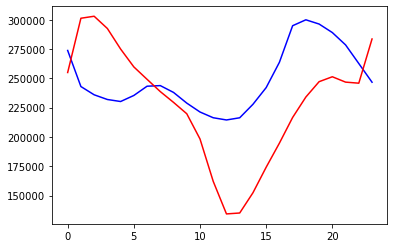

RMSE value:  51351.06784101491


In [41]:
howManyFutureHours = 24
window_size = 3
numEpochs = 20
iters = 5
columnsForDf = ['HLY_TEMP_NORMAL_LA', 'HLY_TEMP_10PCTL_LA',
       'HLY_TEMP_90PCTL_LA', 'HLY_DEWP_NORMAL_LA', 'HLY_DEWP_10PCTL_LA',
       'HLY_DEWP_90PCTL_LA', 'HLY_PRES_NORMAL_LA', 'HLY_PRES_10PCTL_LA',
       'HLY_PRES_90PCTL_LA', 'HLY_CLDH_NORMAL_LA', 'HLY_HTDH_NORMAL_LA',
       'HLY_CLOD_PCTCLR_LA', 'HLY_CLOD_PCTFEW_LA', 'HLY_CLOD_PCTSCT_LA',
       'HLY_CLOD_PCTBKN_LA', 'HLY_CLOD_PCTOVC_LA', 'HLY_HIDX_NORMAL_LA',
       'HLY_WCHL_NORMAL_LA', 'HLY_WIND_AVGSPD_LA', 'HLY_WIND_PCTCLM_LA',
       'HLY_WIND_VCTDIR_LA', 'HLY_WIND_VCTSPD_LA', 'HLY_WIND_1STDIR_LA',
       'HLY_WIND_1STPCT_LA', 'HLY_WIND_2NDDIR_LA', 'HLY_WIND_2NDPCT_LA',
        'Day sin', 'Day cos', 'Year sin', 'Year cos','Megawatts_2019']
columns = ['HLY_TEMP_NORMAL_LA', 'HLY_TEMP_10PCTL_LA',
       'HLY_TEMP_90PCTL_LA', 'HLY_DEWP_NORMAL_LA', 'HLY_DEWP_10PCTL_LA',
       'HLY_DEWP_90PCTL_LA', 'HLY_PRES_NORMAL_LA', 'HLY_PRES_10PCTL_LA',
       'HLY_PRES_90PCTL_LA', 'HLY_CLDH_NORMAL_LA', 'HLY_HTDH_NORMAL_LA',
       'HLY_CLOD_PCTCLR_LA', 'HLY_CLOD_PCTFEW_LA', 'HLY_CLOD_PCTSCT_LA',
       'HLY_CLOD_PCTBKN_LA', 'HLY_CLOD_PCTOVC_LA', 'HLY_HIDX_NORMAL_LA',
       'HLY_WCHL_NORMAL_LA', 'HLY_WIND_AVGSPD_LA', 'HLY_WIND_PCTCLM_LA',
       'HLY_WIND_VCTDIR_LA', 'HLY_WIND_VCTSPD_LA', 'HLY_WIND_1STDIR_LA',
       'HLY_WIND_1STPCT_LA', 'HLY_WIND_2NDDIR_LA', 'HLY_WIND_2NDPCT_LA']

bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, columnsForDf, columns)

In [16]:
directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/'
dataFiles = [f for f in listdir(directory) if isfile(join(directory, f))] 
for file in dataFiles:
    print(file)
    df = pd.read_csv(directory + file)

#for now, I will only use SF data 
location = '_LA'
fileRead = directory + dataFiles[3]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)

SAC-NOAA-and-Megawatts.csv
SD-NOAA-and-Megawatts.csv
SF-NOAA-and-Megawatts.csv
LA-NOAA-and-Megawatts.csv
fileRead:  /Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/LA-NOAA-and-Megawatts.csv


In [17]:
df.columns

Index(['date', 'HLY_TEMP_NORMAL_LA', 'HLY_TEMP_10PCTL_LA',
       'HLY_TEMP_90PCTL_LA', 'HLY_DEWP_NORMAL_LA', 'HLY_DEWP_10PCTL_LA',
       'HLY_DEWP_90PCTL_LA', 'HLY_PRES_NORMAL_LA', 'HLY_PRES_10PCTL_LA',
       'HLY_PRES_90PCTL_LA', 'HLY_CLDH_NORMAL_LA', 'HLY_HTDH_NORMAL_LA',
       'HLY_CLOD_PCTCLR_LA', 'HLY_CLOD_PCTFEW_LA', 'HLY_CLOD_PCTSCT_LA',
       'HLY_CLOD_PCTBKN_LA', 'HLY_CLOD_PCTOVC_LA', 'HLY_HIDX_NORMAL_LA',
       'HLY_WCHL_NORMAL_LA', 'HLY_WIND_AVGSPD_LA', 'HLY_WIND_PCTCLM_LA',
       'HLY_WIND_VCTDIR_LA', 'HLY_WIND_VCTSPD_LA', 'HLY_WIND_1STDIR_LA',
       'HLY_WIND_1STPCT_LA', 'HLY_WIND_2NDDIR_LA', 'HLY_WIND_2NDPCT_LA',
       'Megawatts_2019'],
      dtype='object')

In [ ]:
['date', 'HLY_TEMP_NORMAL_SD', 'HLY_TEMP_10PCTL_SD',
       'HLY_TEMP_90PCTL_SD', 'HLY_DEWP_NORMAL_SD', 'HLY_DEWP_10PCTL_SD',
       'HLY_DEWP_90PCTL_SD', 'HLY_PRES_NORMAL_SD', 'HLY_PRES_10PCTL_SD',
       'HLY_PRES_90PCTL_SD', 'HLY_CLDH_NORMAL_SD', 'HLY_HTDH_NORMAL_SD',
       'HLY_CLOD_PCTCLR_SD', 'HLY_CLOD_PCTFEW_SD', 'HLY_CLOD_PCTSCT_SD',
       'HLY_CLOD_PCTBKN_SD', 'HLY_CLOD_PCTOVC_SD', 'HLY_HIDX_NORMAL_SD',
       'HLY_WCHL_NORMAL_SD', 'HLY_WIND_AVGSPD_SD', 'HLY_WIND_PCTCLM_SD',
       'HLY_WIND_VCTDIR_SD', 'HLY_WIND_VCTSPD_SD', 'HLY_WIND_1STDIR_SD',
       'HLY_WIND_1STPCT_SD', 'HLY_WIND_2NDDIR_SD', 'HLY_WIND_2NDPCT_SD',
       'Megawatts_2019']